VALORES MISSING, OUTLIERS Y CORRELACIONES

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.impute import KNNImputer
import scipy.stats as ss
import warnings

FUNCIONES

In [3]:
def plot_feature(df, col_name, isContinuous, target):
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    count_null = df[col_name].isnull().sum()
    if isContinuous:
        
        sns.histplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name+ ' Numero de nulos: '+str(count_null))
    plt.xticks(rotation = 90)


    if isContinuous:
        sns.boxplot(x=col_name, y=target, data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by '+target)
    else:
        data = df.groupby(col_name)[target].value_counts(normalize=True).to_frame('proportion').reset_index() 
        data.columns = [i, target, 'proportion']
        #sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        ax2.set_ylabel(target+' fraction')
        ax2.set_title(target)
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()

def dame_variables_categoricas(dataset=None):
    if dataset is None:
        print(u'\nFaltan argumentos por pasar a la función')
        return 1
    lista_variables_categoricas = []
    other = []

    for i in dataset.columns:

        if dataset[i].dtype == object:
            unicos = int(len(np.unique(dataset[i].dropna(axis=0, how='all'))))
            if unicos < 100:
                lista_variables_categoricas.append(i)
            else:
                other.append(i)
        
        if dataset[i].dtype == int:
            unicos = int(len(np.unique(dataset[i].dropna(axis=0, how='all'))))
            if unicos < 10:
                lista_variables_categoricas.append(i)
            else:
                other.append(i)

    return lista_variables_categoricas, other

def get_corr_matrix(dataset = None, metodo='pearson', size_figure=[10,8]):
    # Para obtener la correlación de Spearman, sólo cambiar el metodo por 'spearman'

    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    # Compute the correlation matrix
    corr = dataset.corr(method=metodo) 
    # Set self-correlation to zero to avoid distraction
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size_figure)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, center=0,
                square=True, linewidths=.5,  cmap ='viridis' ) #cbar_kws={"shrink": .5}
    plt.show()
    
    return 0

def get_deviation_of_mean_perc(pd_loan, list_var_continuous, target, multiplier):
    pd_final = pd.DataFrame()
    
    for i in list_var_continuous:
        
        series_mean = pd_loan[i].mean()
        series_std = pd_loan[i].std()
        std_amp = multiplier * series_std
        left = series_mean - std_amp
        right = series_mean + std_amp
        size_s = pd_loan[i].size
        
        perc_goods = pd_loan[i][(pd_loan[i] >= left) & (pd_loan[i] <= right)].size/size_s
        perc_excess = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size/size_s
        
        if perc_excess>0:    
            pd_concat_percent = pd.DataFrame(pd_loan[target][(pd_loan[i] < left) | (pd_loan[i] > right)]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            pd_concat_percent = pd_concat_percent.drop('TARGET',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_outlier_values'] = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size
            pd_concat_percent['porcentaje_sum_null_values'] = perc_excess
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final

def get_percent_null_values_target(pd_loan, list_var_continuous, target):

    pd_final = pd.DataFrame()
    for i in list_var_continuous:
        if pd_loan[i].isnull().sum()>0:
            pd_concat_percent = pd.DataFrame(pd_loan[target][pd_loan[i].isnull()]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            pd_concat_percent = pd_concat_percent.drop('TARGET',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_null_values'] = pd_loan[i].isnull().sum()
            pd_concat_percent['porcentaje_sum_null_values'] = pd_loan[i].isnull().sum()/pd_loan.shape[0]
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final

def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


Con estas funciones estamos tratando de hacer varias cosas:

1. plot_feature: va a generar gráficos específicos para cada variable donde hará un histograma para analizar la distribución y boxplot para ver cómo se distribuyen los valores en base a la variable TARGET para las variables contínuas. Para las variables categóricas va a crear dos gráficos de barras, para la frecuencia de la variable y otro con las proporciones por categoría de TARGET

2. dame_variables_categoricas: trata de identificar variables categóricas y separarlas en dos: aquellas variables que tienen menos de 100 valores únicos (estas pueden ser muy útiles en nuestro análisis), y aquellas que tienen más de 100 registros únicos

3. get_corr_matrix: para visualizar la matriz de correlación para variables numéricas 

4. get_deviation_of_mean_perc: crea un rango de valores alrededor de la media con la desviación típica y encuentra la proporción de valores dentro y fuera de este intervalo, para así poder ver los valores atípicos y la relación que tienen con la variable TARGET.

5. get_percent_values_target: es para analizar la relación que hay entre valores nulos y la variable TARGET. 

6. cramers_v: para ver la relación entre variables categóricas usando la estadística de Cramer

LECTURA DE DATOS DEL PREPROCESADO INICIAL

In [4]:
path_folder = "../data/"
pd_loan = pd.read_csv(path_folder +"pd_data_initial_preprocessing.csv", low_memory=False).set_index('SK_ID_CURR')

pd_loan.head()

Unnamed: 0  COMMONAREA_AVG  COMMONAREA_MODE  COMMONAREA_MEDI  \
SK_ID_CURR                                                                 
100002               0          0.0143           0.0144           0.0144   
100003               1          0.0605           0.0497           0.0608   
100004               2             NaN              NaN              NaN   
100006               3             NaN              NaN              NaN   
100007               4             NaN              NaN              NaN   

            NONLIVINGAPARTMENTS_MEDI  NONLIVINGAPARTMENTS_MODE  \
SK_ID_CURR                                                       
100002                        0.0000                       0.0   
100003                        0.0039                       0.0   
100004                           NaN                       NaN   
100006                           NaN                       NaN   
100007                           NaN                       NaN   

            NONLIVINGAPARTMENTS_AVG FONDKAPREMONT_MODE  LIVINGAPARTMENTS_AVG  \
SK_ID_CURR                                                                     
100002                       0.0000   reg oper account                0.0202   
100003                       0.0039   reg oper account                0.0773   
100004                          NaN                NaN                   NaN   
100006                          NaN                NaN                   NaN   
100007                          NaN                NaN                   NaN   

            LIVINGAPARTMENTS_MEDI  ...  FLAG_DOCUMENT_13  FLAG_DOCUMENT_19  \
SK_ID_CURR                         ...                                       
100002                     0.0205  ...                 0                 0   
100003                     0.0787  ...                 0                 0   
100004                        NaN  ...                 0                 0   
100006                        NaN  ...                 0                 0   
100007                        NaN  ...                 0                 0   

            FLAG_DOCUMENT_18  FLAG_DOCUMENT_17  FLAG_DOCUMENT_16  \
SK_ID_CURR                                                         
100002                     0                 0                 0   
100003                     0                 0                 0   
100004                     0                 0                 0   
100006                     0                 0                 0   
100007                     0                 0                 0   

            FLAG_DOCUMENT_15  FLAG_DOCUMENT_14  FLAG_DOCUMENT_20  \
SK_ID_CURR                                                         
100002                     0                 0                 0   
100003                     0                 0                 0   
100004                     0                 0                 0   
100006                     0                 0                 0   
100007                     0                 0                 0   

            FLAG_DOCUMENT_21  NWEEKDAY_PROCESS_START  
SK_ID_CURR                                            
100002                     0                       3  
100003                     0                       1  
100004                     0                       1  
100006                     0                       3  
100007                     0                       4  

[5 rows x 123 columns]

En el siguiente código, estamos empleando las funciones que hemos creado en el principio del notebook para separar las variables categóricas y contínuas. 

In [5]:
list_var_cat, other = dame_variables_categoricas(dataset=pd_loan)
pd_loan[list_var_cat] = pd_loan[list_var_cat].astype("category")
list_var_continuous = list(pd_loan.select_dtypes('float').columns)
pd_loan[list_var_continuous] = pd_loan[list_var_continuous].astype(float)
pd_loan.dtypes

Unnamed: 0                     int64
COMMONAREA_AVG               float64
COMMONAREA_MODE              float64
COMMONAREA_MEDI              float64
NONLIVINGAPARTMENTS_MEDI     float64
                              ...   
FLAG_DOCUMENT_15            category
FLAG_DOCUMENT_14            category
FLAG_DOCUMENT_20            category
FLAG_DOCUMENT_21            category
NWEEKDAY_PROCESS_START      category
Length: 123, dtype: object

Algunas variables clasificadas inicialmente como enteras son de carácter booleano, lo que las hace categóricas. 

In [6]:
pd_loan.head()


Unnamed: 0  COMMONAREA_AVG  COMMONAREA_MODE  COMMONAREA_MEDI  \
SK_ID_CURR                                                                 
100002               0          0.0143           0.0144           0.0144   
100003               1          0.0605           0.0497           0.0608   
100004               2             NaN              NaN              NaN   
100006               3             NaN              NaN              NaN   
100007               4             NaN              NaN              NaN   

            NONLIVINGAPARTMENTS_MEDI  NONLIVINGAPARTMENTS_MODE  \
SK_ID_CURR                                                       
100002                        0.0000                       0.0   
100003                        0.0039                       0.0   
100004                           NaN                       NaN   
100006                           NaN                       NaN   
100007                           NaN                       NaN   

            NONLIVINGAPARTMENTS_AVG FONDKAPREMONT_MODE  LIVINGAPARTMENTS_AVG  \
SK_ID_CURR                                                                     
100002                       0.0000   reg oper account                0.0202   
100003                       0.0039   reg oper account                0.0773   
100004                          NaN                NaN                   NaN   
100006                          NaN                NaN                   NaN   
100007                          NaN                NaN                   NaN   

            LIVINGAPARTMENTS_MEDI  ...  FLAG_DOCUMENT_13  FLAG_DOCUMENT_19  \
SK_ID_CURR                         ...                                       
100002                     0.0205  ...                 0                 0   
100003                     0.0787  ...                 0                 0   
100004                        NaN  ...                 0                 0   
100006                        NaN  ...                 0                 0   
100007                        NaN  ...                 0                 0   

            FLAG_DOCUMENT_18  FLAG_DOCUMENT_17  FLAG_DOCUMENT_16  \
SK_ID_CURR                                                         
100002                     0                 0                 0   
100003                     0                 0                 0   
100004                     0                 0                 0   
100006                     0                 0                 0   
100007                     0                 0                 0   

            FLAG_DOCUMENT_15  FLAG_DOCUMENT_14  FLAG_DOCUMENT_20  \
SK_ID_CURR                                                         
100002                     0                 0                 0   
100003                     0                 0                 0   
100004                     0                 0                 0   
100006                     0                 0                 0   
100007                     0                 0                 0   

            FLAG_DOCUMENT_21  NWEEKDAY_PROCESS_START  
SK_ID_CURR                                            
100002                     0                       3  
100003                     0                       1  
100004                     0                       1  
100006                     0                       3  
100007                     0                       4  

[5 rows x 123 columns]

Utilizamos el ID de cliente como el índice del Dataframe. A continuación, identificamos las variables continuas y categóricas dentro del conjunto de datos

SEPARACIÓN EN TRAIN Y TEST ESTRATIFICADO

En este código estamos tratando de realizar un gráfico que nos muestre la proporción de la variable TARGET mediante un conteo de valores. 

In [22]:
pd_plot_target = pd_loan['TARGET'].value_counts(normalize=False).reset_index()

pd_plot_target.columns = ['TARGET', 'count']

fig = px.bar(pd_plot_target, x='TARGET', y='count')
fig.update_xaxes(tickvals=[0, 1])
fig.show()

Se observa que el muestreo está desbalanceado, ya que la mayoría de los clientes no tienen dificultades para pagar el préstamo. (0 = pagado y 1 = no pagado)
El 20% de los datos se asignan al conjunto de prueba y el 80% al conjunto de entrenamiento para entrenar el modelo.

In [8]:
from sklearn.model_selection import train_test_split
X_pd_loan, X_pd_loan_test, y_pd_loan, y_pd_loan_test = train_test_split(pd_loan.drop('TARGET',axis=1), 
                                                                     pd_loan['TARGET'], 
                                                                     stratify=pd_loan['TARGET'], 
                                                                     test_size=0.2)
pd_loan_train = pd.concat([X_pd_loan, y_pd_loan],axis=1)
pd_loan_test = pd.concat([X_pd_loan_test, y_pd_loan_test],axis=1)

In [9]:
print('== Train\n', pd_loan_train['TARGET'].value_counts(normalize=True))
print('== Test\n', pd_loan_test['TARGET'].value_counts(normalize=True))

== Train
 TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64
== Test
 TARGET
0    0.919272
1    0.080728
Name: proportion, dtype: float64


Aquí podemos ver que en la separación en train y test ha salido bien ya que con el argumento 'stratify' hemos puesto que queremos que en el train y en el test haya la misma proporción de la variable TARGET, lo que permite que el modelo tenga ejemplos de todas las clases en ambos conjuntos y así evita que el modelo tenga un sesgo hacia una clase en particular.

VISUALIZACIÓN DESCRIPTIVA DE LOS DATOS

Aquí vamos a realizar la suma de la cantidad de valores nulos que hay por filas y por columnas. 

pd_null_columnas contiene el número de valores nulos por columna y el % de valores nulos respecto al total de filas.
pd_null_filas contiene el número de valores nulos por filas y el porcentaje de valores nulos respecto al total de columnas, y la relación con la variable TARGET

In [10]:
pd_series_null_columns = pd_loan_train.isnull().sum().sort_values(ascending=False)
pd_series_null_rows = pd_loan_train.isnull().sum(axis=1).sort_values(ascending=False)
print(pd_series_null_columns.shape, pd_series_null_rows.shape)

pd_null_columnas = pd.DataFrame(pd_series_null_columns, columns=['nulos_columnas'])     
pd_null_filas = pd.DataFrame(pd_series_null_rows, columns=['nulos_filas'])  
pd_null_filas['TARGET'] = pd_loan['TARGET'].copy()
pd_null_columnas['porcentaje_columnas'] = pd_null_columnas['nulos_columnas']/pd_loan_train.shape[0]
pd_null_filas['porcentaje_filas']= pd_null_filas['nulos_filas']/pd_loan_train.shape[1]

(123,) (246008,)


In [11]:
pd_null_columnas.head()

nulos_columnas  porcentaje_columnas
COMMONAREA_AVG                    171942             0.698928
COMMONAREA_MODE                   171942             0.698928
COMMONAREA_MEDI                   171942             0.698928
NONLIVINGAPARTMENTS_MODE          170858             0.694522
NONLIVINGAPARTMENTS_MEDI          170858             0.694522

In [12]:
pd_null_filas.head()

nulos_filas TARGET  porcentaje_filas
SK_ID_CURR                                      
180861               61      0          0.495935
412312               61      0          0.495935
329262               61      0          0.495935
235599               61      0          0.495935
274127               61      0          0.495935

Hemos hecho un conteo y porcentaje de valores nulos por filas y columnas para identificar qué columnas y filas tienen más valores nulos por si hubiese que tomar la decisión de imputarlas o eliminarlas

TRATAMIENTO DE VARIABLES CATEGÓRICAS

In [13]:
list_var_cat

['FONDKAPREMONT_MODE',
 'WALLSMATERIAL_MODE',
 'HOUSETYPE_MODE',
 'EMERGENCYSTATE_MODE',
 'OCCUPATION_TYPE',
 'NAME_TYPE_SUITE',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_REGION_NOT_LIVE_REGION',
 'ORGANIZATION_TYPE',
 'NAME_CONTRACT_TYPE',
 'FLAG_OWN_CAR',
 'NAME_INCOME_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'NAME_EDUCATION_TYPE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'CODE_GENDER',
 'TARGET',
 'FLAG_OWN_REALTY',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_PHONE',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'REG_REGION_NOT_WORK_REGION',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_1

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



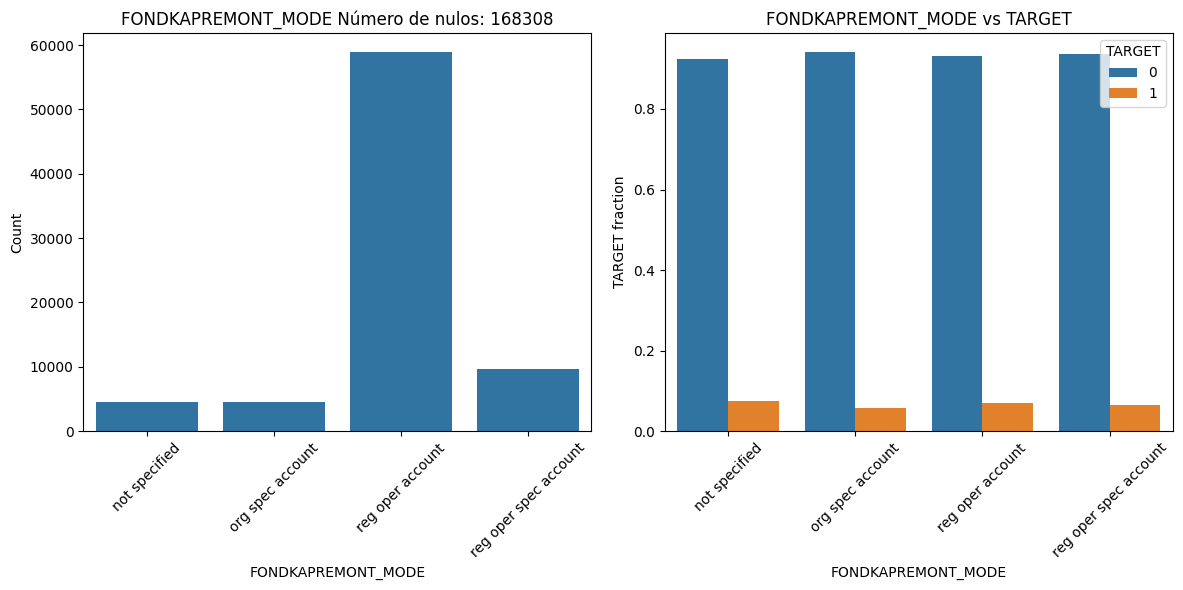

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



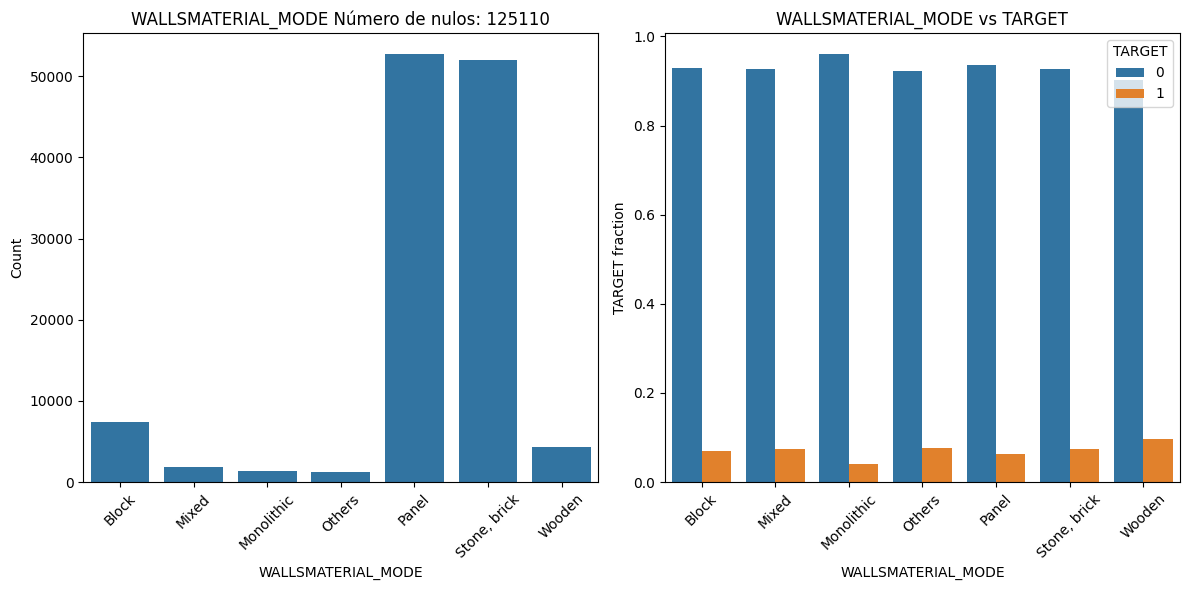

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



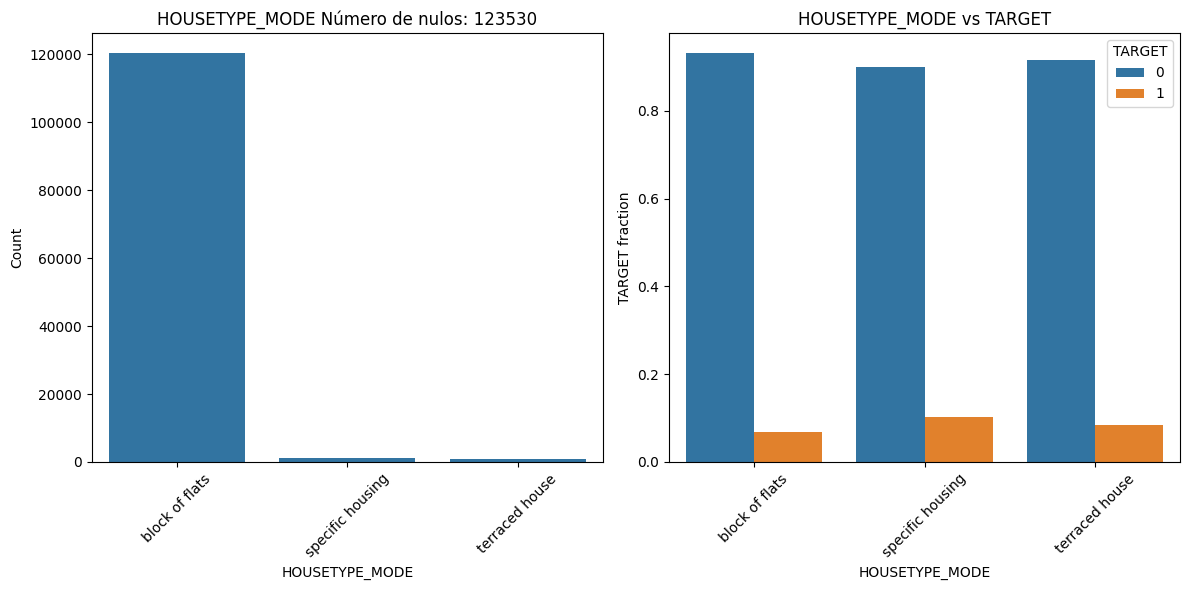

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



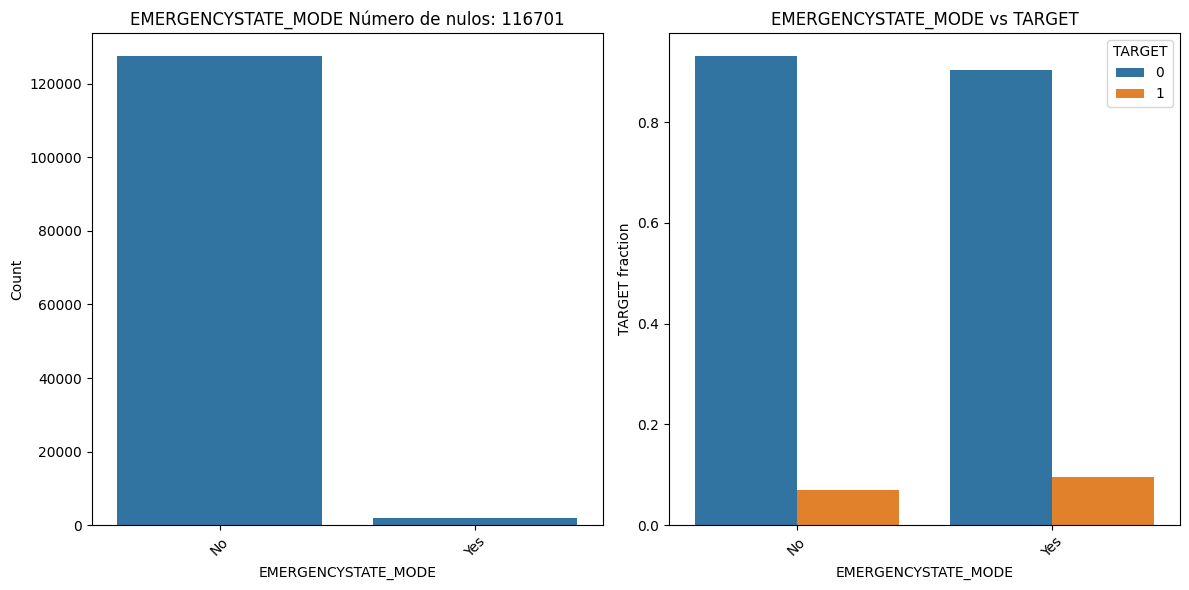

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



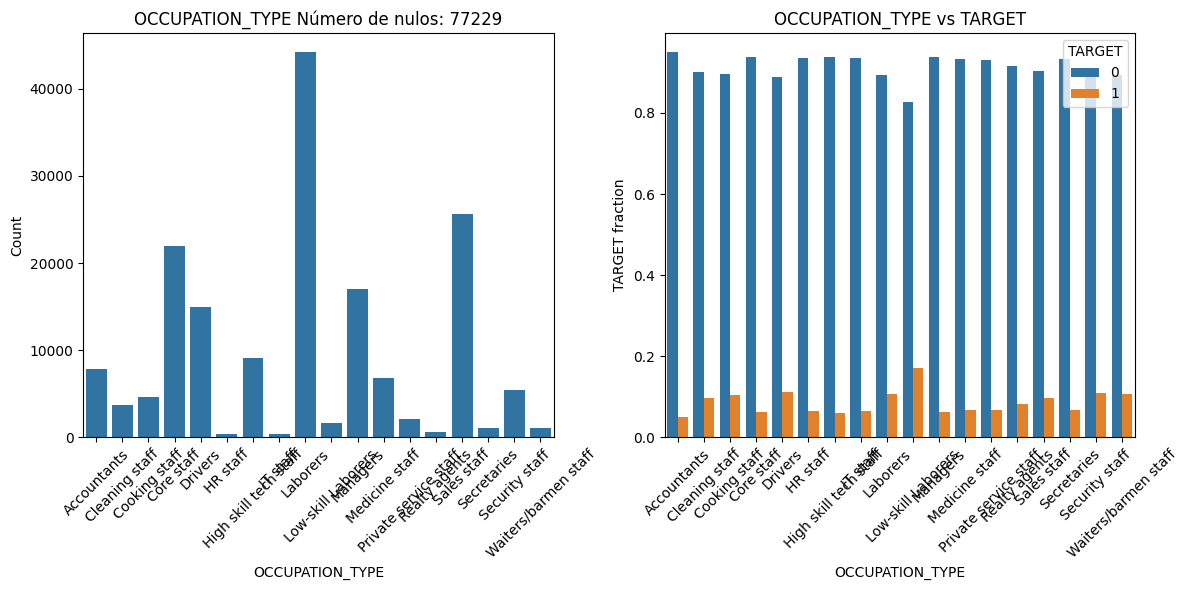

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



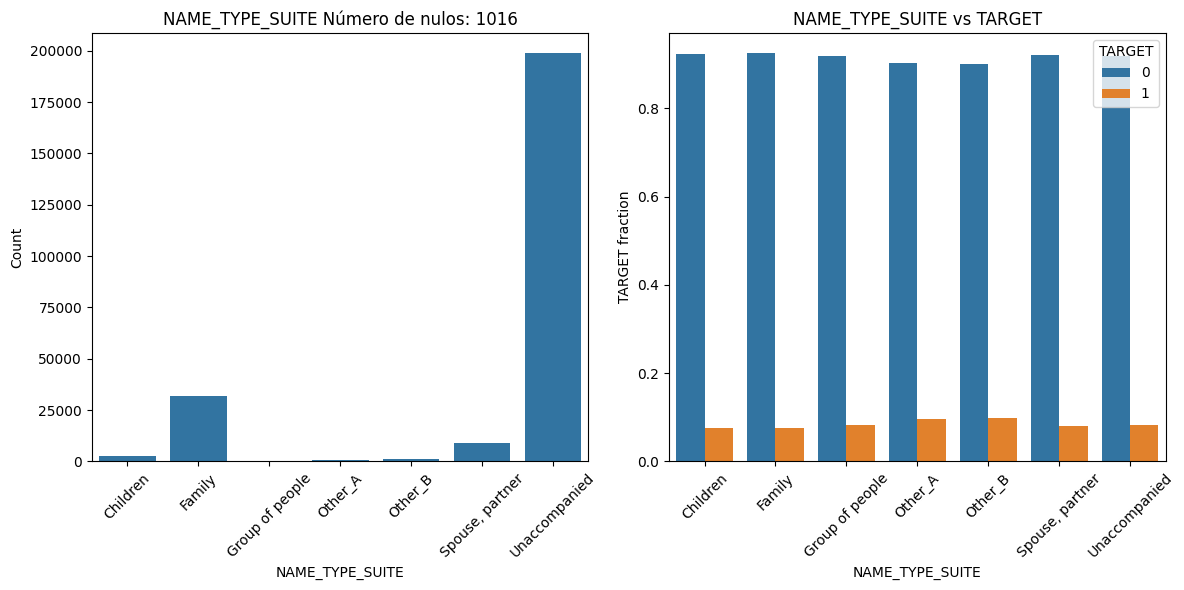

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



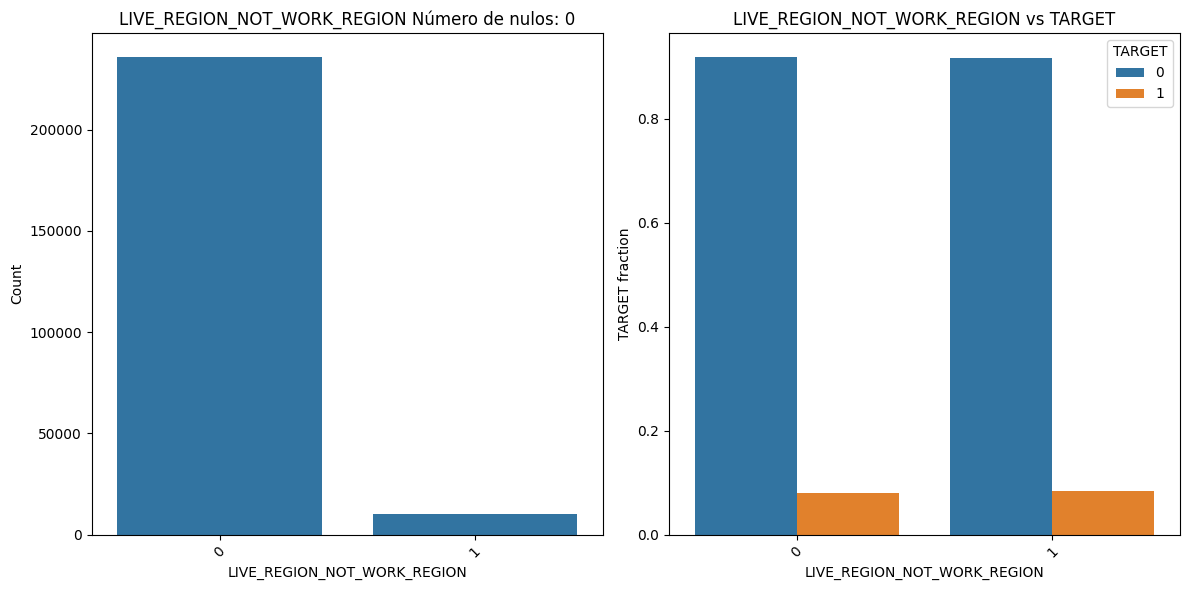

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



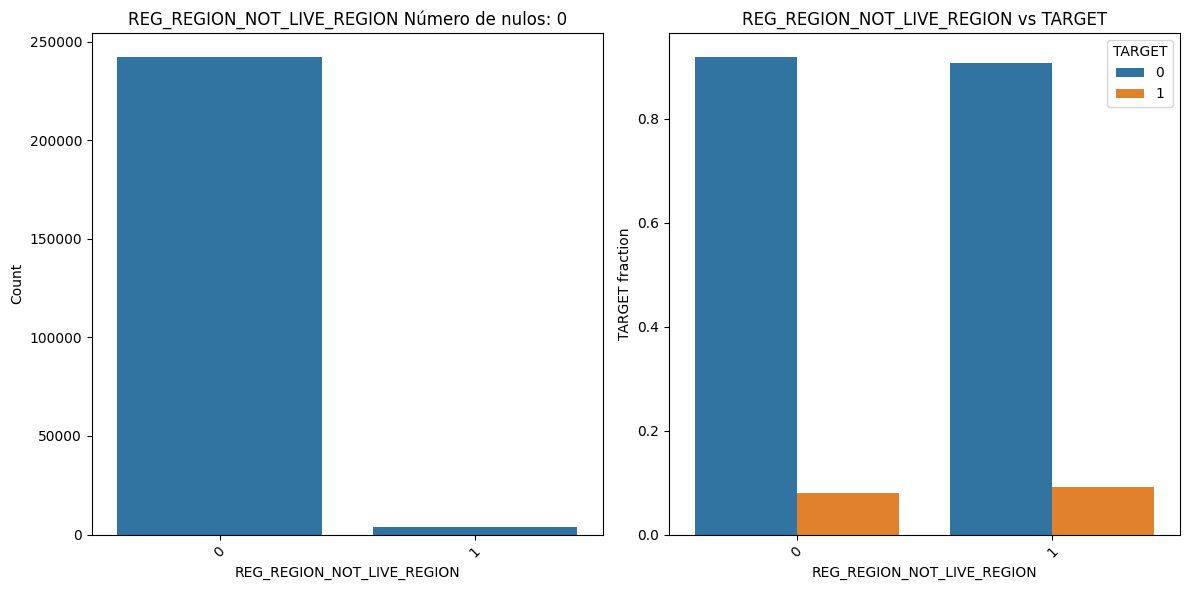

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



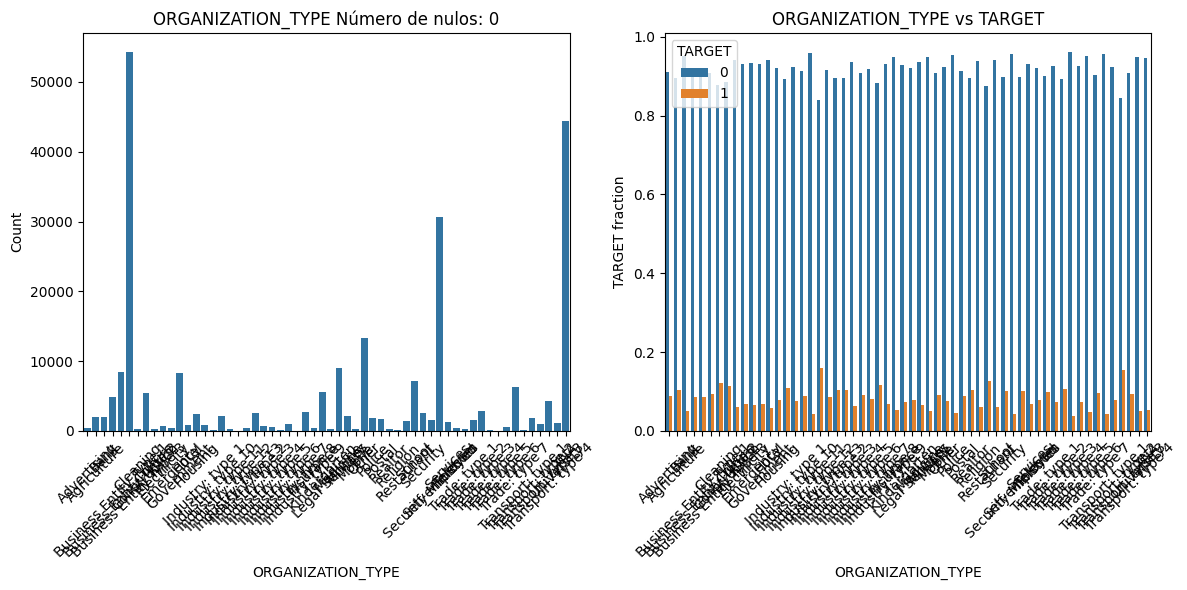

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



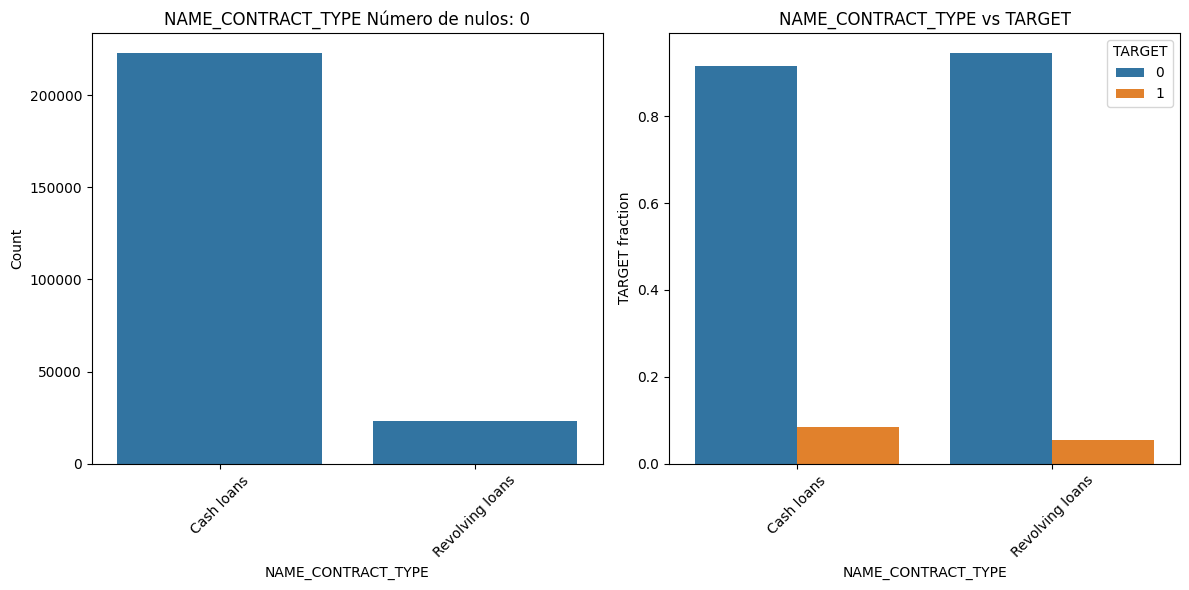

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



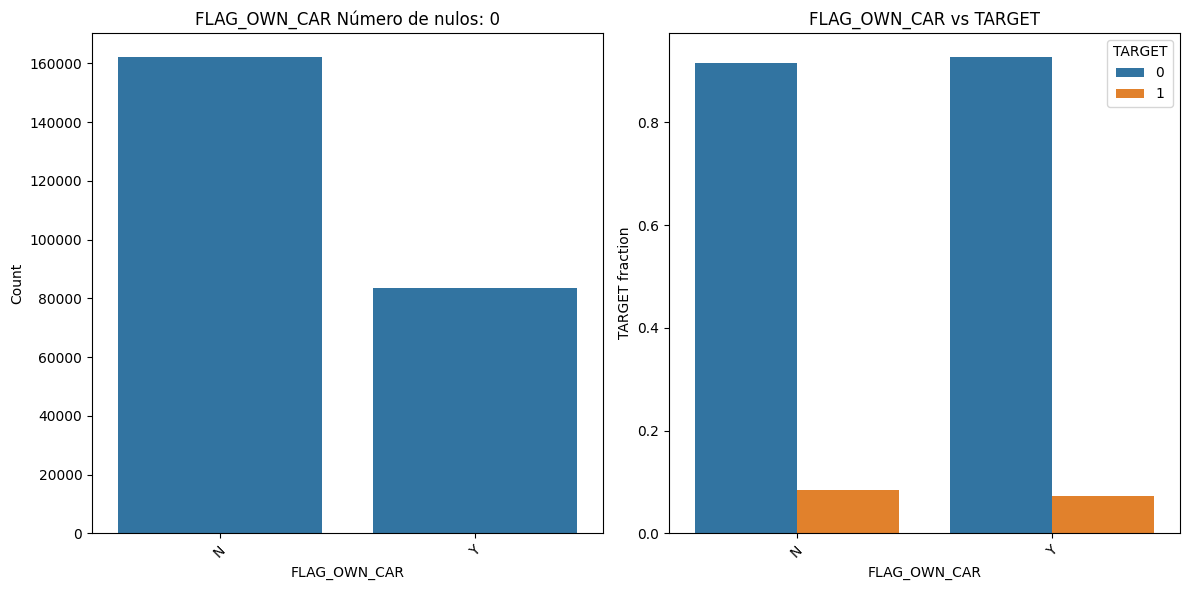

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



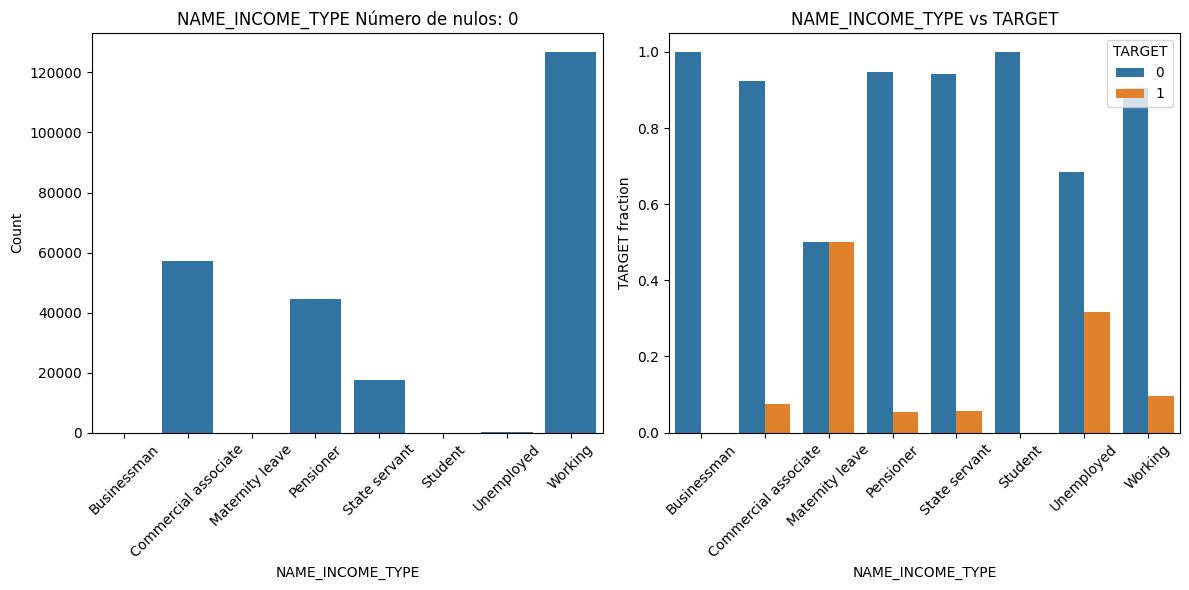

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



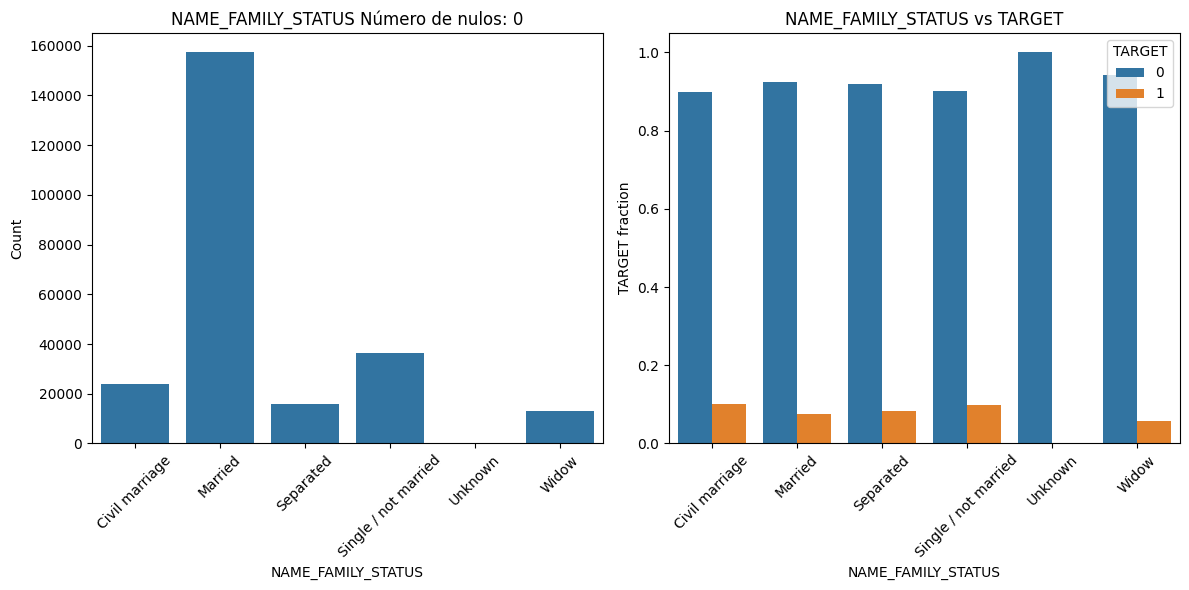

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



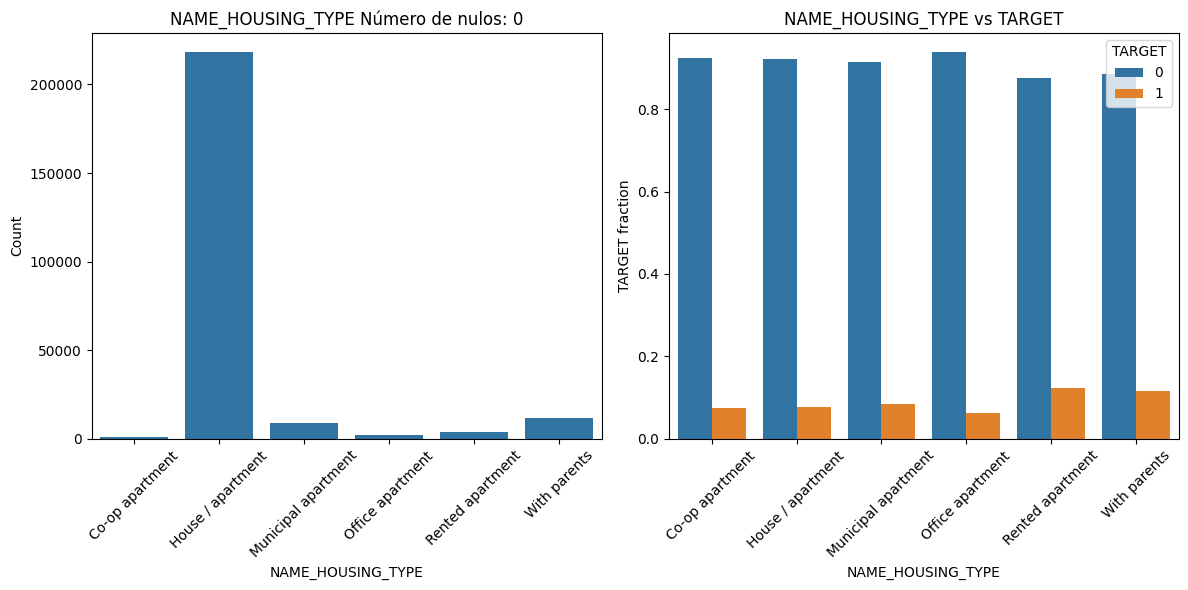

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



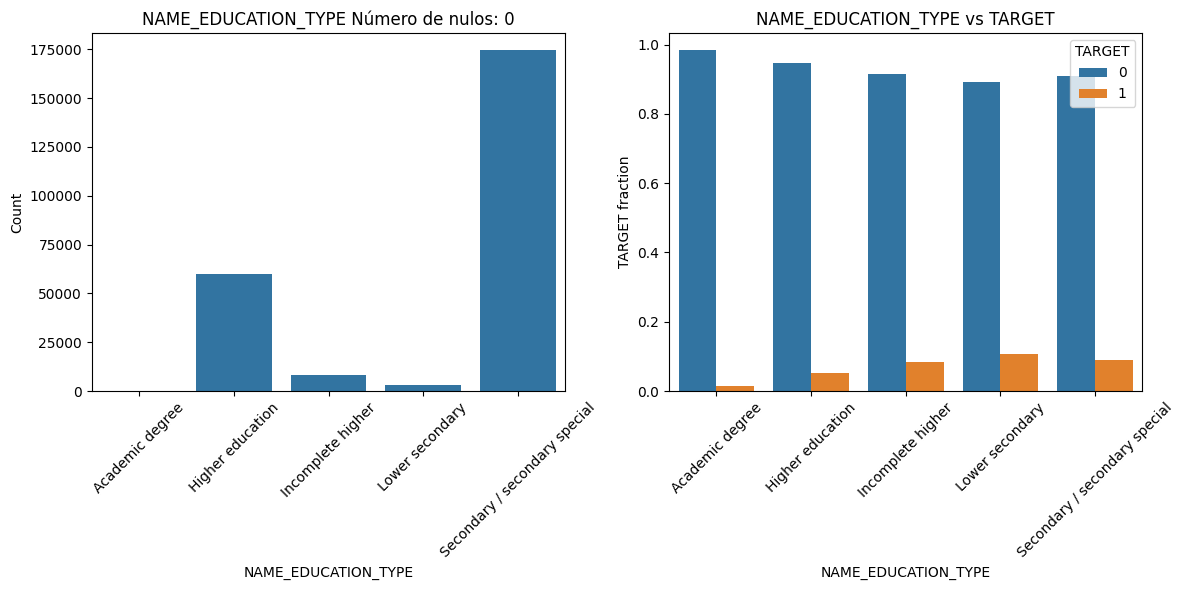

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



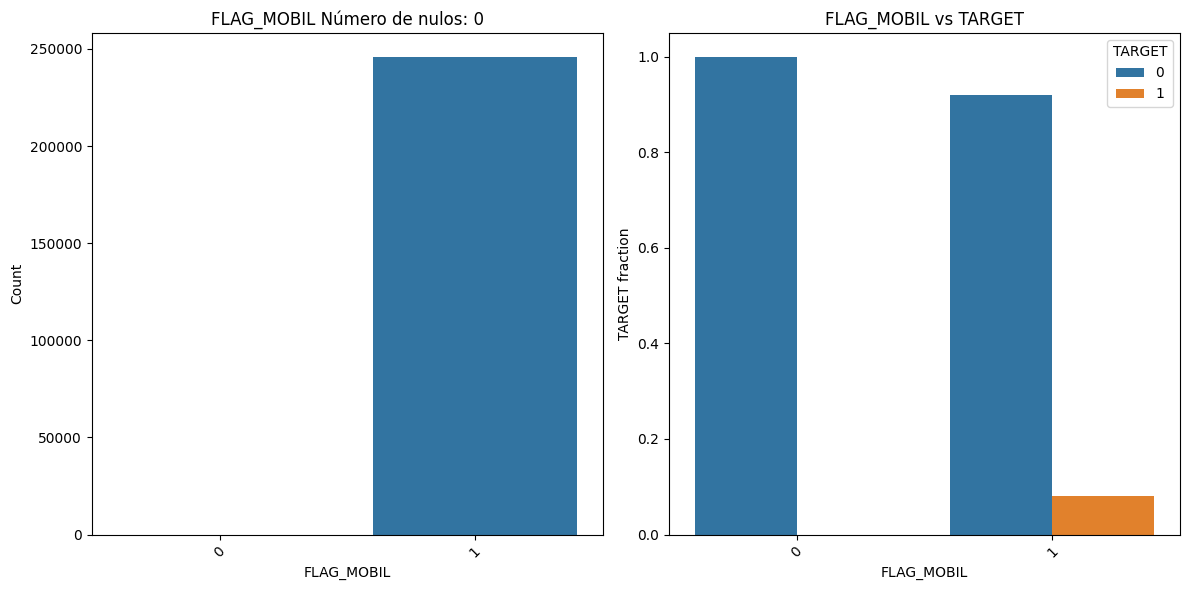

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



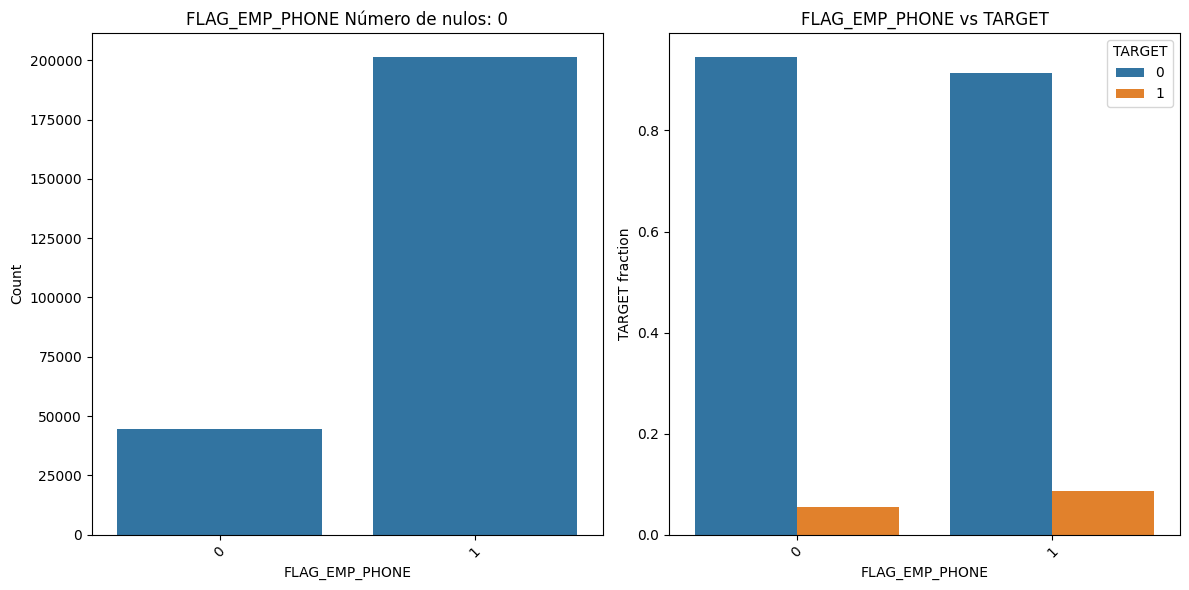

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



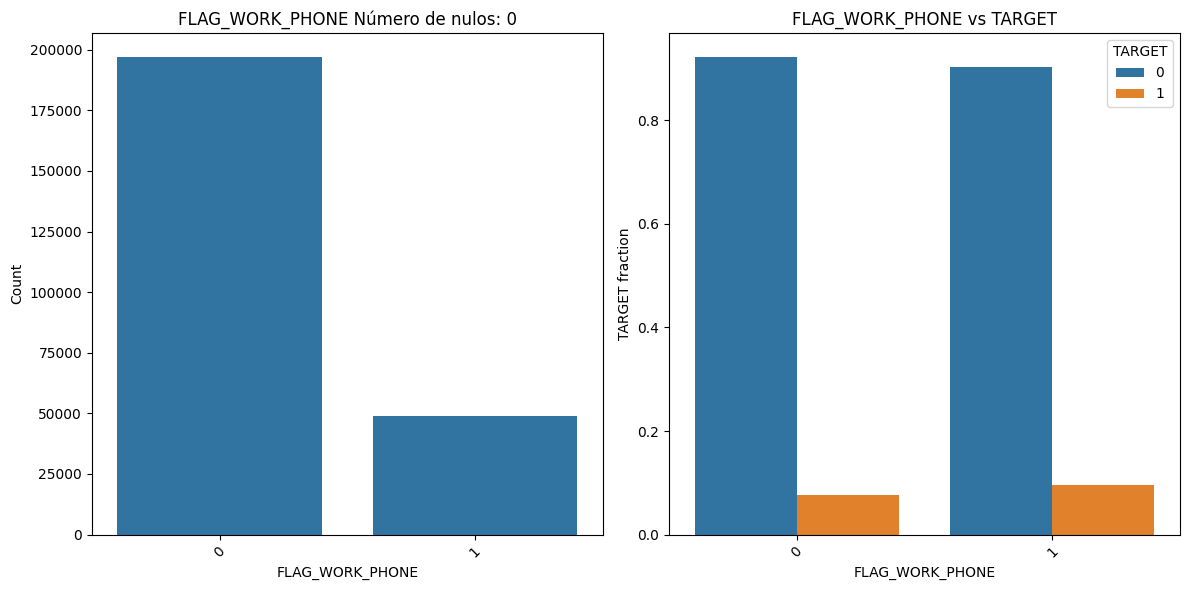

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



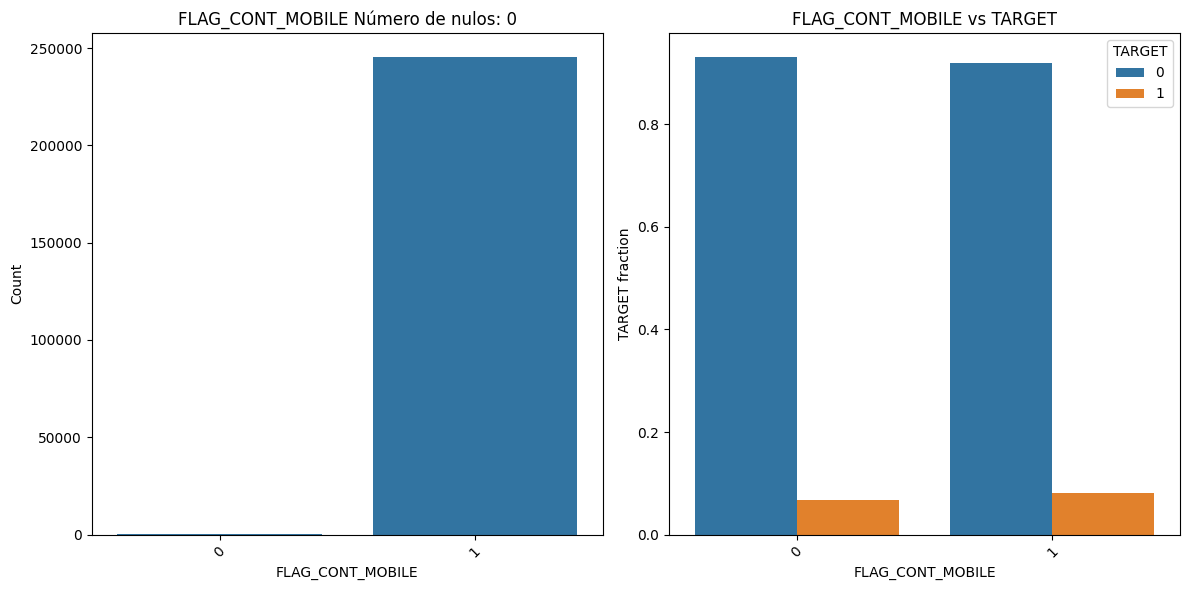

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



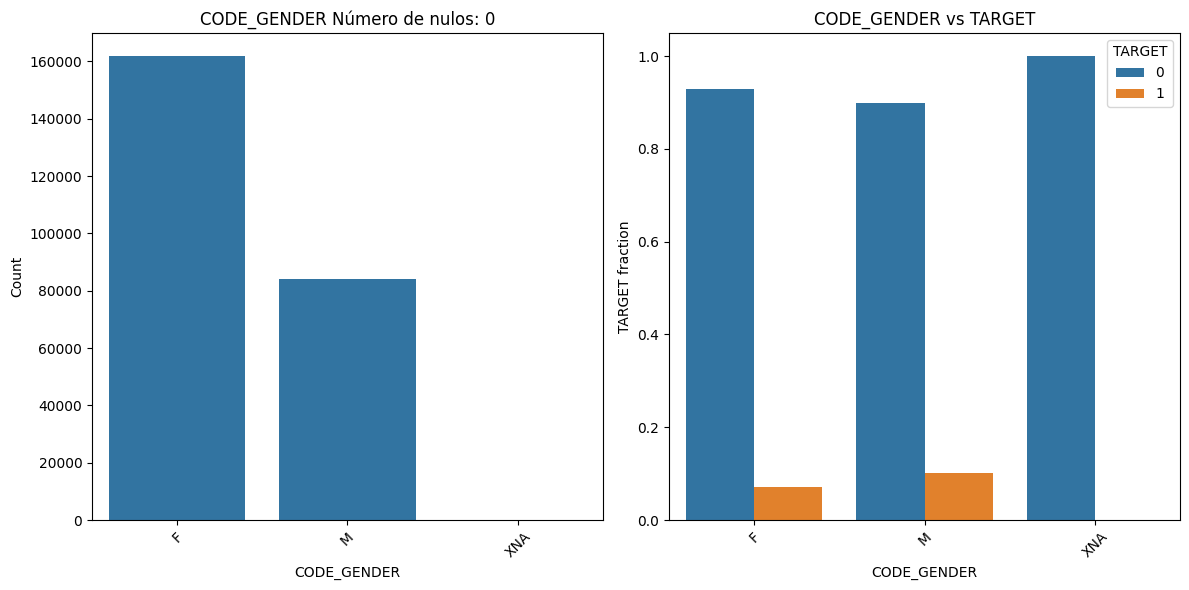

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



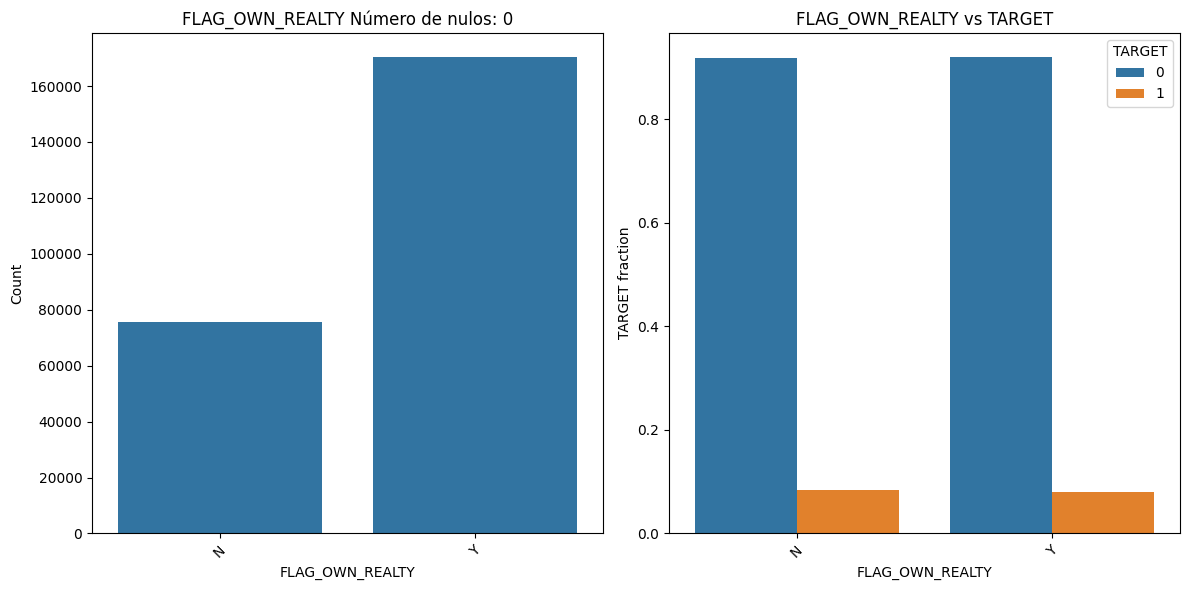

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



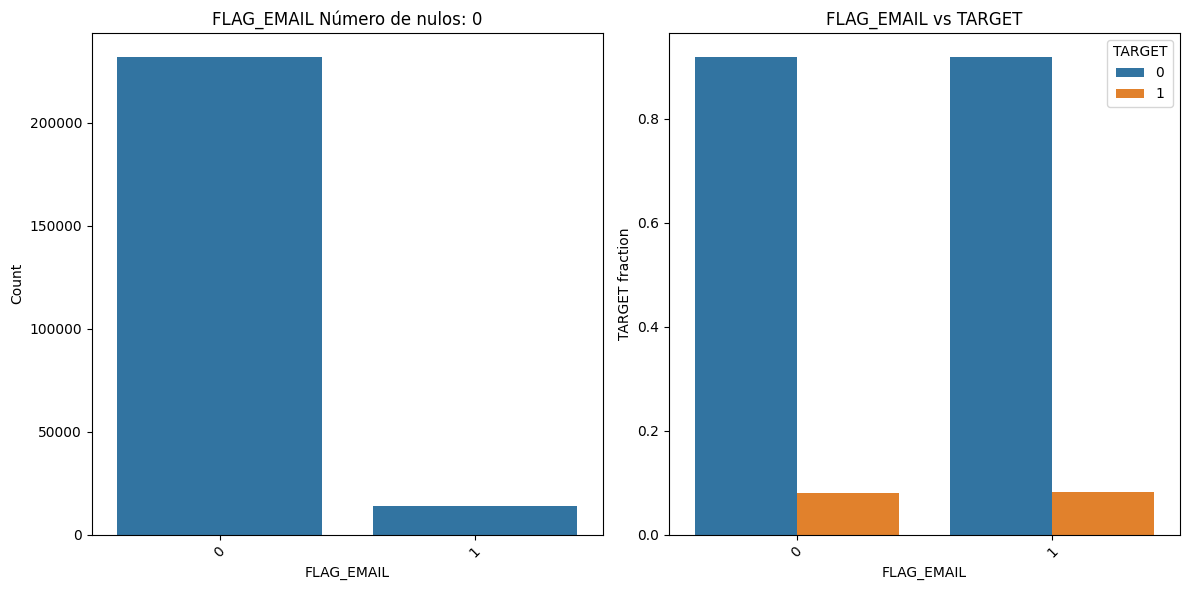

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



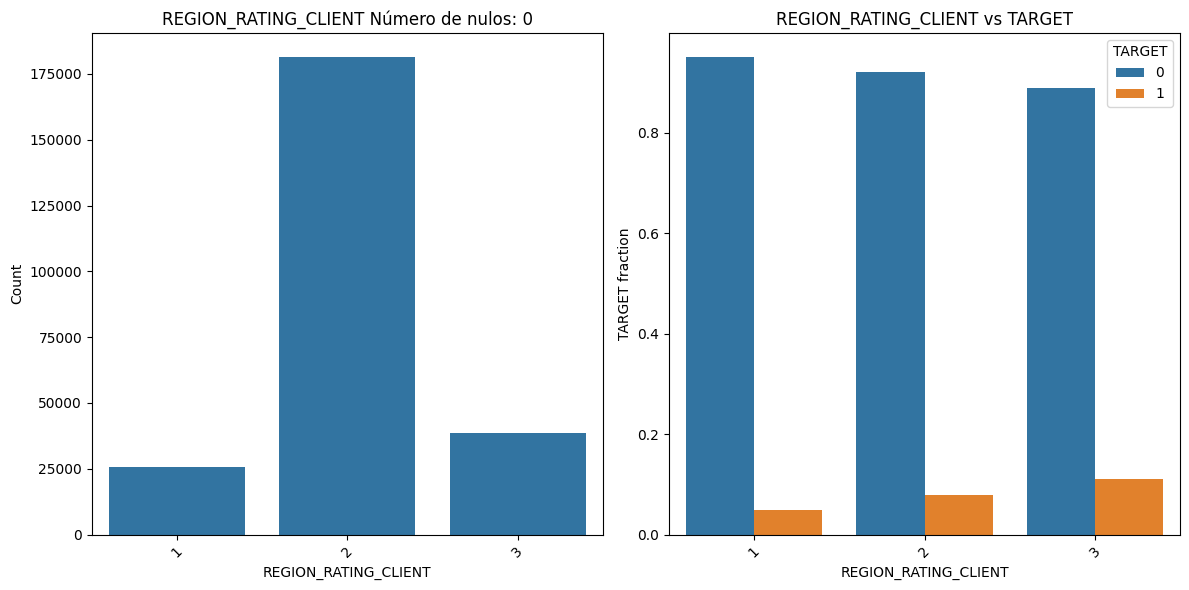

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



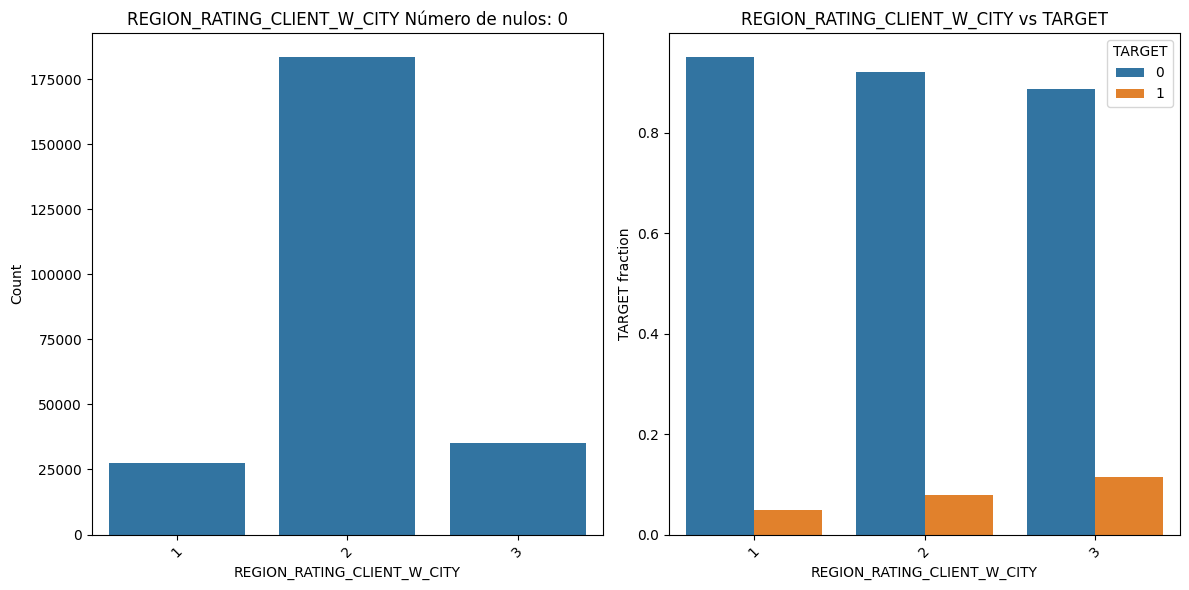

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



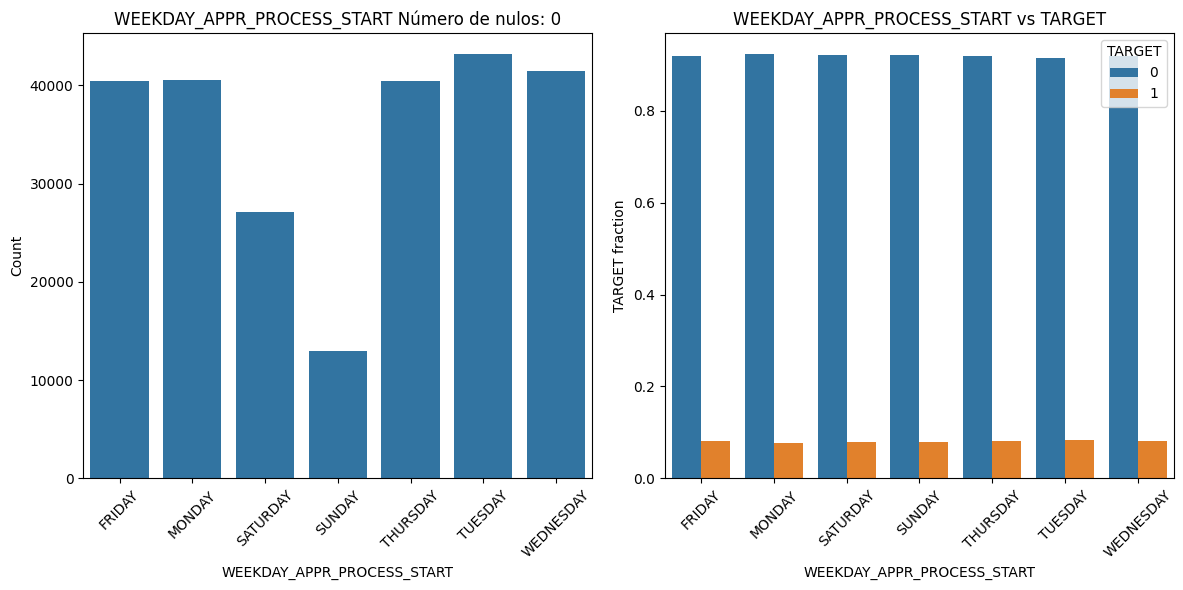

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



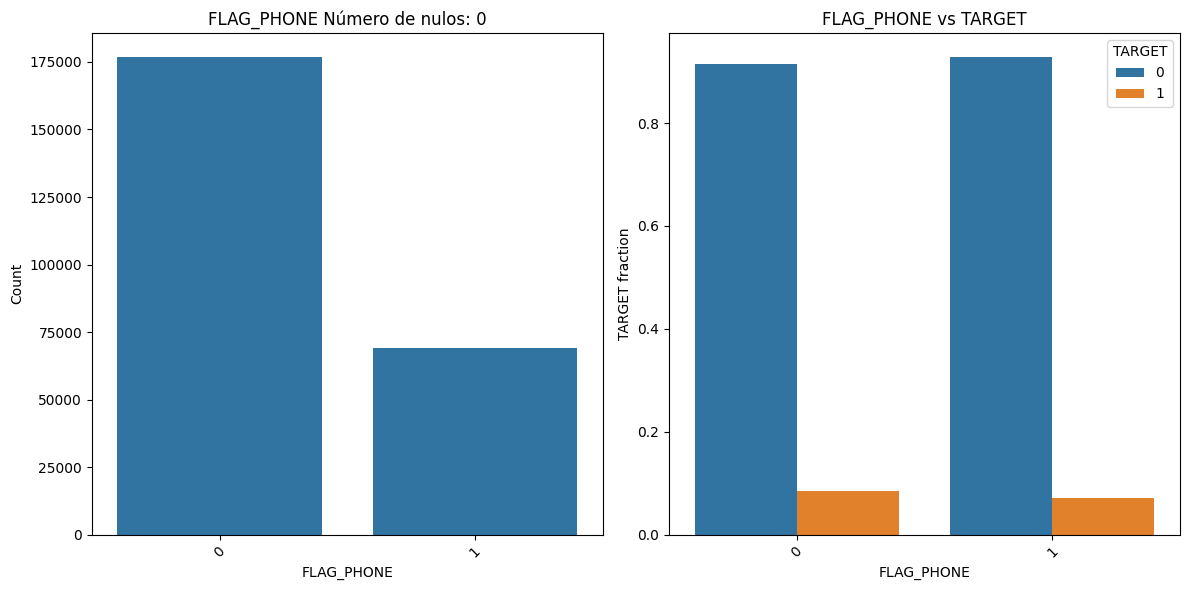

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



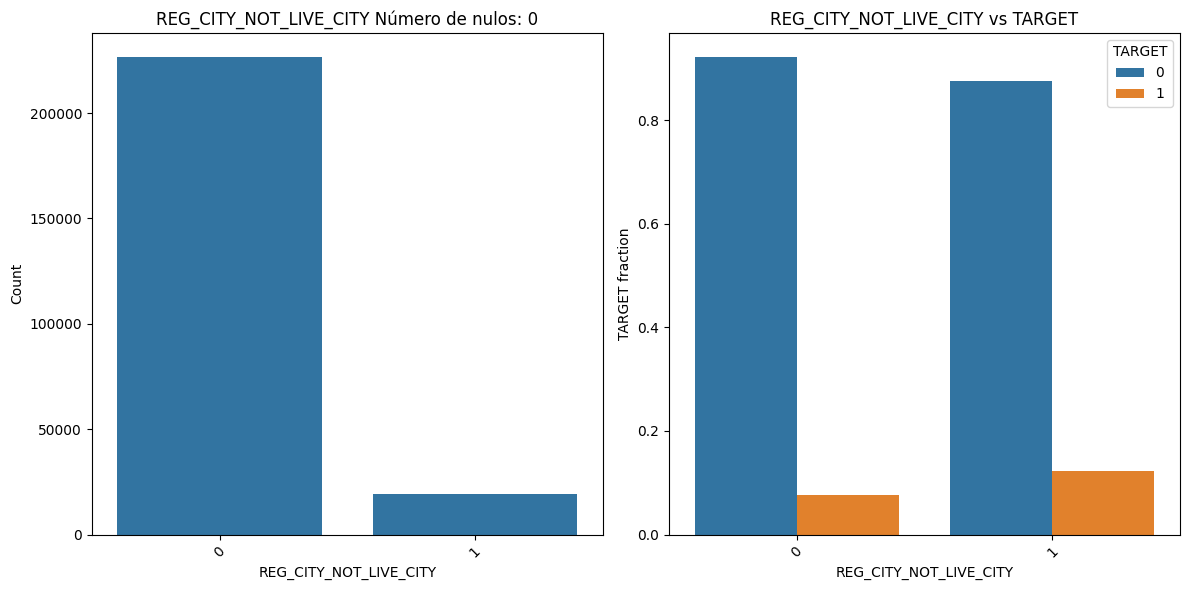

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



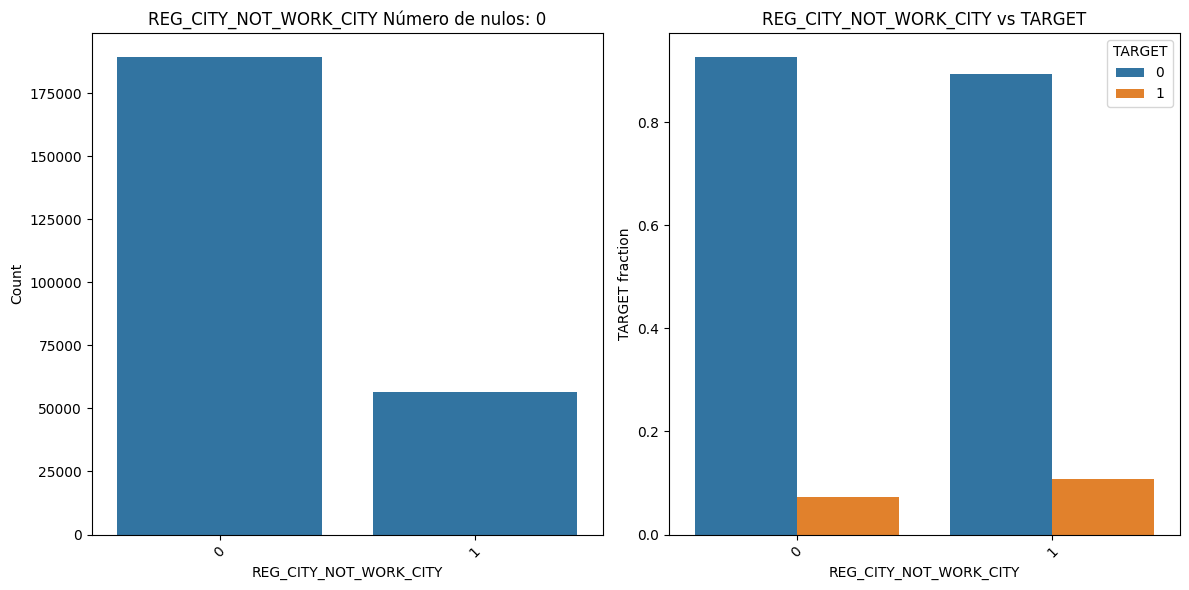

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



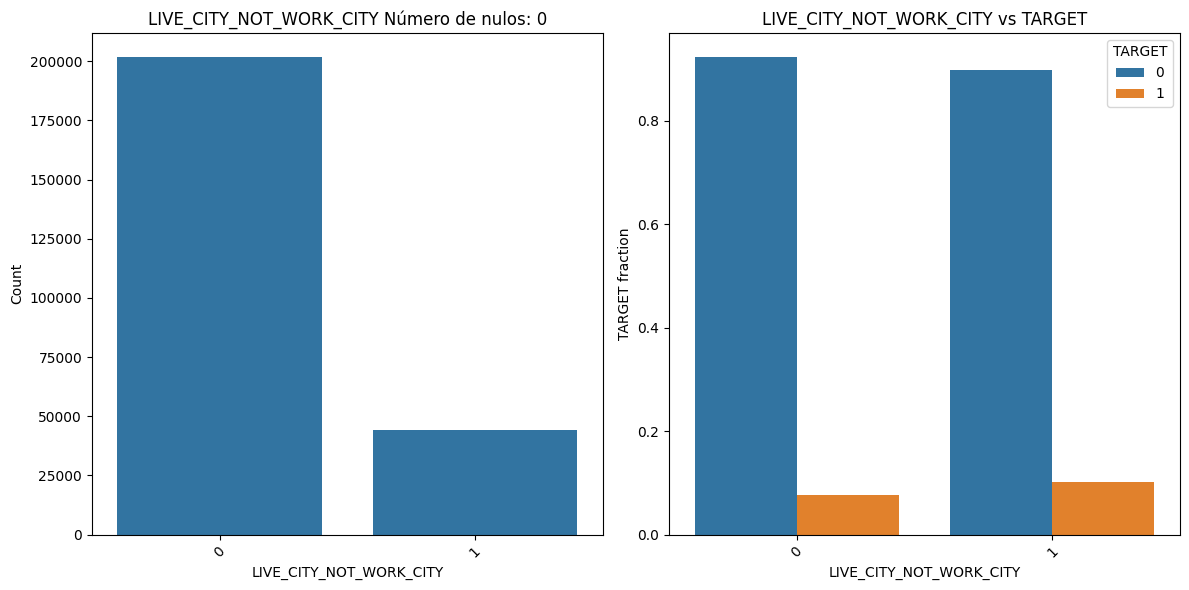

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



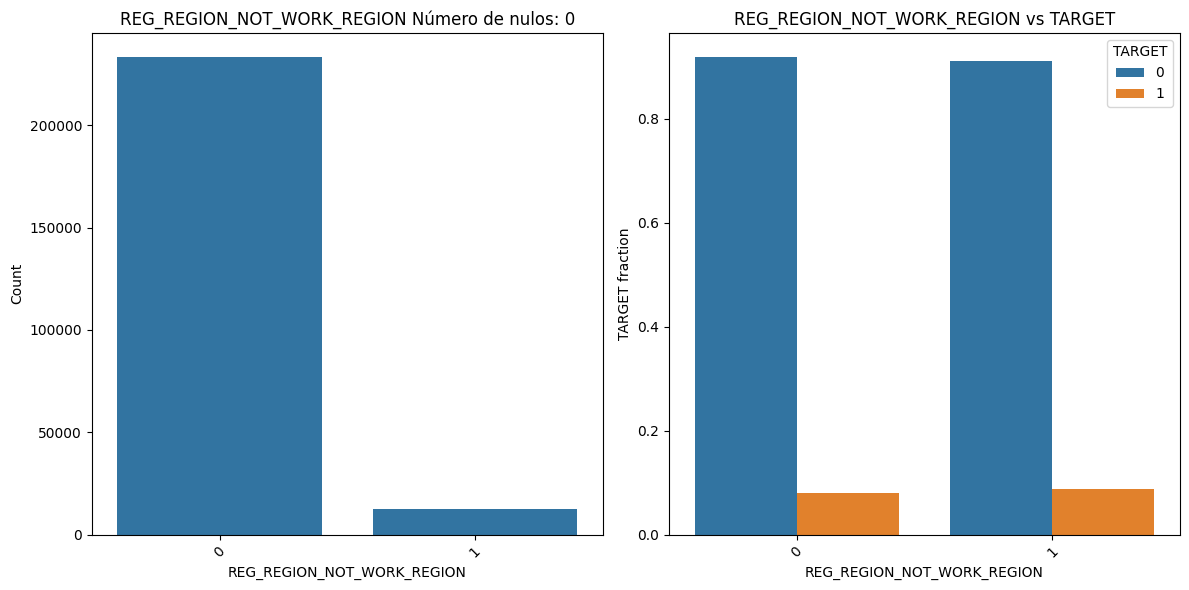

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



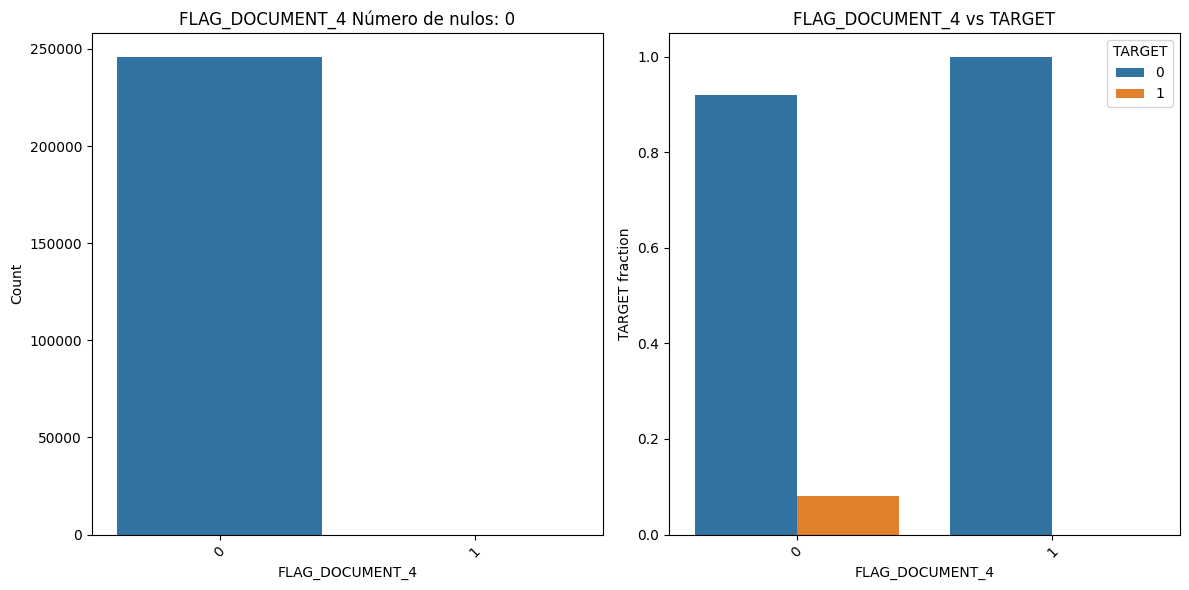

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



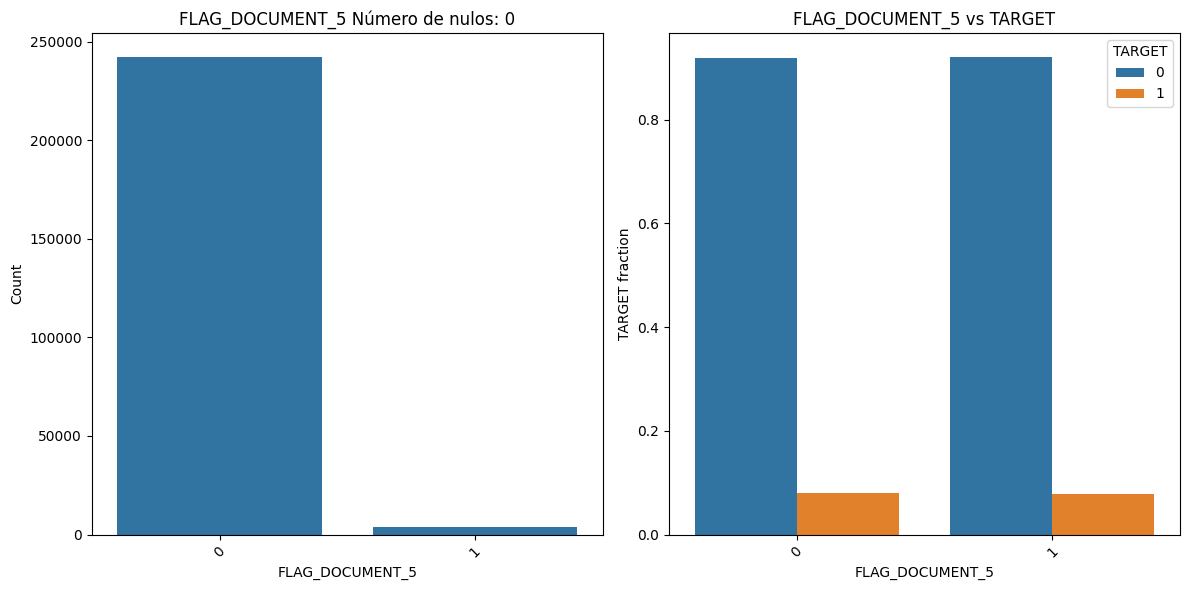

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



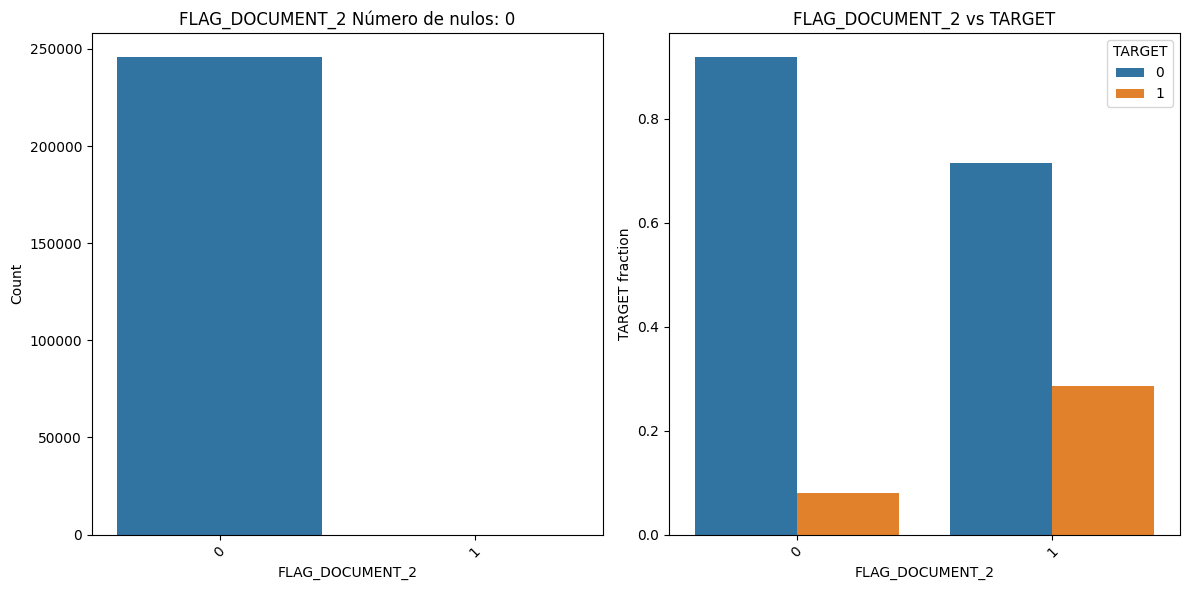

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



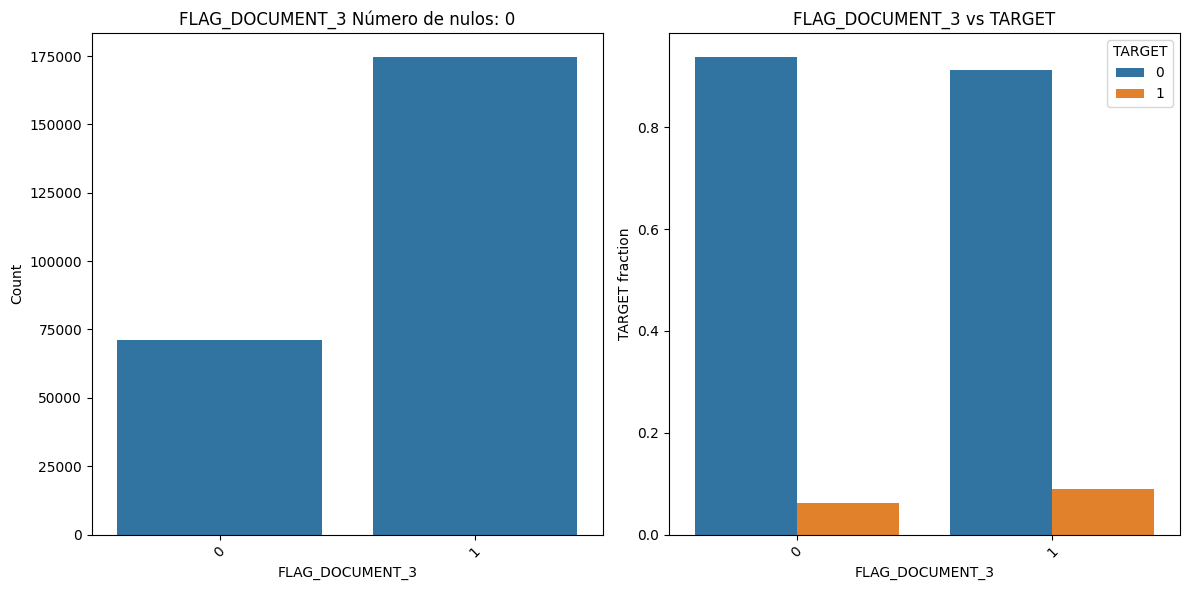

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



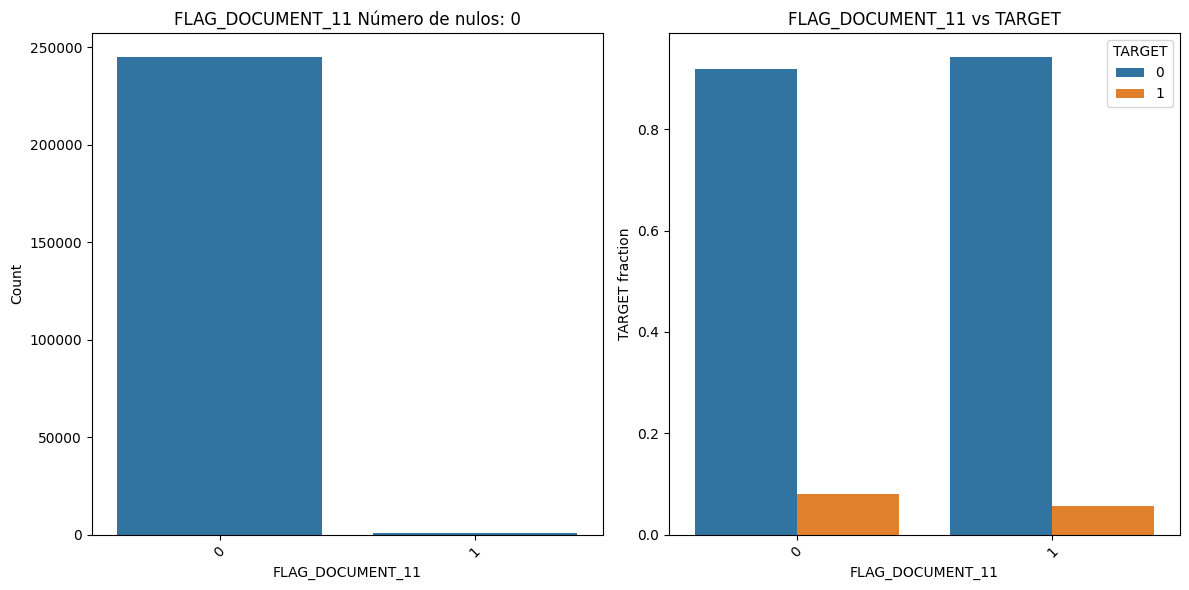

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



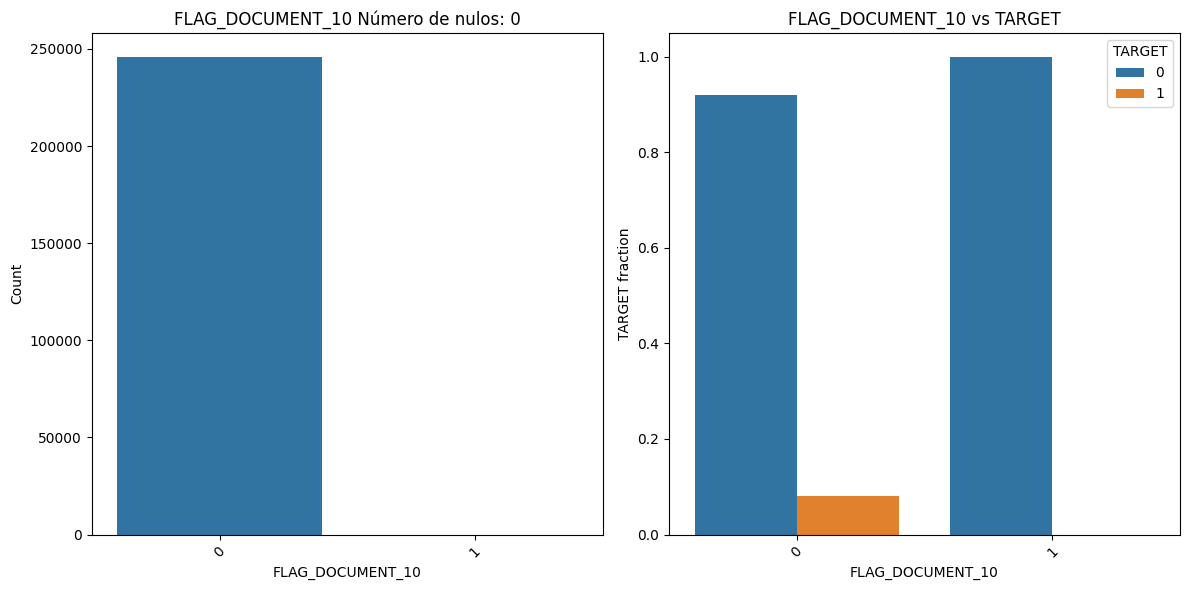

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



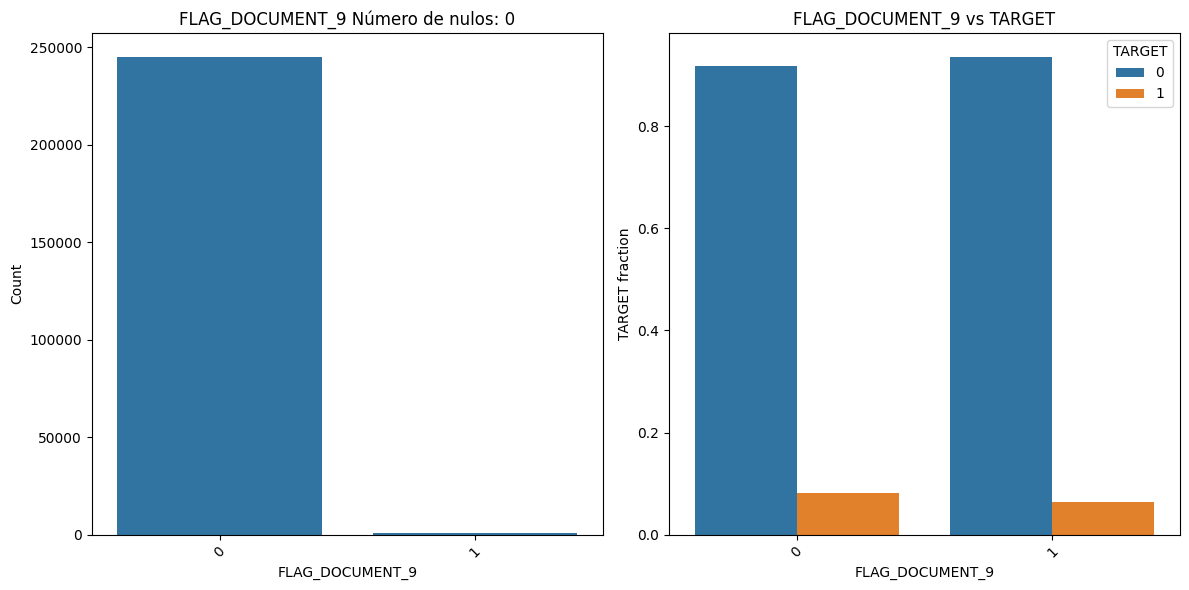

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



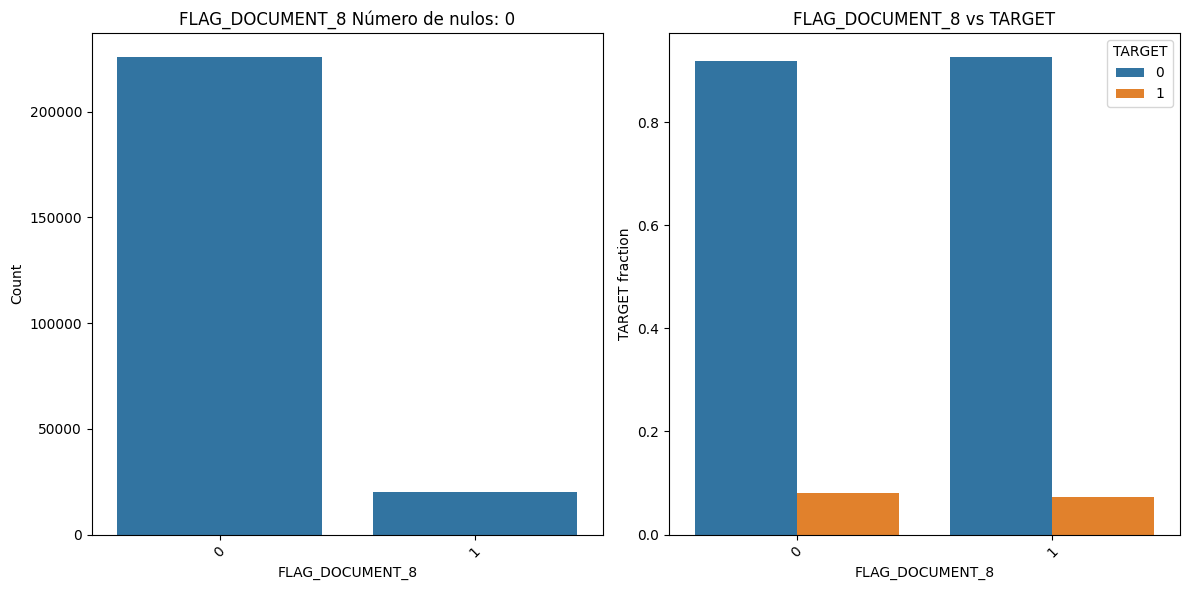

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



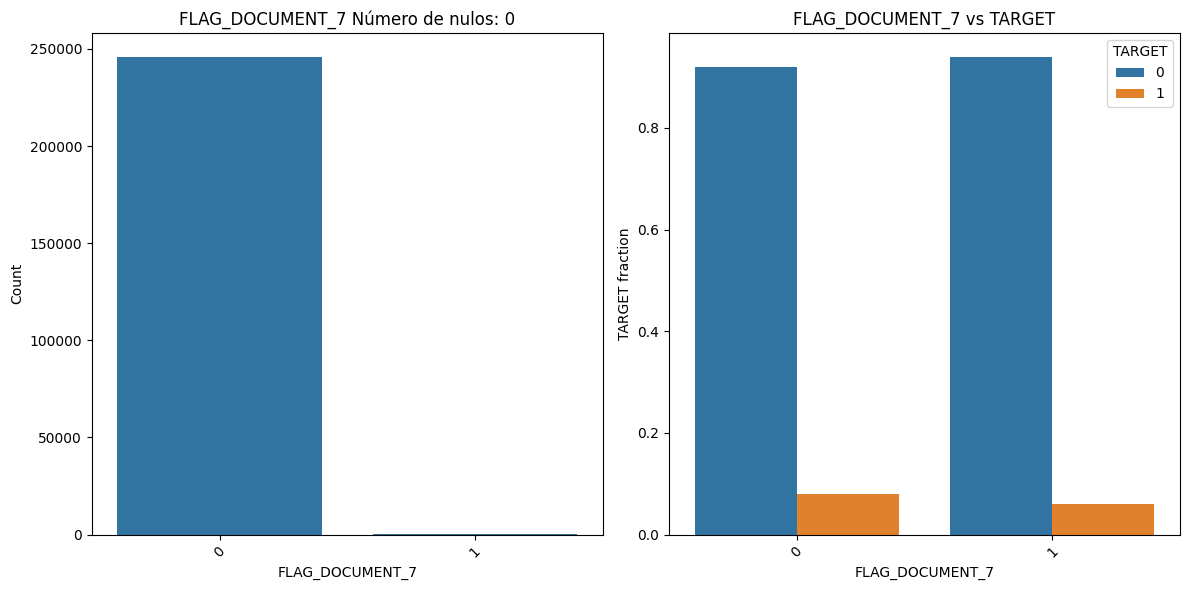

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



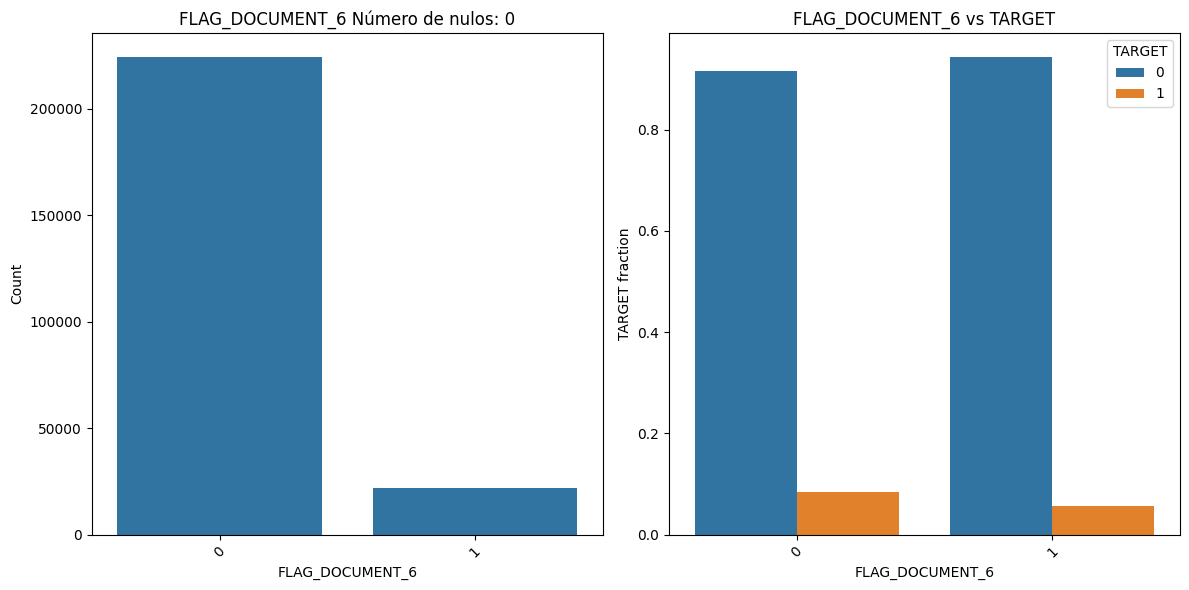

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



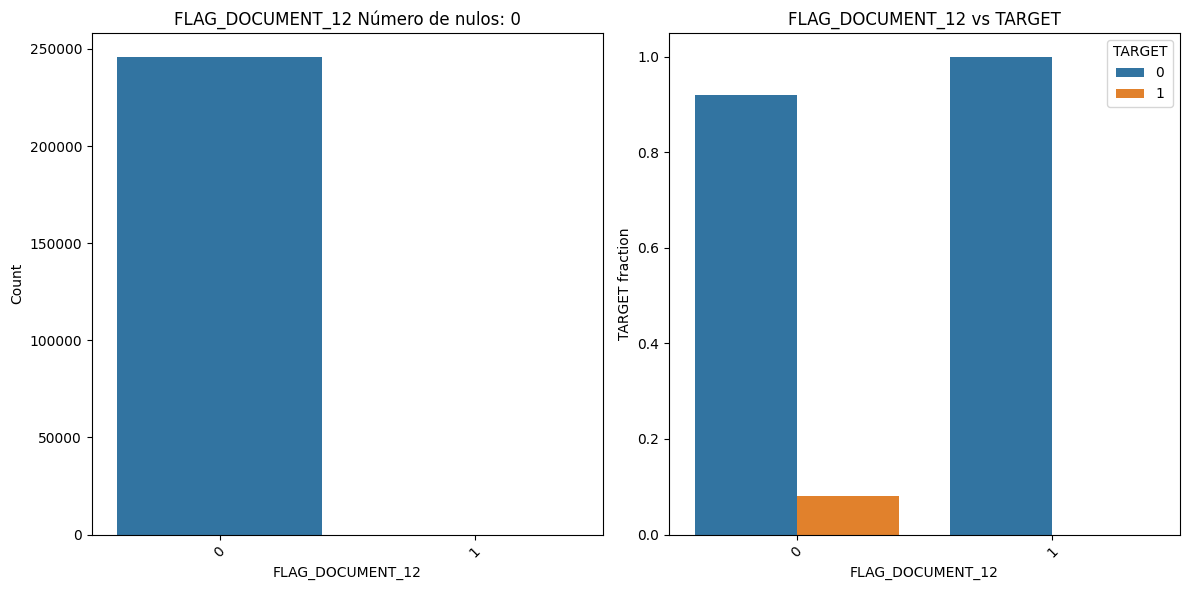

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



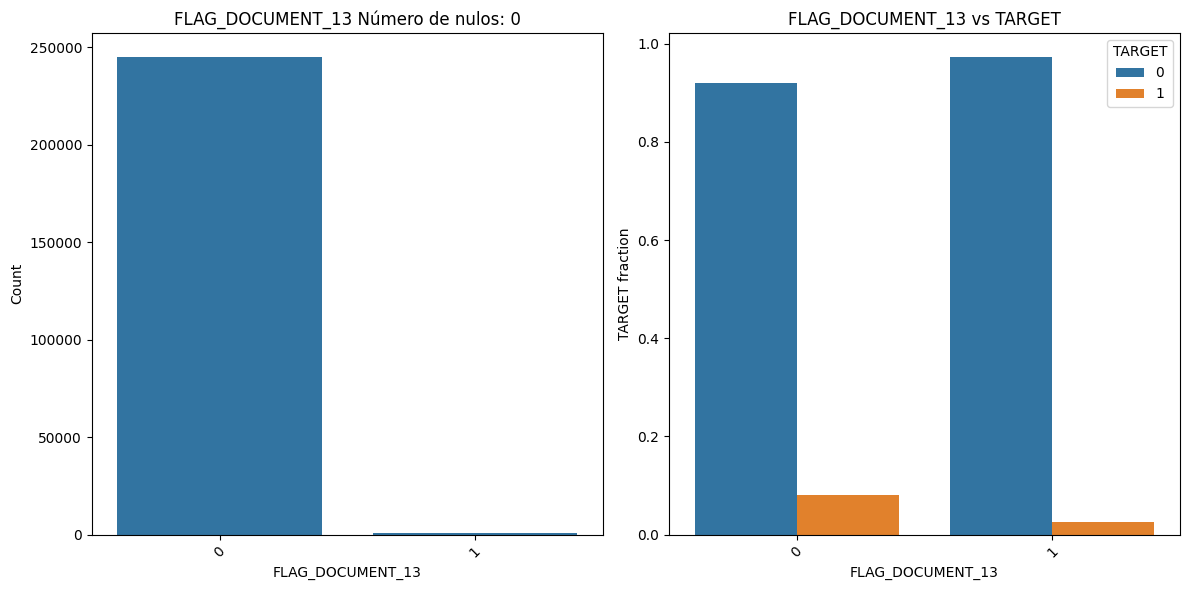

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



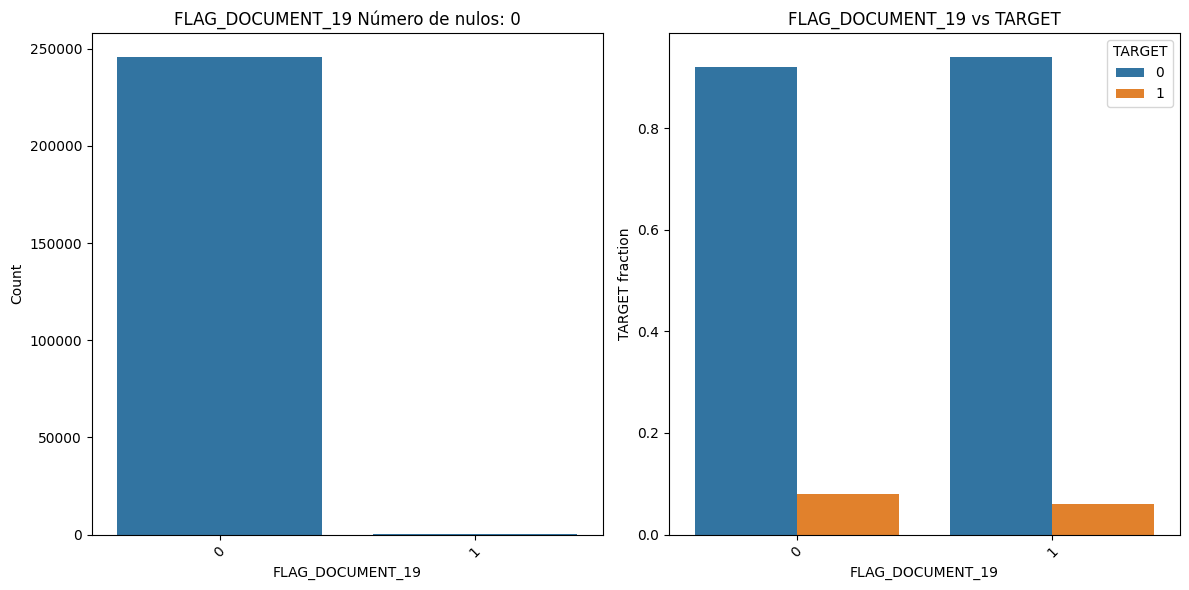

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



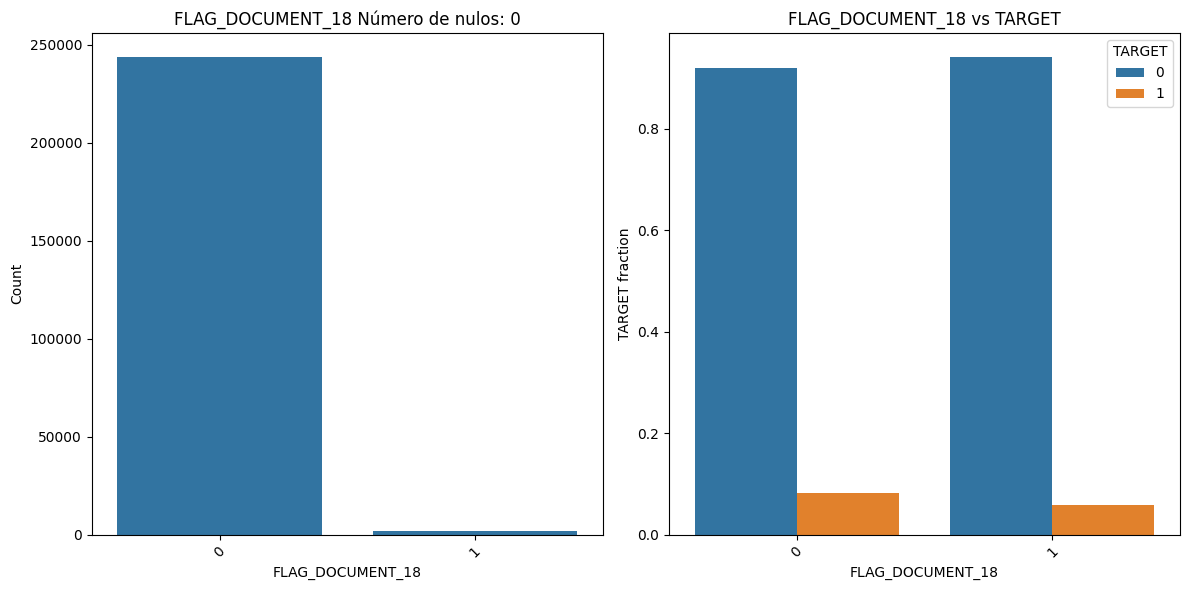

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



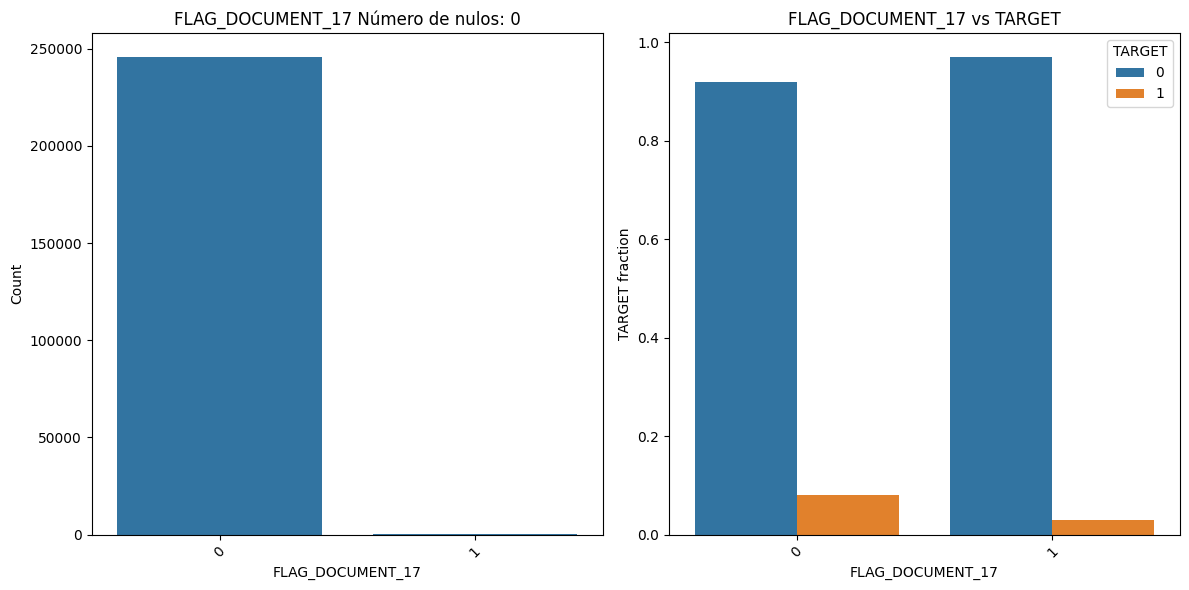

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



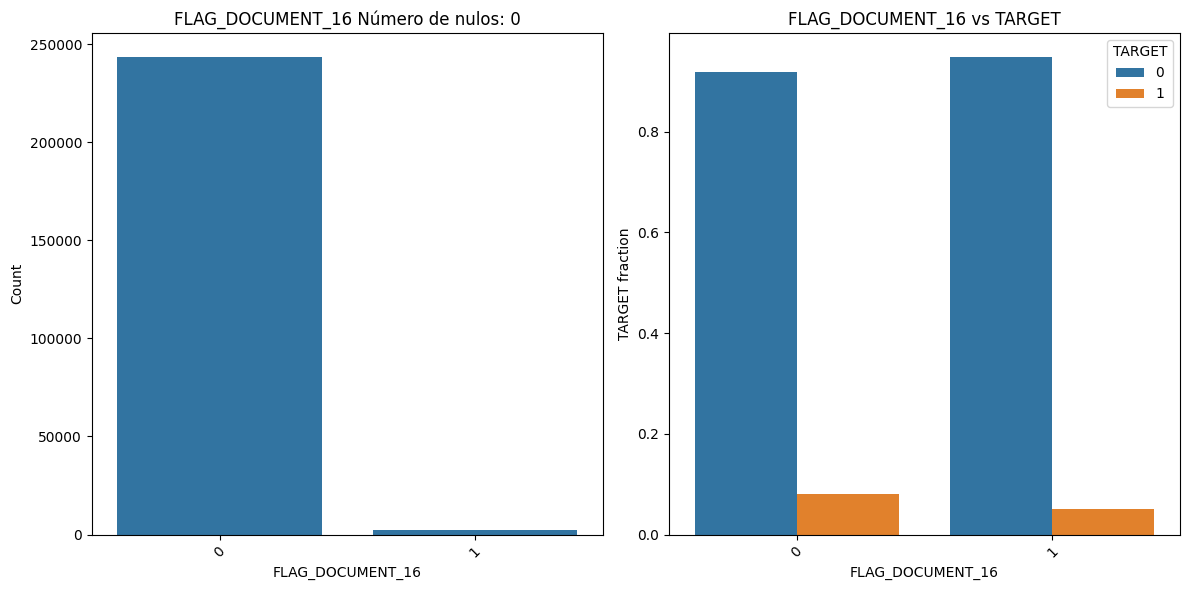

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



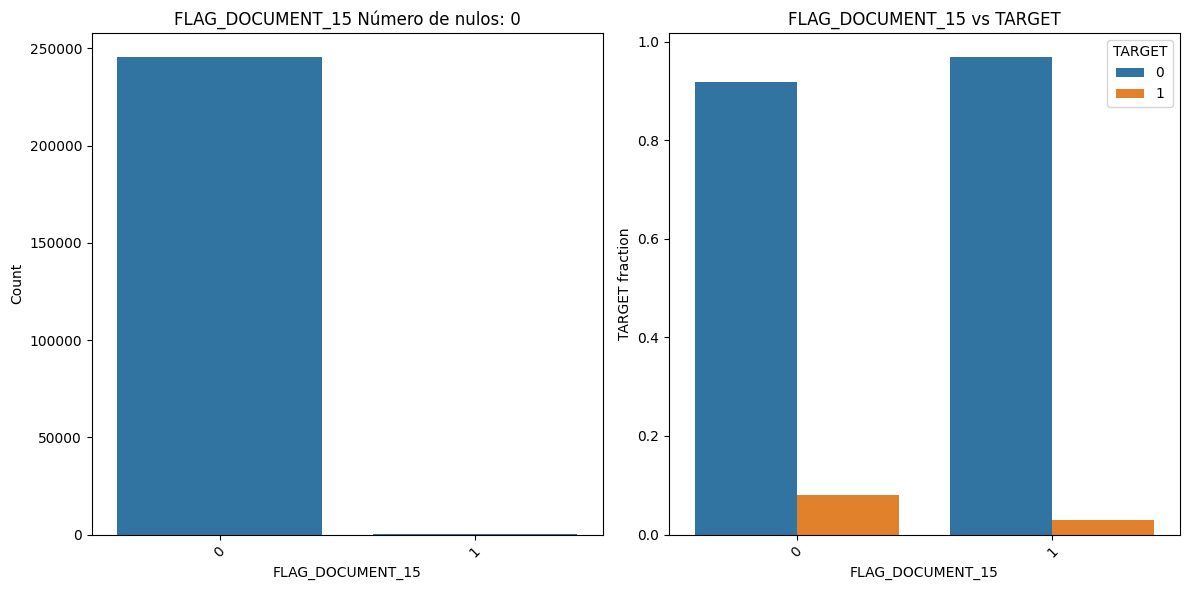

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



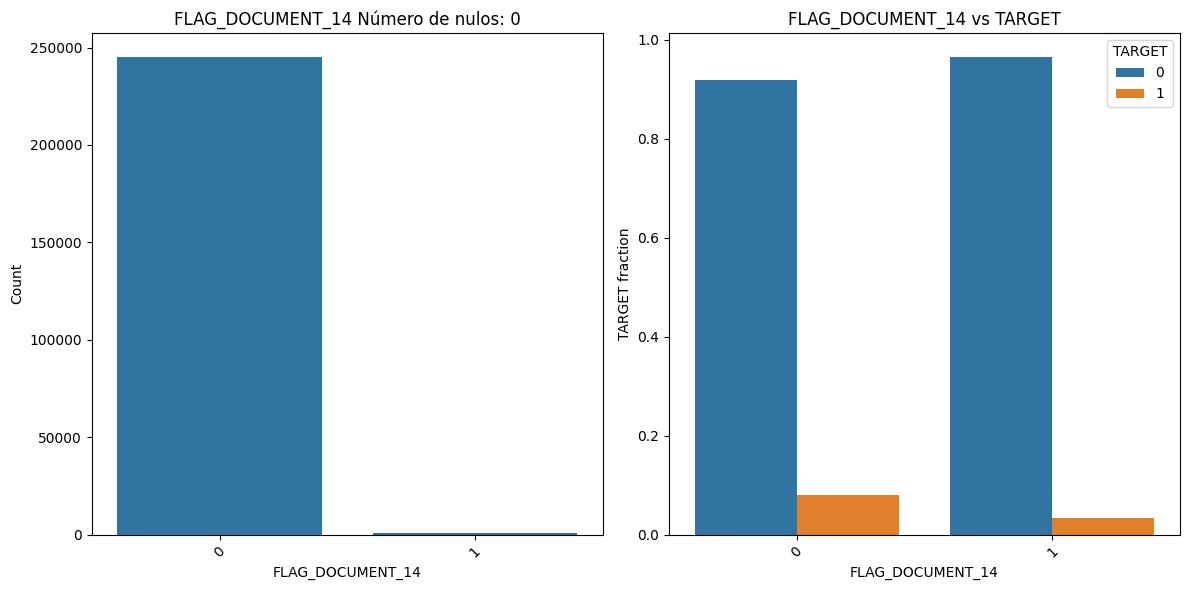

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



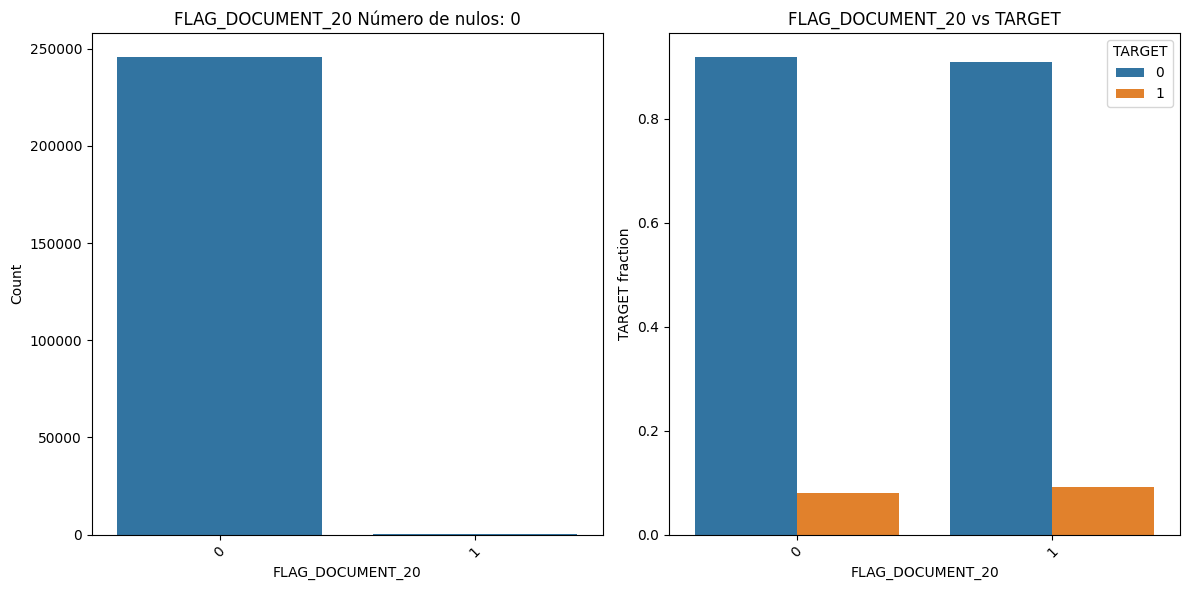

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



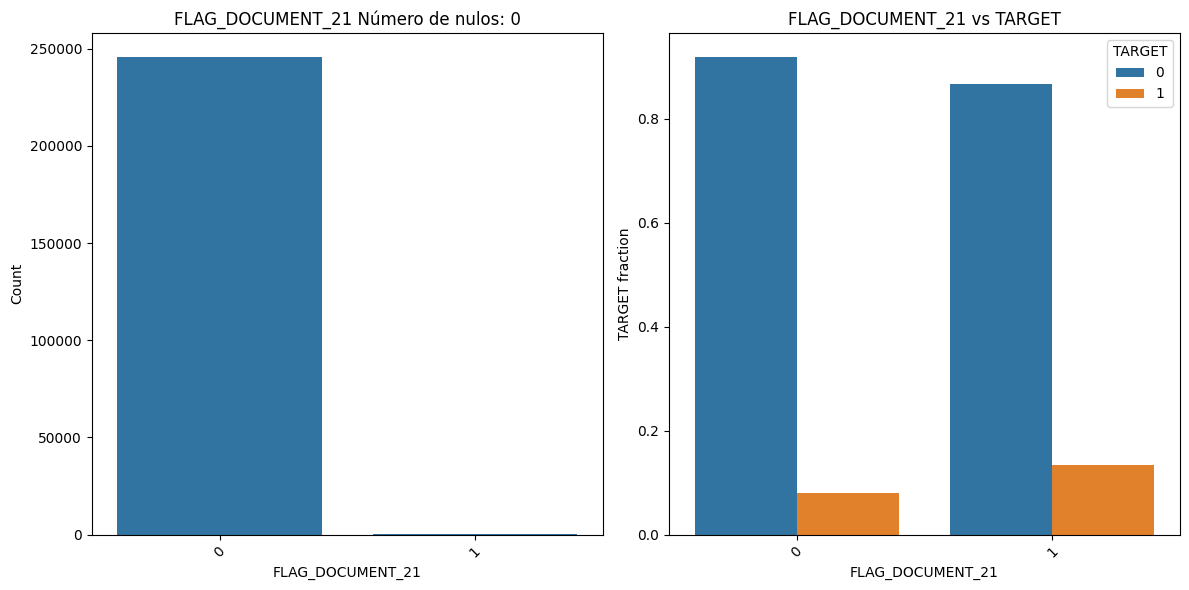

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sara\AppData\Local\Temp\ipykernel_19316\1351463941.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



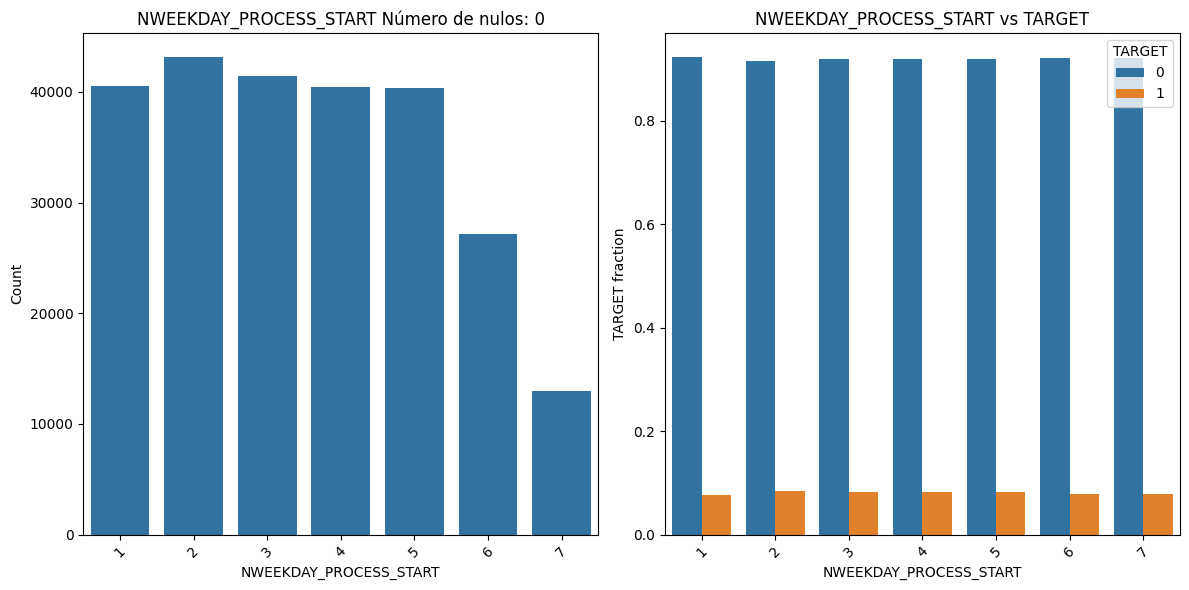

In [14]:
#Realizamos un bucle para las variables categóricas

for variable in list_var_cat:
    if variable != "TARGET":
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Gráfico de conteo
        sns.countplot(data=pd_loan_train, x=variable, ax=axes[0])
        axes[0].set_title(f'{variable} Número de nulos: {pd_loan_train[variable].isna().sum()}')
        axes[0].set_ylabel('Count')

        # Rotar etiquetas del eje X
        axes[0].tick_params(axis='x', rotation=45)

        # Para cada categoría: gráfico de fracciones
        pd_loan_df = pd_loan_train.groupby([variable, 'TARGET']).size().reset_index(name='count')
        pd_loan_df['fraction'] = pd_loan_df['count'] / pd_loan_df.groupby(variable)['count'].transform('sum')

        sns.barplot(data=pd_loan_df, x=variable, y='fraction', hue='TARGET', ax=axes[1])
        axes[1].set_title(f'{variable} vs TARGET')
        axes[1].set_ylabel('TARGET fraction')

        # Rotar etiquetas del eje X
        axes[1].tick_params(axis='x', rotation=45)

        # Ajustar diseño
        plt.tight_layout()
        plt.show()

A partir de estos gráficos, podemos ver a la izquierda el número de valores nulos para cada categoría de las variables, y en el de la derecha, cómo se distribuye una variable en función de la variable TARGET. Por lo general, vemos que los datos están bastante desbalanceados, pues hay muchas variables que no vemos que tengan un impacto fuerte en el impago del préstamo. A continuación, vamos a comentar algunas variables que puedan ser significativas en el impago del préstamo.

NAME_INCOME_TYPE (Situación laboral del solicitante)
En el gráfico de la izquierda vemos que la mayoría de los datos se asocian con 'Working', es decir, personas que tienen un empleo. Otras categorías presentan también una parte de los datos, como 'Pensioner' o 'Commercial Associate'. Otras categorías como 'Student' o 'Unemployed' presentan muy poca distribución de los datos, o ninguna. En el gráfico de la derecha, que muestra la fracción de incumplimiento para cada categoría, vemos que las personas desempleadas o las que están de baja por maternidad, tienen un porcentaje alto de incumplimiento. Los desempleados parece lógico, pues se asocia con la falta de un trabajo estable. Otras categorías como los pensionistas o los trabajadores presentan un grado bajo de incumplimiento, pues están asociados con un salario o pensión.

NAME_EDUCATION_TYPE(Nivel de educación)
En el gráfico de la izquierda vemos que los datos se distribuyen sobre todo en clientes que tienen 'Secondary/Secondary Special', seguidos de 'Higher Education'. 'Academid degree' o 'Lower Secundary' son menos comunes.En el gráfico de la derecha se muestra las fracciones de incumplimiento para cada nivel educativo. Como vemos, secundaria, secundaria especial o secundaria baja son los niveles que más probabilidad de incumplimiento tienen, algo que puede estar relacionado por el tipo de empleo que estos clientes tienen, asociado con la baja formación académica recibida. Los clientes con un grado o educación superior presentan menor riesgo de incumplimiento, algo que también puede estar relacionado por el caso contrario al anterior.Podemos concluir que el nivel educativo influye en la capacidad de incumplimiento del solicitante.

NAME_HOUSING_TYPE(Tipo de vivienda)
En el gráfico de la izquierda vemos que la mayoría de los datos se asocian con clientes que vivene un apartameto o casa, que por otra parte es lo más normal. Otras categorías presentan una distribución de los datos mucho menor, como 'Municipal Apartment', 'With Parents' o 'Rented Apartment'. En cuanto a su relación con TARGET, vemos que la fracción de incumplimineto es algo mayor para aquellos solicitantes que viven con los padres o de alquiler. Esto puede estar relacionado con un menor grado de cumplimineto, pues los que viven con sus padres es posible que no tengan una ocupación, aunque también pueden ser aún jóvenes para independizarse. Aun así, no parece una variable muy significativa en cuanto al grado de incumplimiento del préstamo.

OCCUPATYON_TYPE (Tipo de trabajo)
Al observar la variable, vemos que presenta una buena cantidad de nulos que podríamos imputar para mejorar el análisis. En el gráfico de la izquierda, vemos que la mayoría de los solicitantes pertenecen a 'Laborers'(en mayor proporción), 'Core Staff' y 'Sales Staff'. Como vemos en el gráfico de la derecha, los trabajadores dedicados a actividades manuales o físicas como la construcción, fabricación, agaricultura, así como aquellos con una baja especialización, como por ejemplo, ayudante de obra, presentan mayor incumplimineto de devolver el préstamo. Otros gremios, como los conductores o los vigilantes de seguridad presentan un grado de incumplimiento menor, aunque mayor que el resto. Esto puede estar debido a la formación educativa, ya que estos trabajos no requieren de una cualificación para dedicarse a ellos. Podemos concluir que el tipo de ocupación puede influir en el grado de incumplimiento del préstamo.

CODE_GENDER(Género)
Como vemos en el gráfico de la izquierda, hay mayor proporción de clientes femeninos que masculinos.En el gráfico de la derecha no parece haber una diferencia extremadamente significativa entre el grado de incumplimineto de hombres y mujeres, aunque si nos fijamos el grado de incumplimiento mayor es ligeramente masculino. Esto puede deberse a muchas razones como el tipo de trabajo, mentalidad o tipo de educación, entre otras. En conclusión, esta variable tiene una relación moderada con la probabilidad de incumplkimiento, siendo importante considerar cómoa actúa con otras variables.

NAME_CONTRACT_TYPE (Tipo de contrato)
En el gráfico de la izquierda vemos que la mayoría de los préstamos pertenecen a 'Cash Loans', mientras que los 'Revolving Loans' tienen una proproción mucho menor. Con respecto a la variable TARGET, vemos que no hay una gran diferencia en la probabilidad de incumplimiento entre ambos préstamos, pero sí que es verdad que los 'Cash Loans' tienen una probabilidad mayor, cosa que tiene sentido al ser mucho más comunes en el día a día.


TRATAMIENTO DE VARIABLES CONTINUAS

A continuación se tratarán tres aspectos clave del análisis de los datos: los valores missing, los outliers y las correlaciones entre las variables continuas

In [15]:
list_var_continuous

['COMMONAREA_AVG',
 'COMMONAREA_MODE',
 'COMMONAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAPARTMENTS_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAPARTMENTS_MODE',
 'FLOORSMIN_MODE',
 'FLOORSMIN_AVG',
 'FLOORSMIN_MEDI',
 'YEARS_BUILD_AVG',
 'YEARS_BUILD_MODE',
 'YEARS_BUILD_MEDI',
 'OWN_CAR_AGE',
 'LANDAREA_MEDI',
 'LANDAREA_AVG',
 'LANDAREA_MODE',
 'BASEMENTAREA_MODE',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_AVG',
 'EXT_SOURCE_1',
 'NONLIVINGAREA_MODE',
 'NONLIVINGAREA_AVG',
 'NONLIVINGAREA_MEDI',
 'ELEVATORS_AVG',
 'ELEVATORS_MEDI',
 'ELEVATORS_MODE',
 'APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'APARTMENTS_MODE',
 'ENTRANCES_MODE',
 'ENTRANCES_MEDI',
 'ENTRANCES_AVG',
 'LIVINGAREA_AVG',
 'LIVINGAREA_MEDI',
 'LIVINGAREA_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMAX_AVG',
 'FLOORSMAX_MEDI',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BEGINEXPLUATATION_AVG',
 'TOTALAREA_MODE',
 'EXT_SOURCE_3',
 'AMT_REQ_CREDIT_BURE

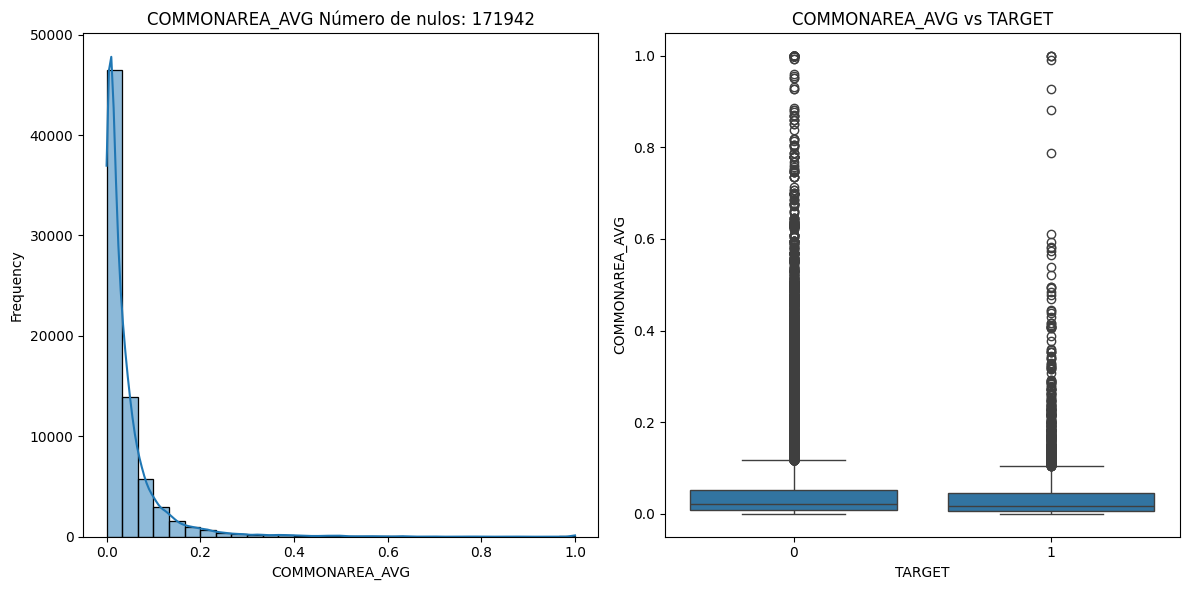

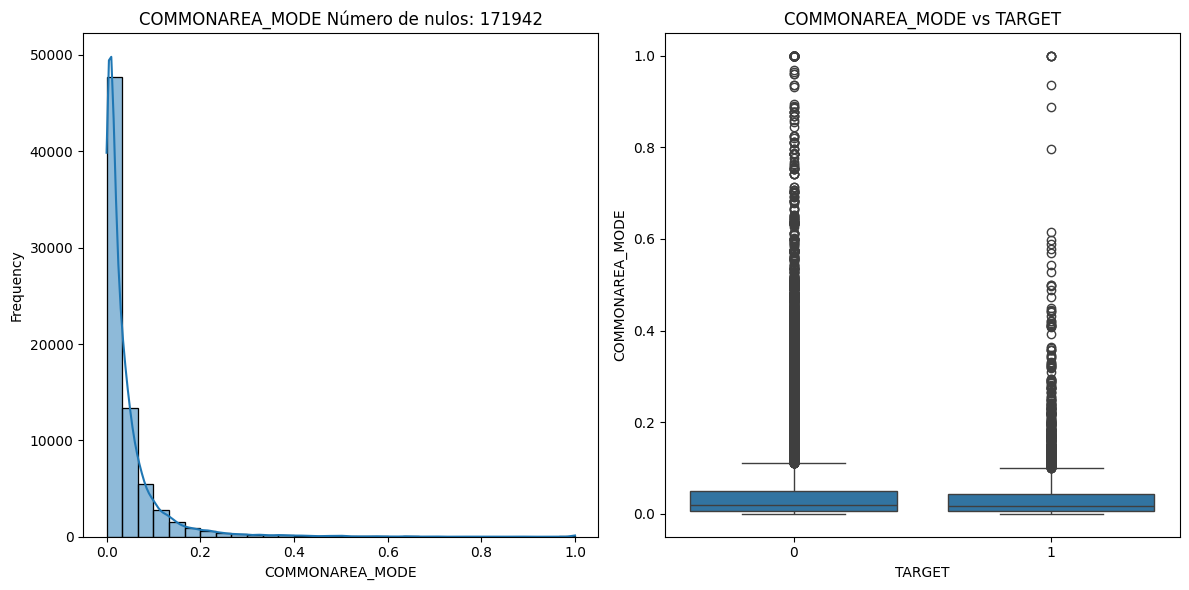

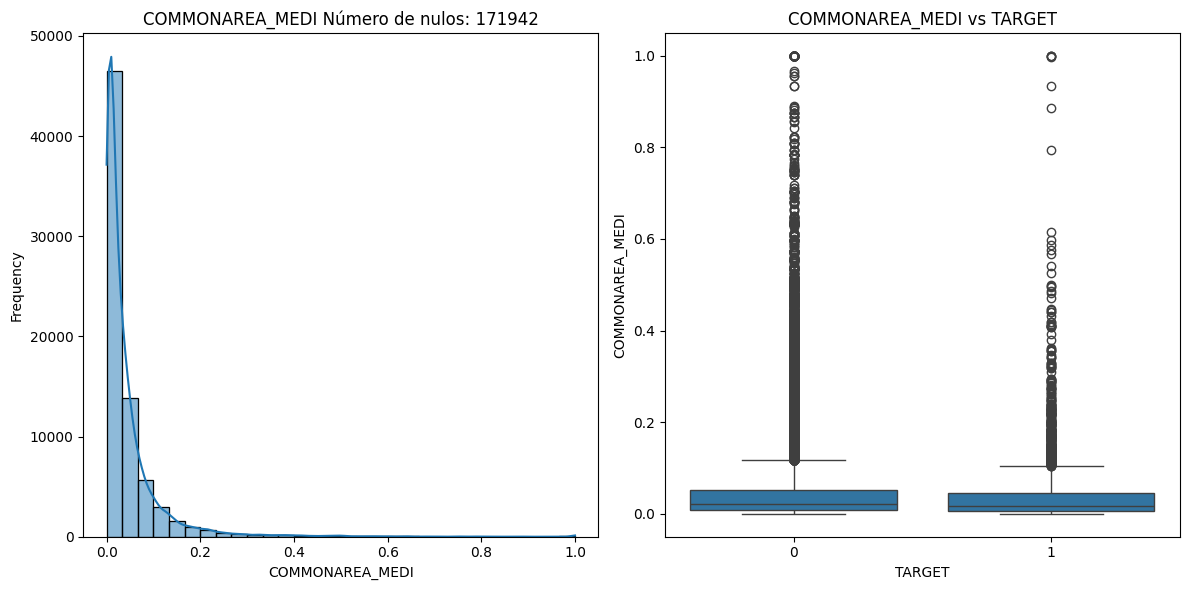

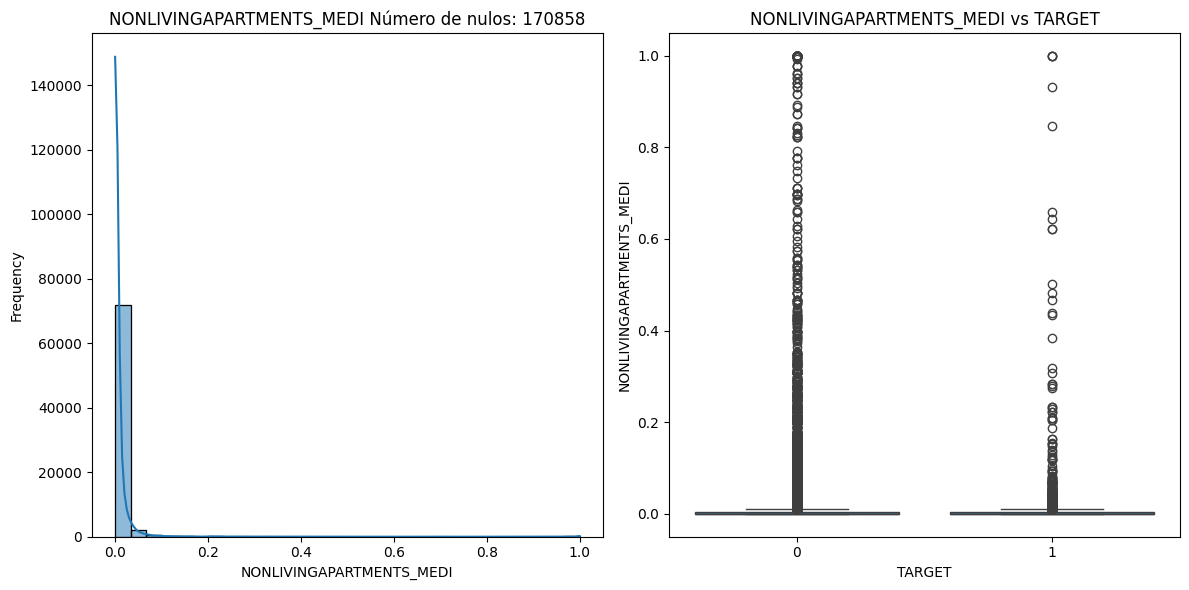

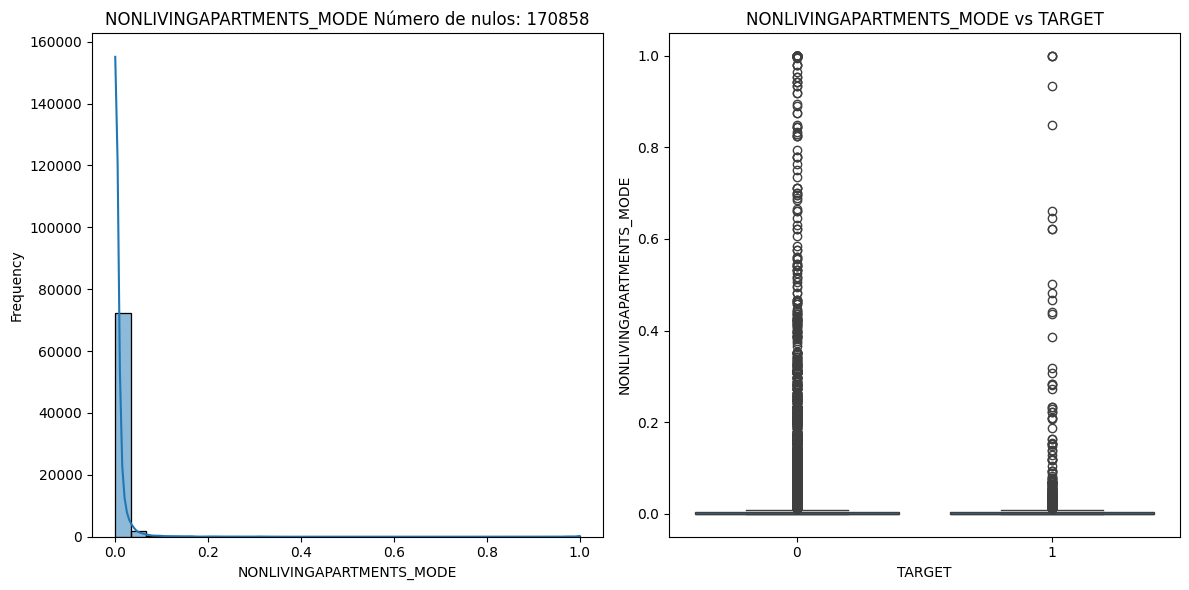

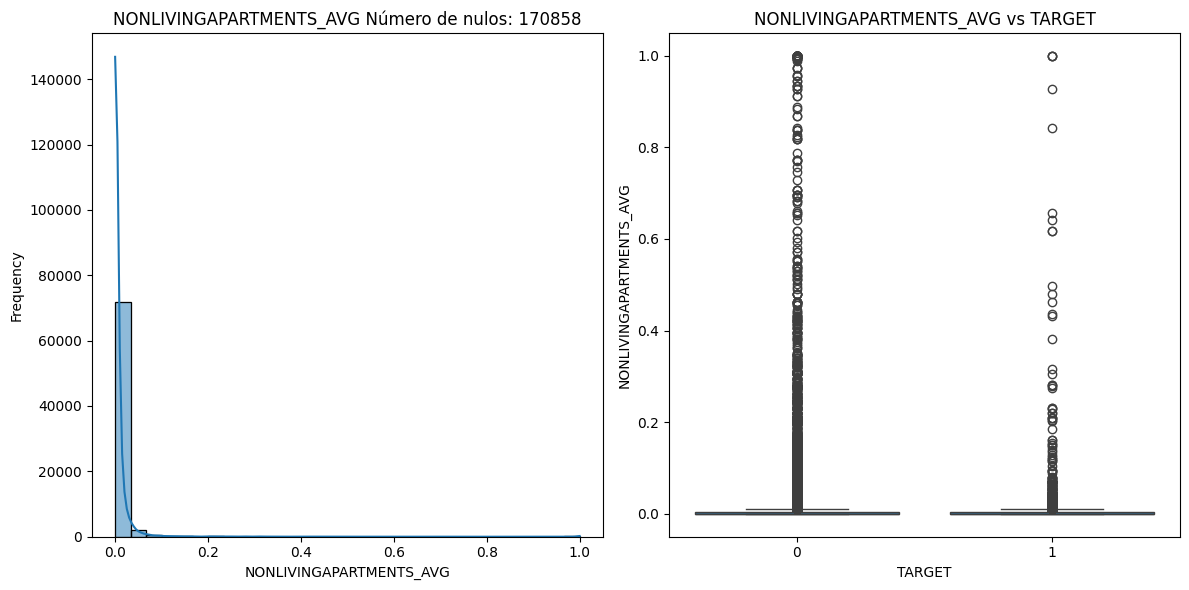

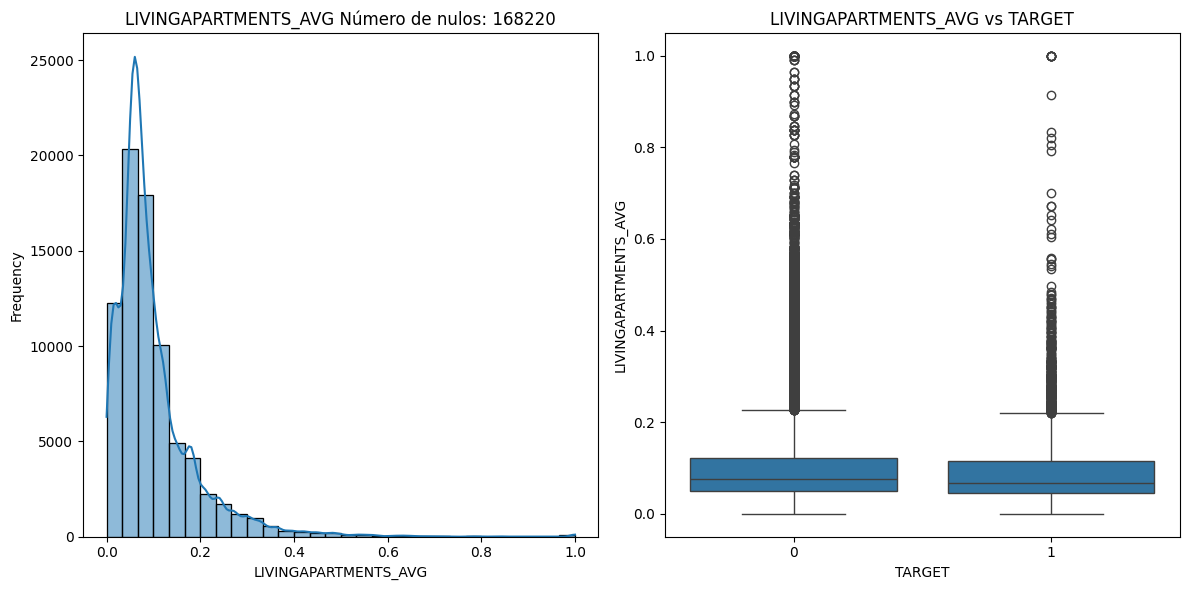

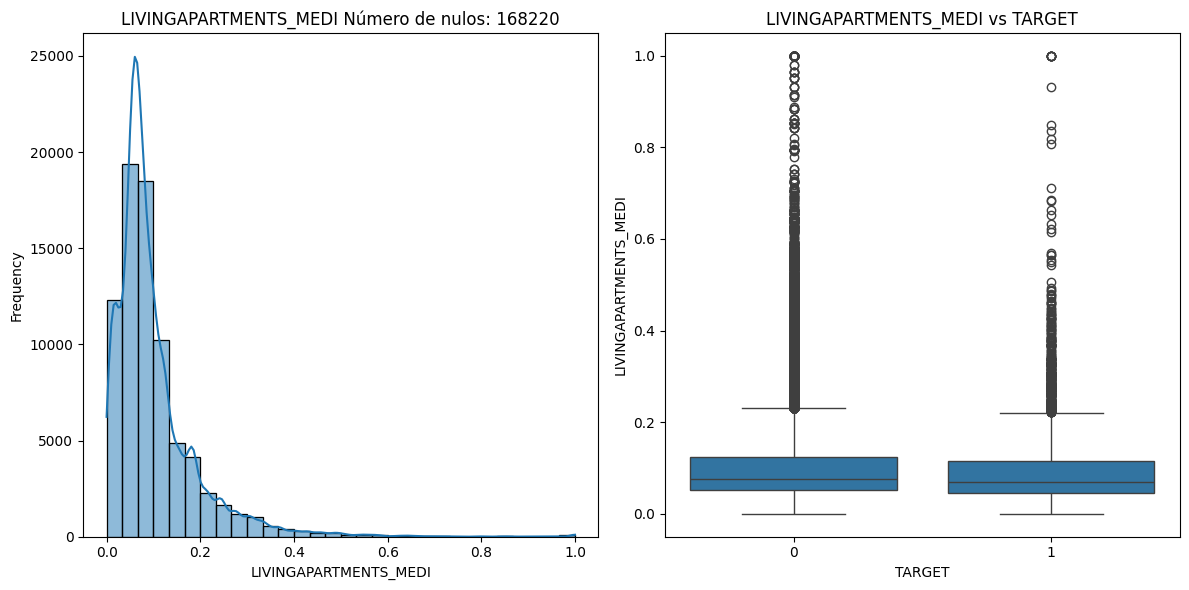

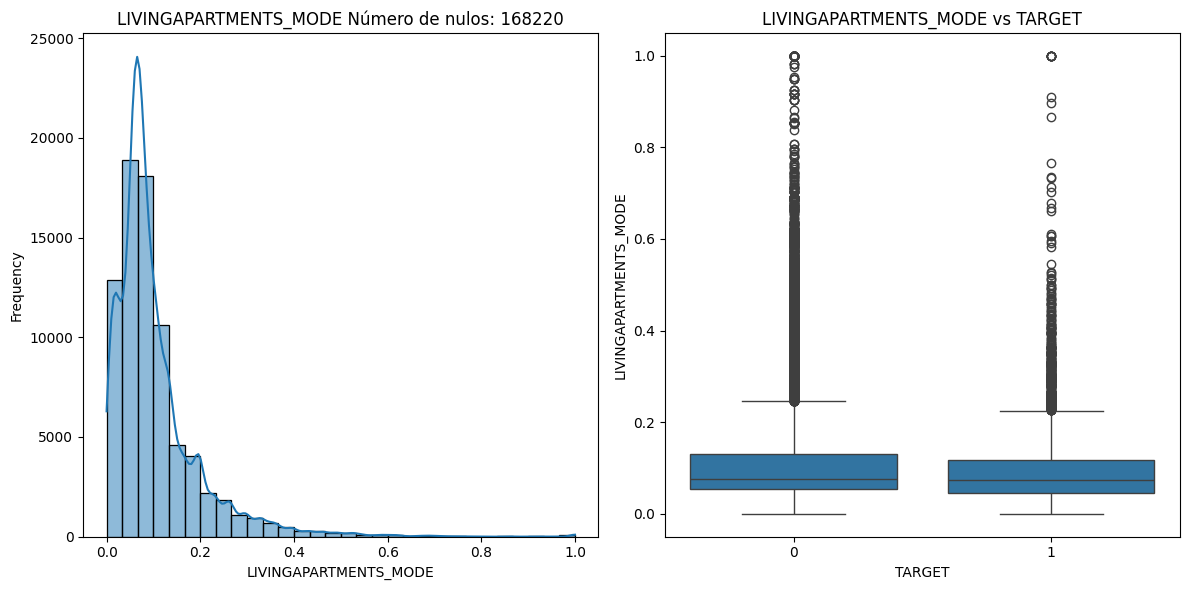

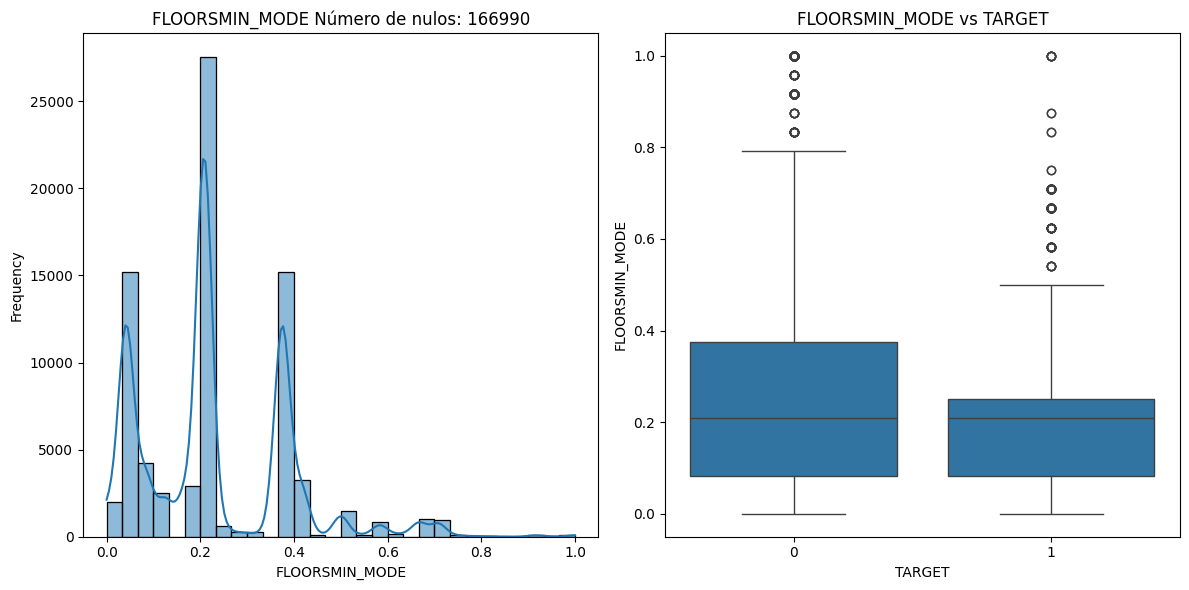

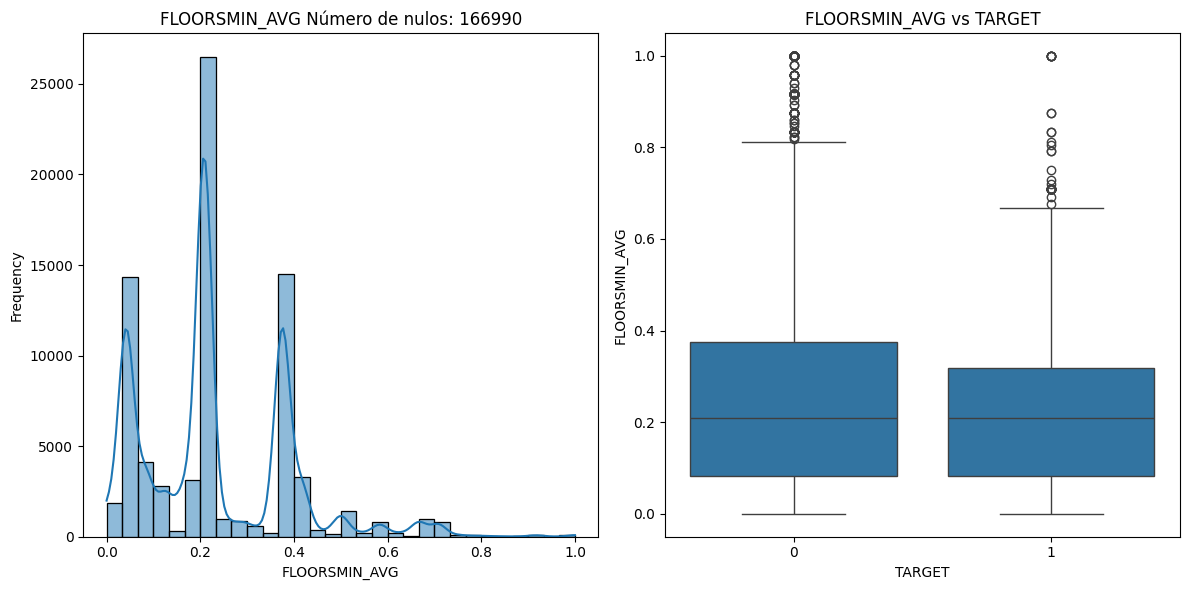

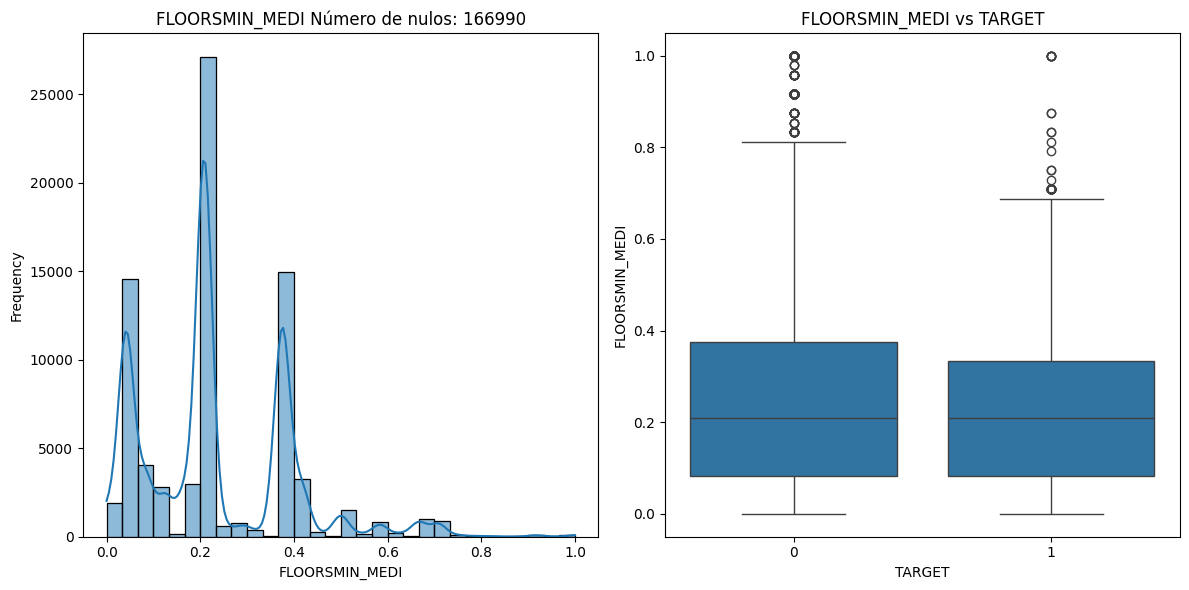

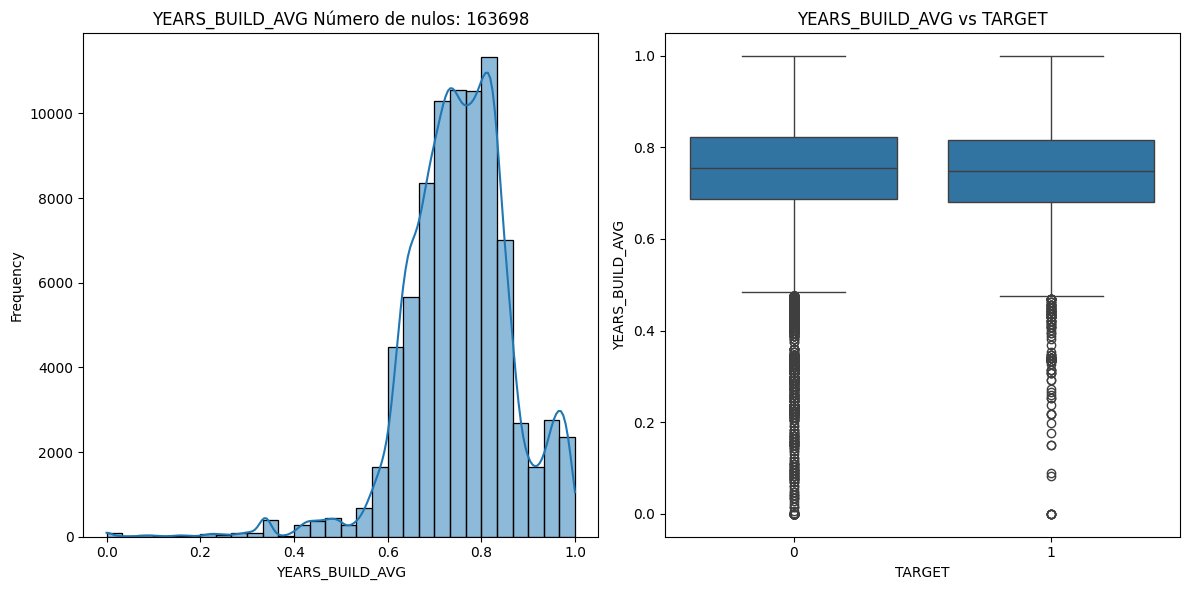

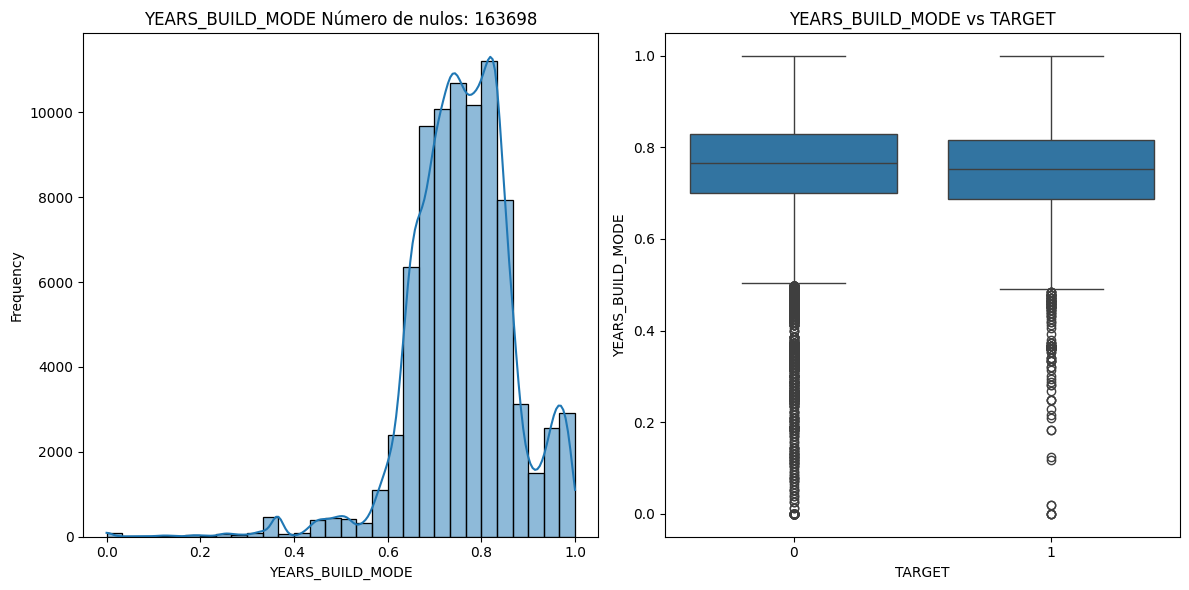

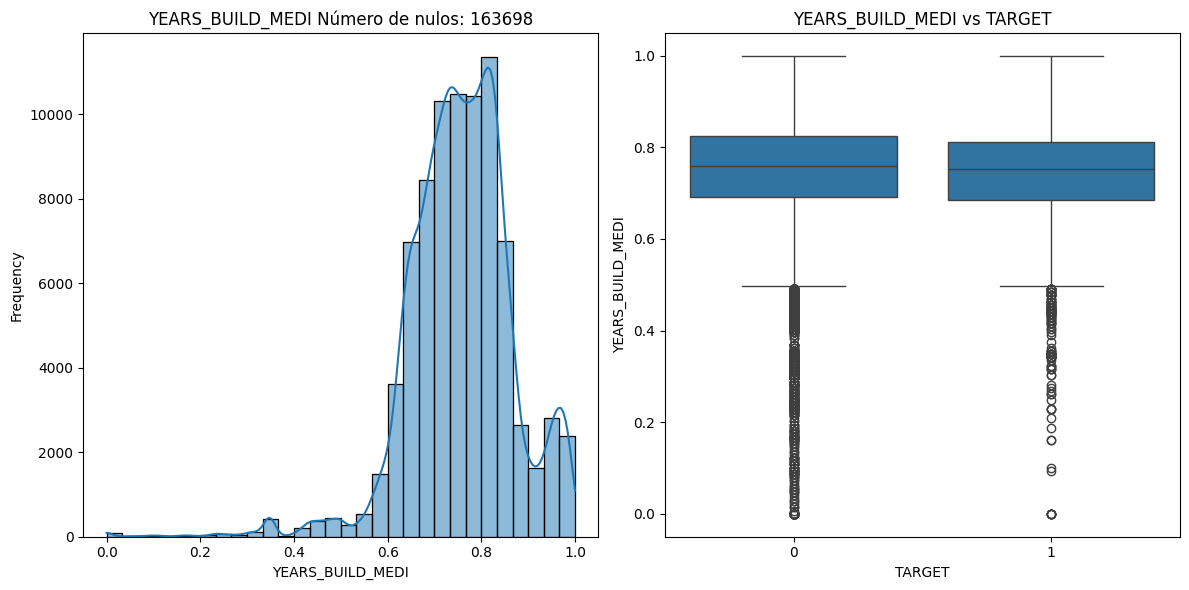

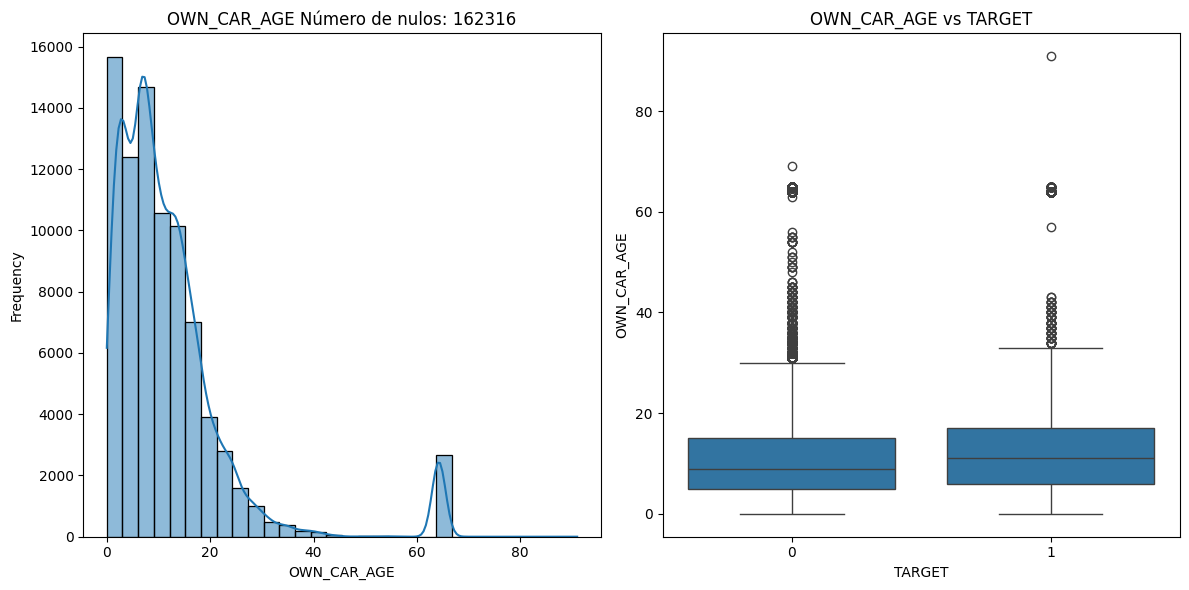

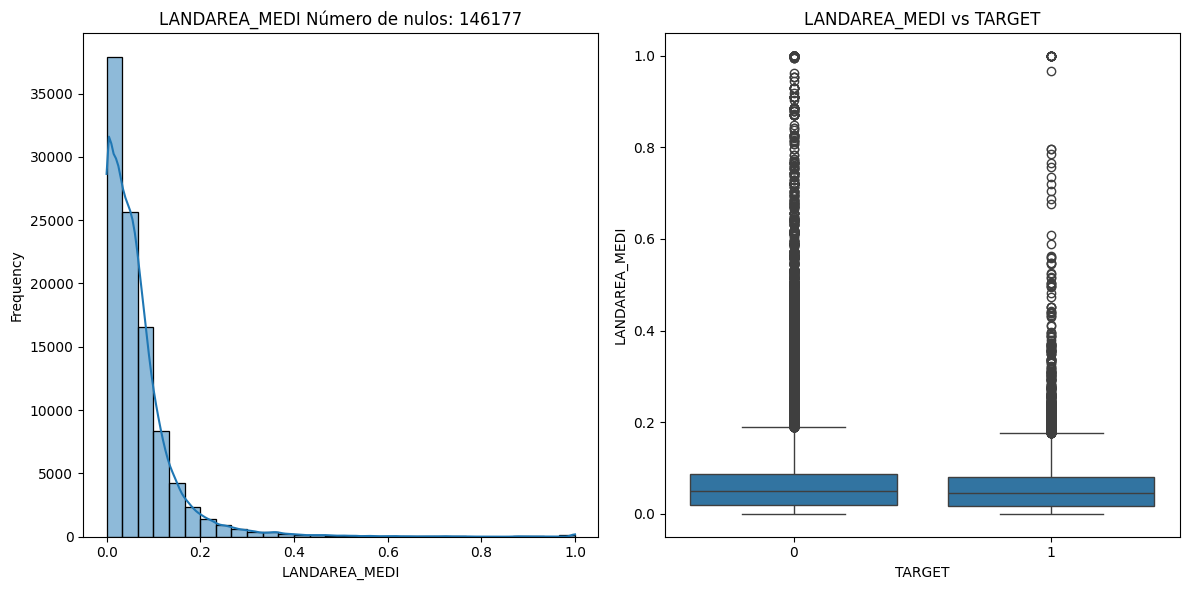

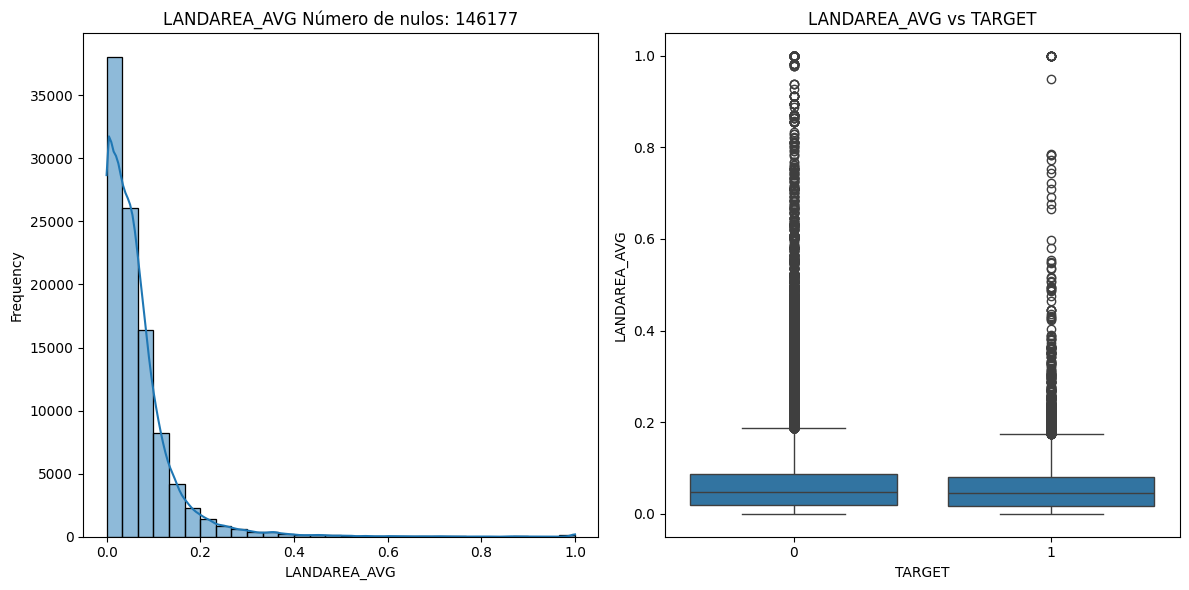

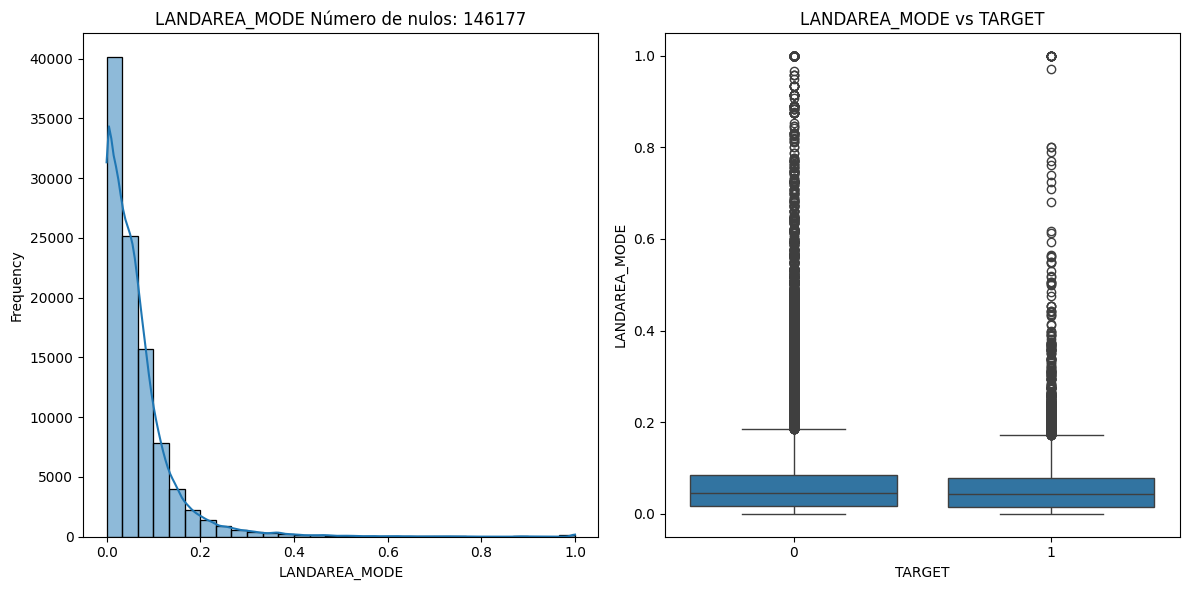

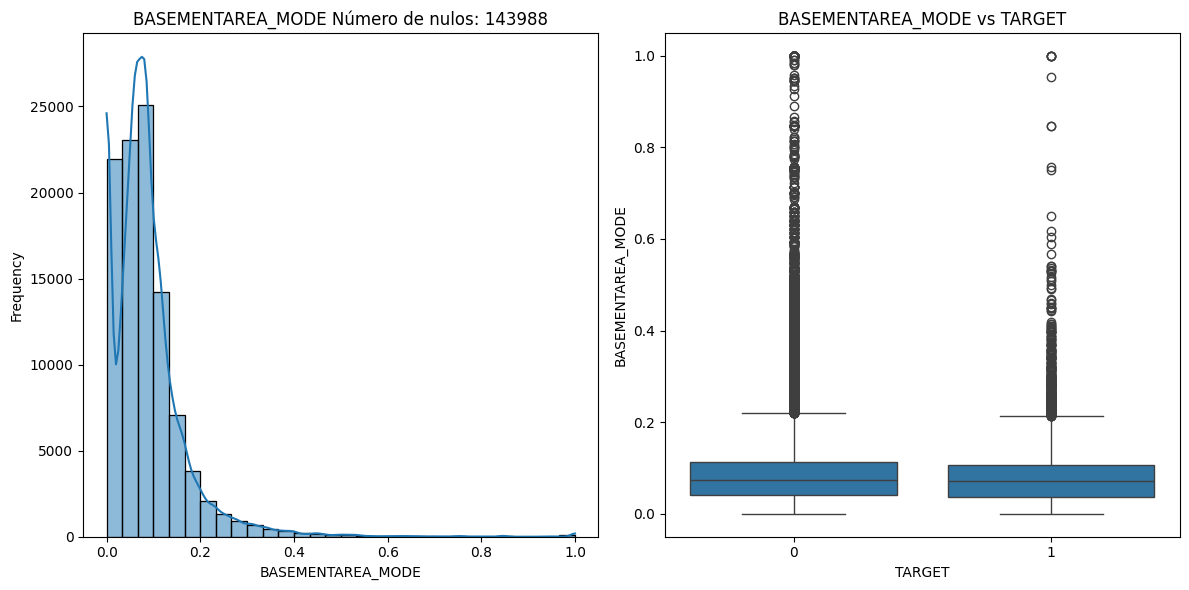

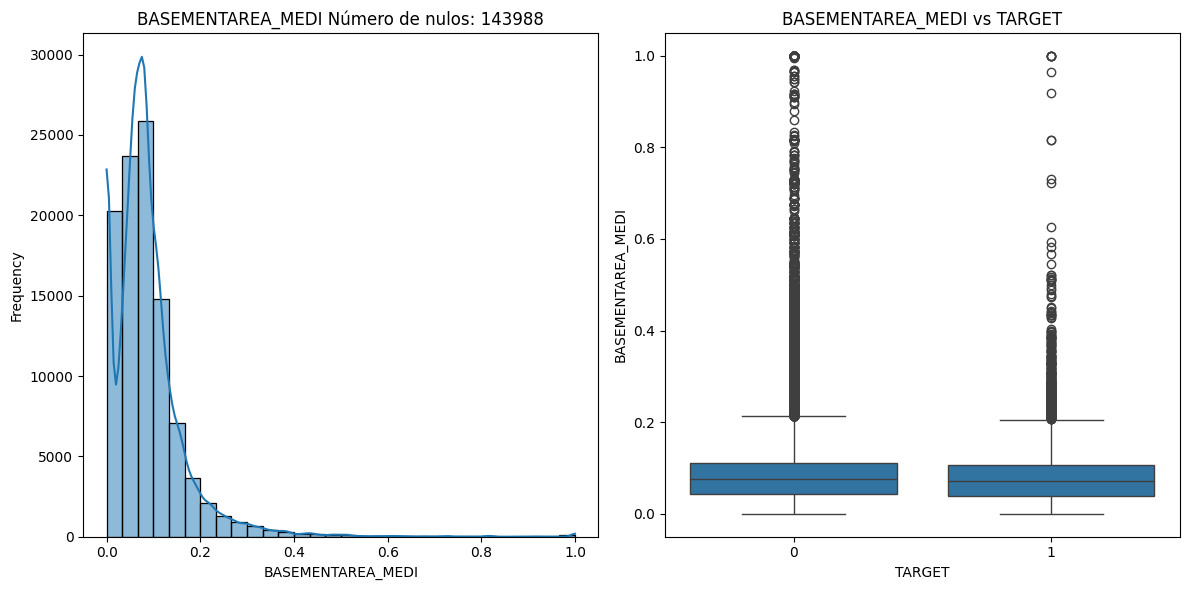

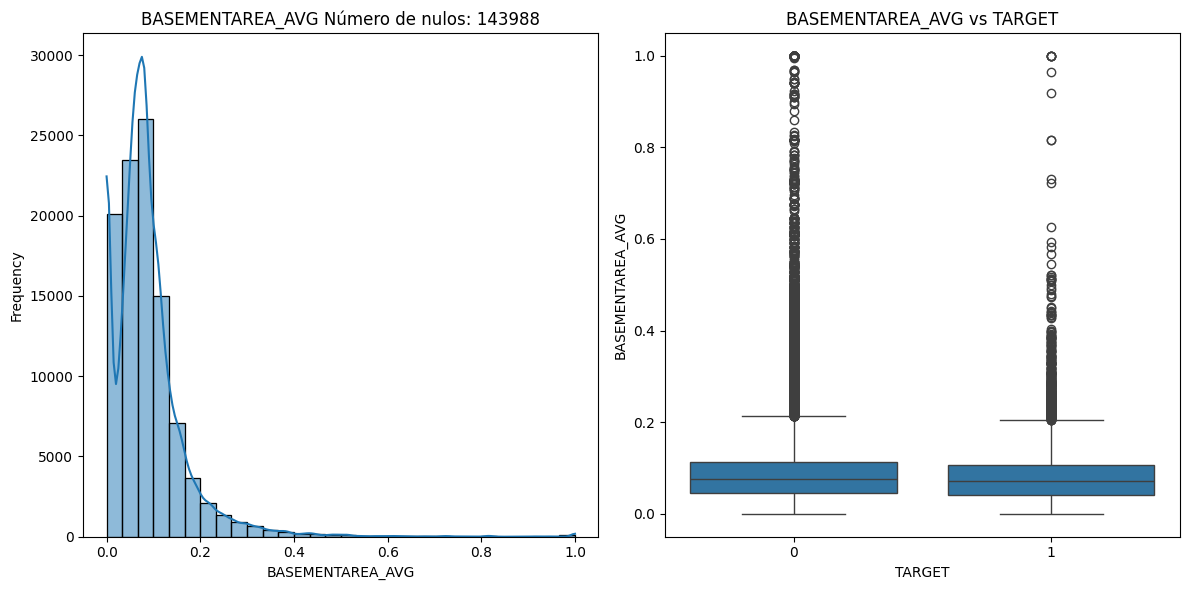

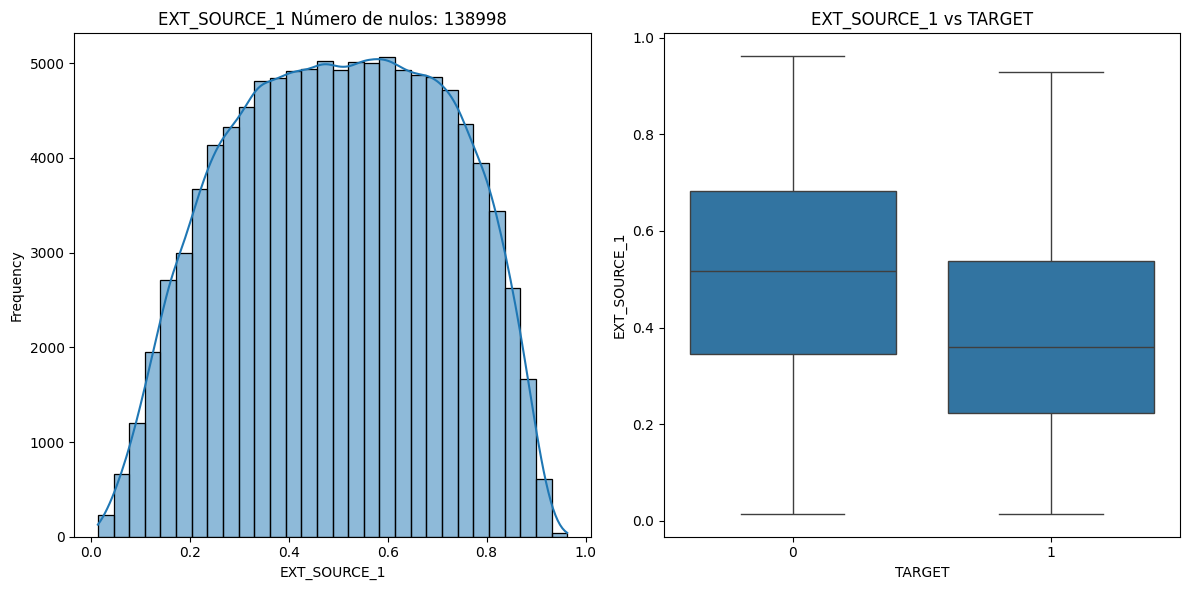

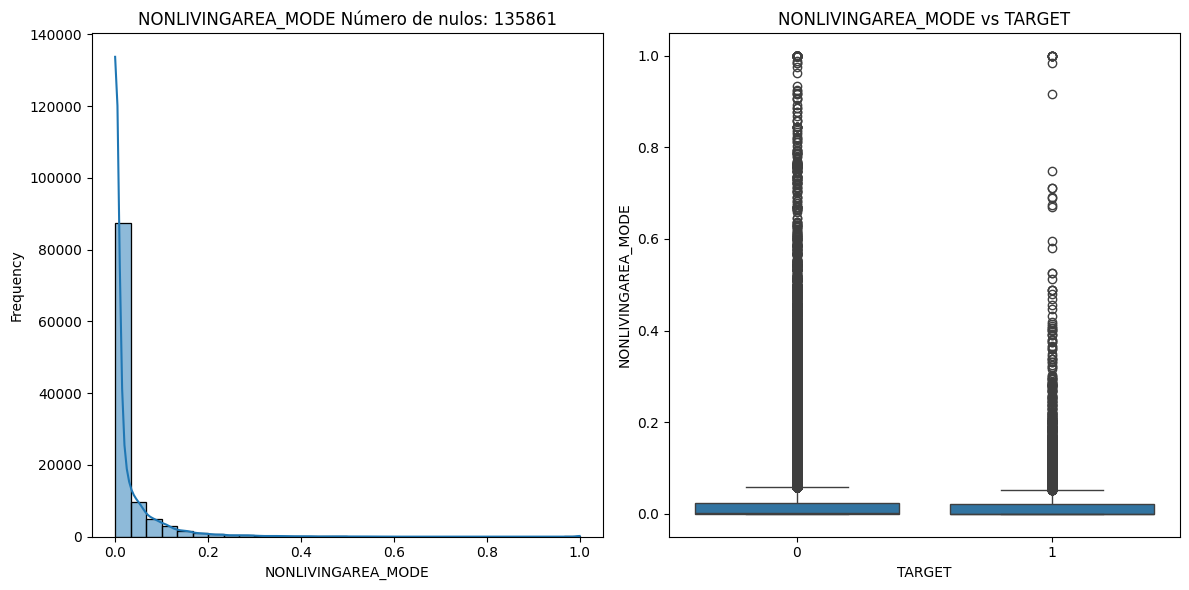

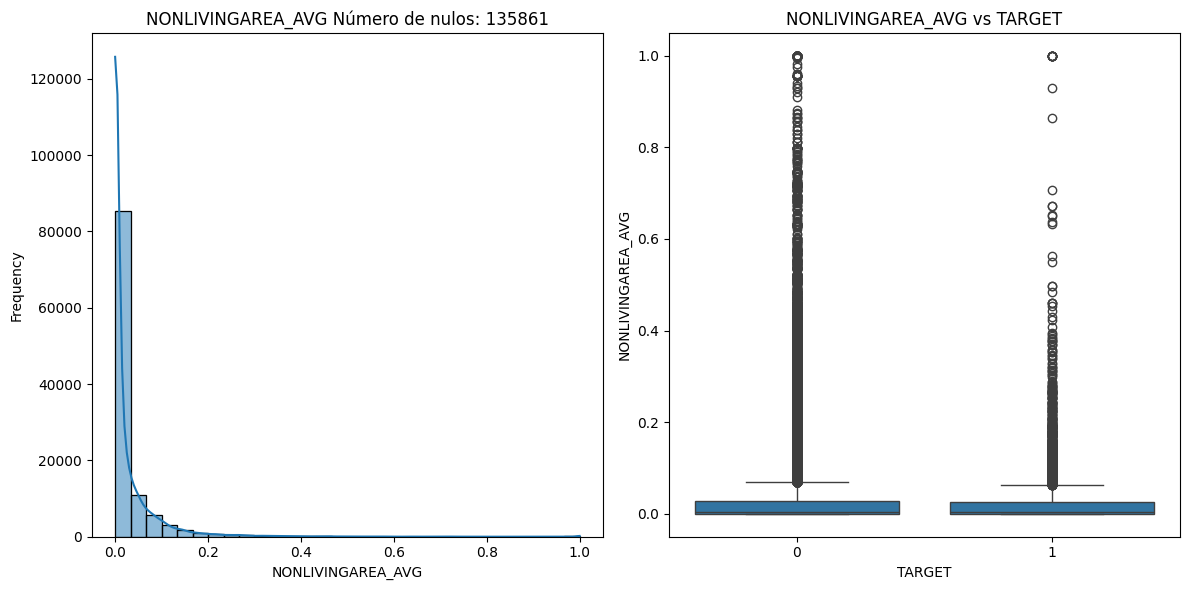

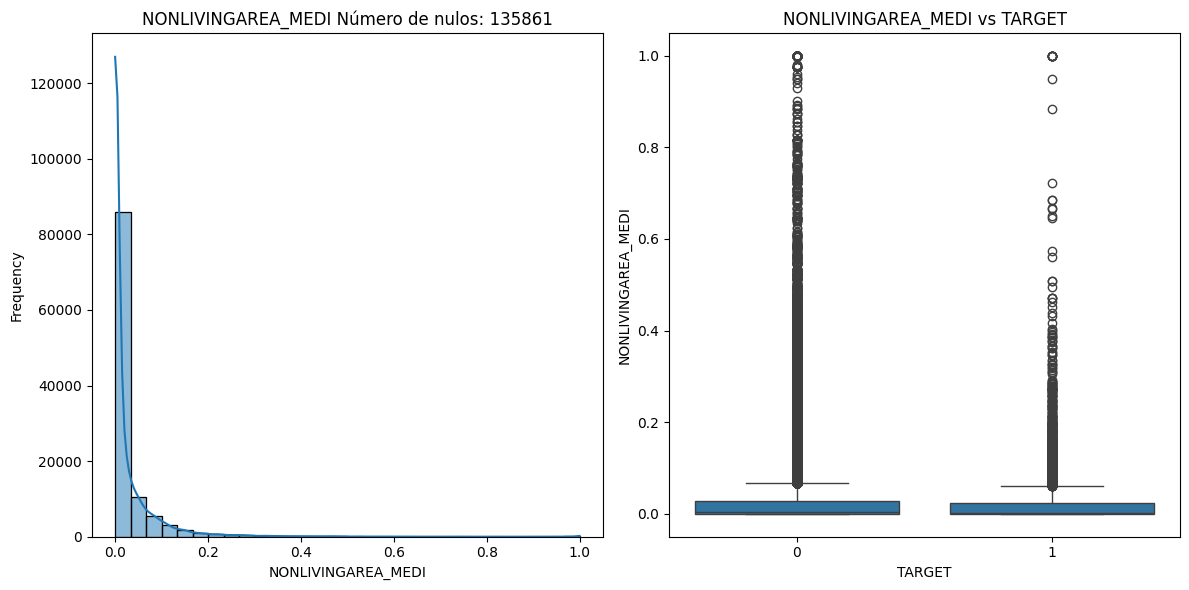

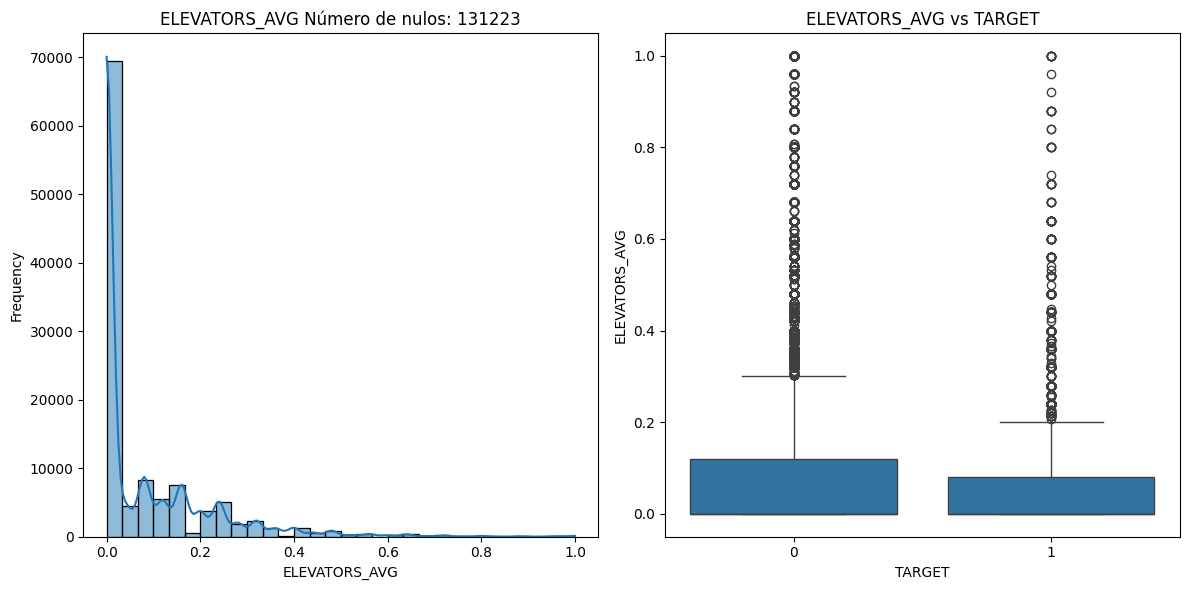

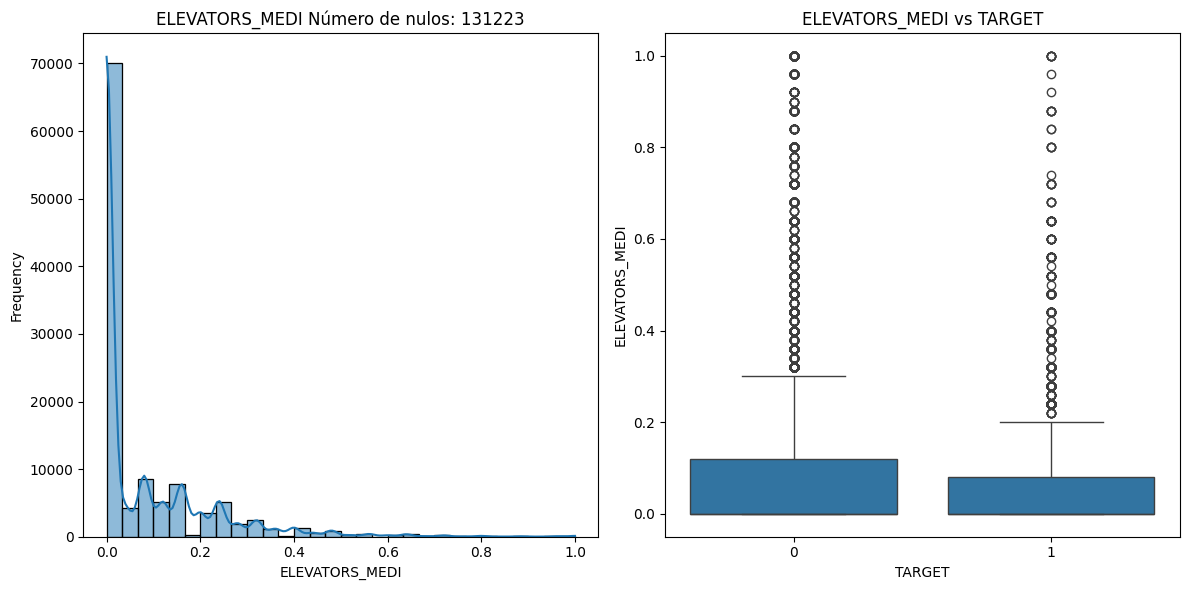

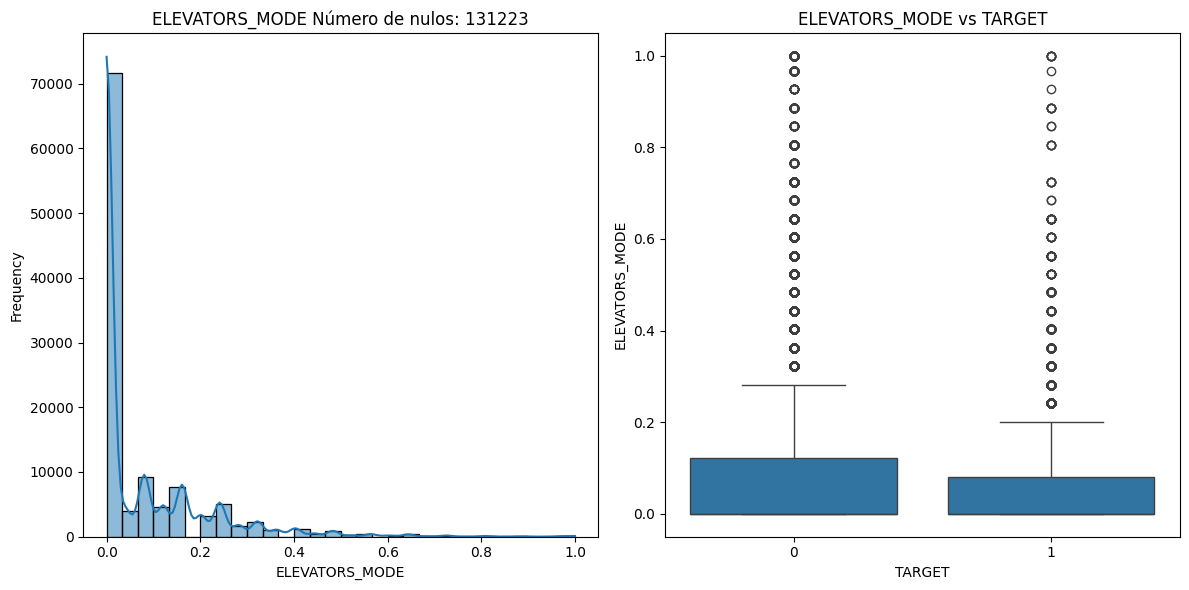

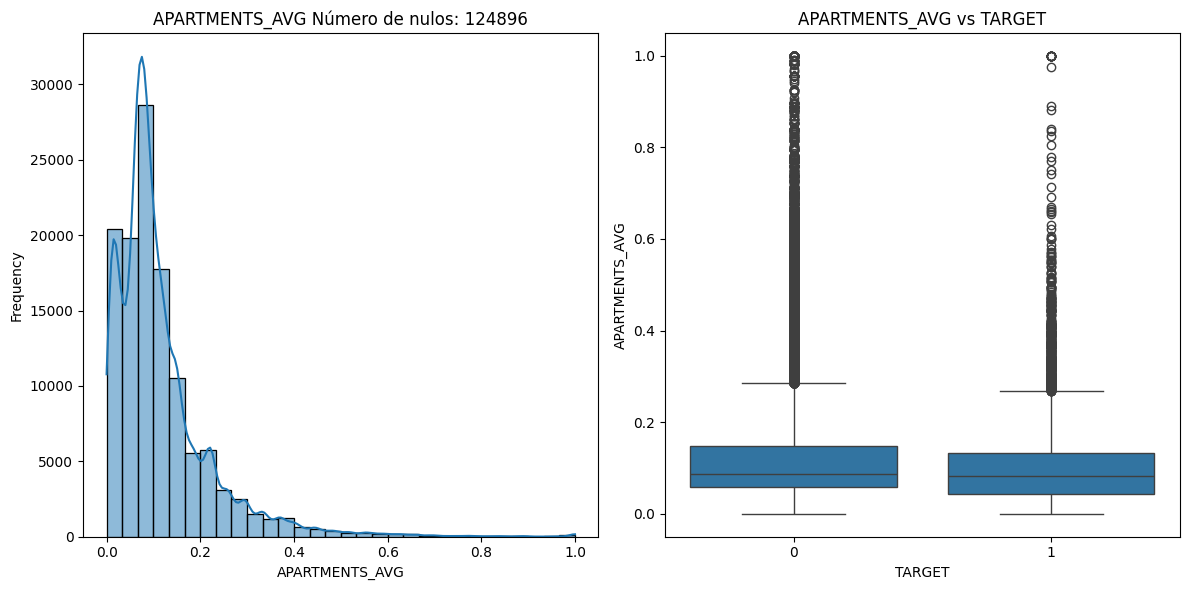

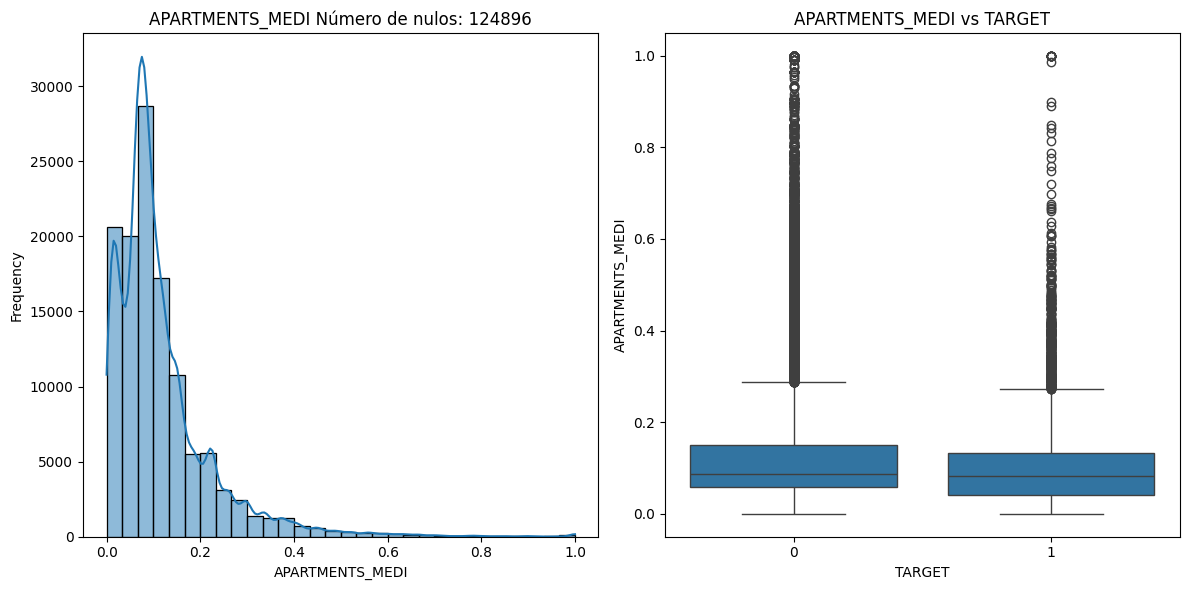

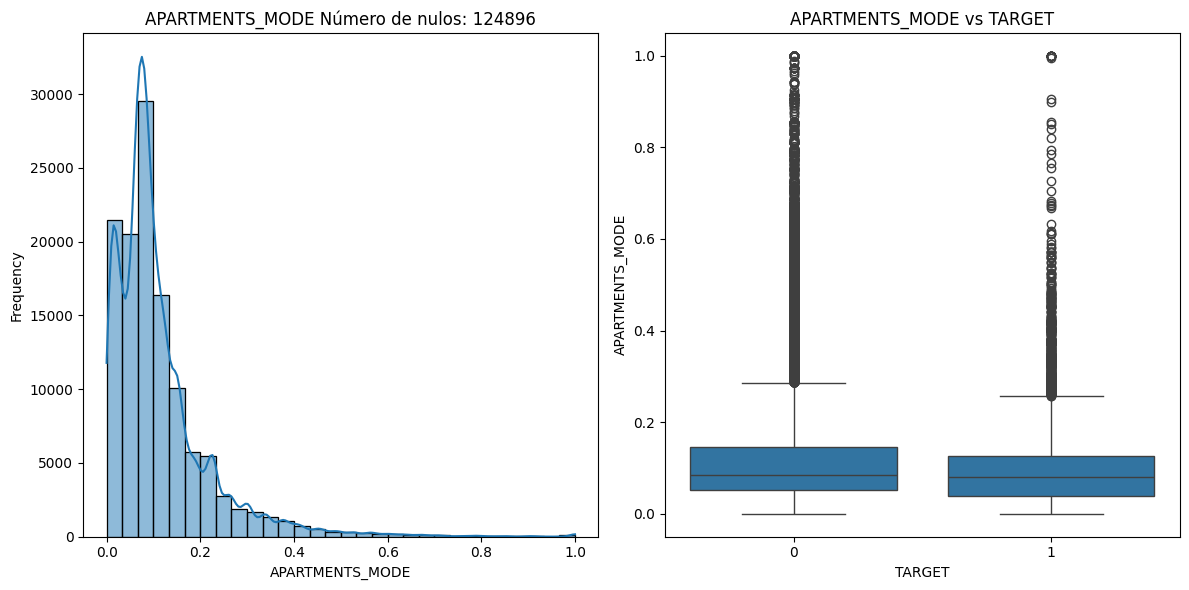

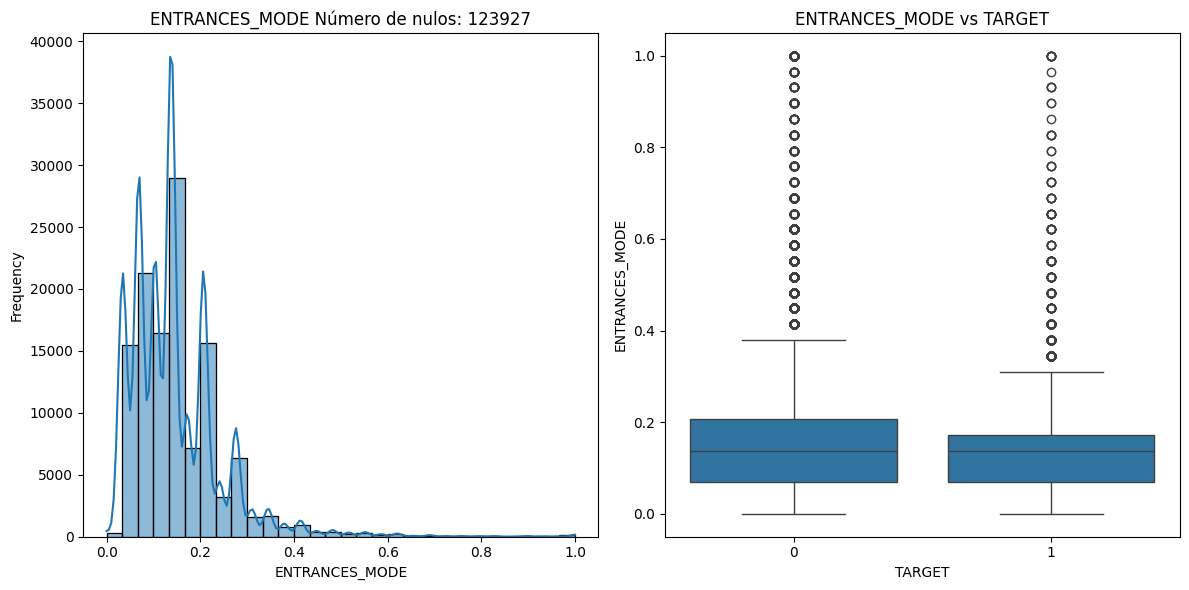

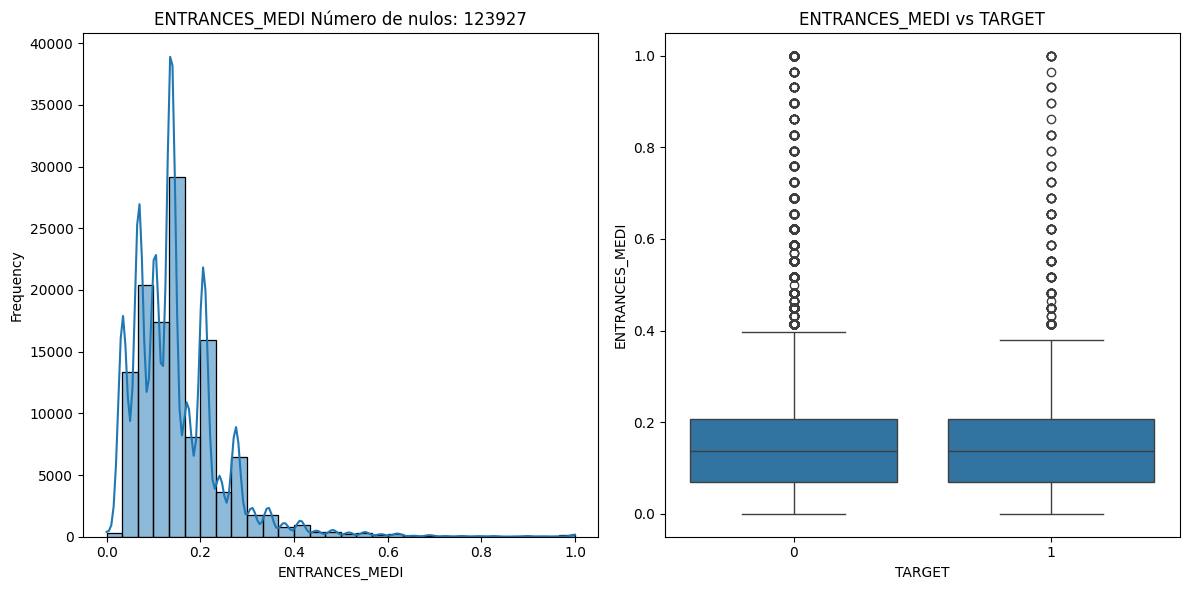

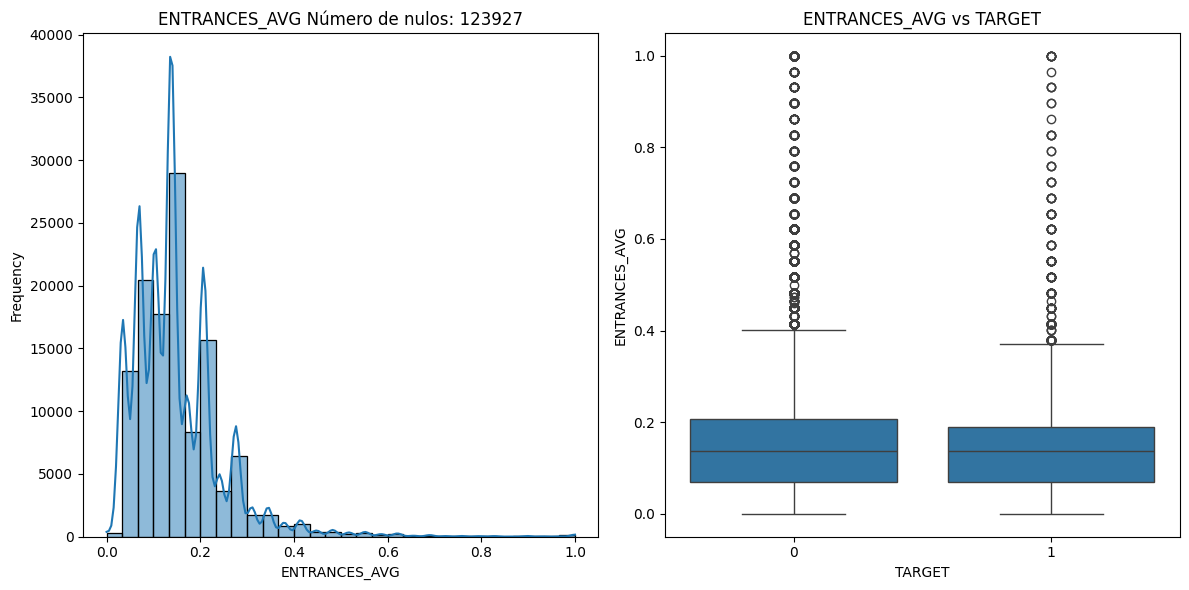

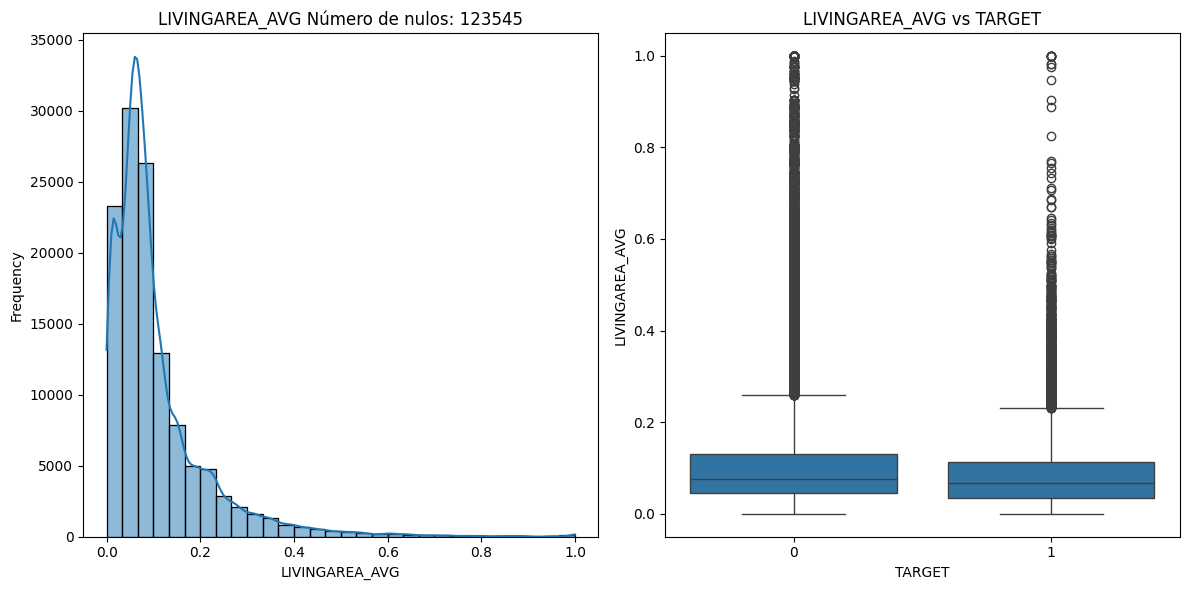

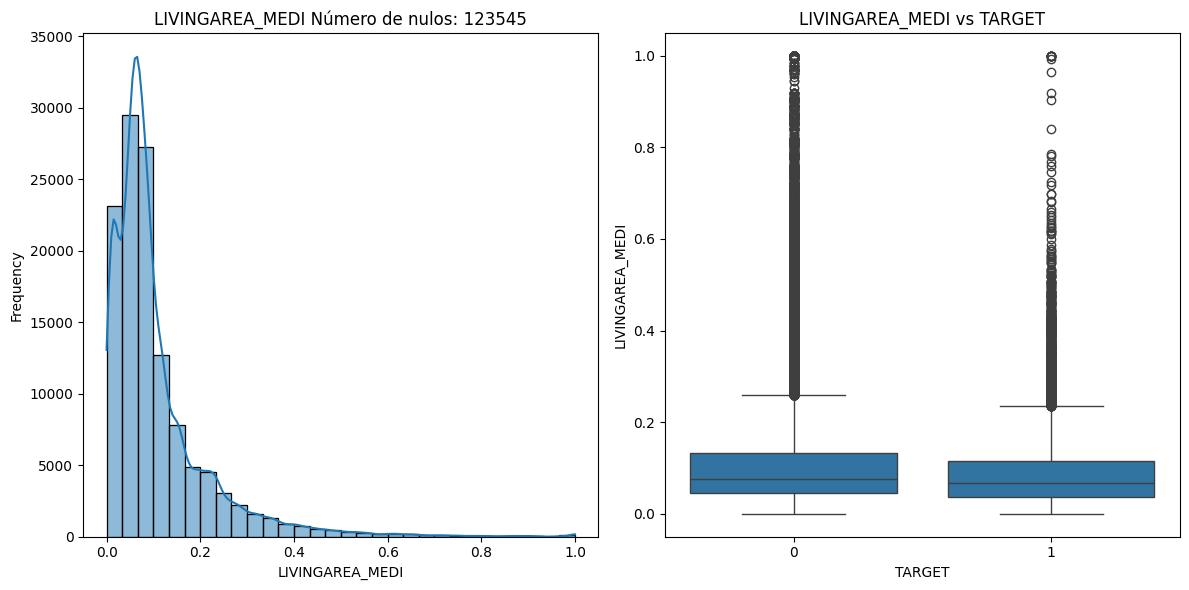

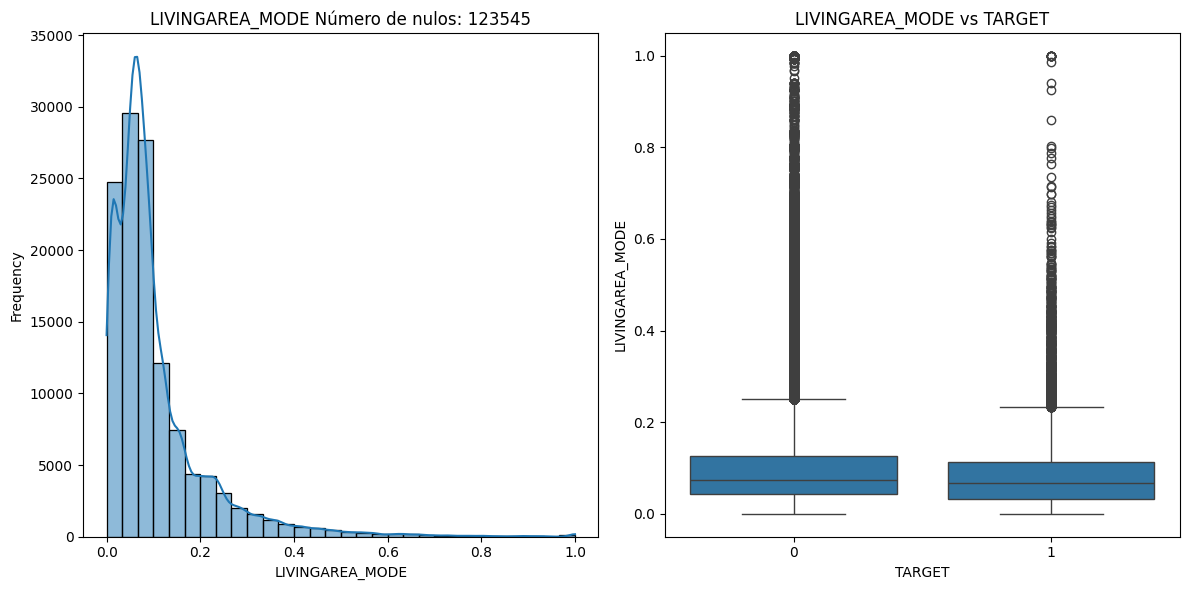

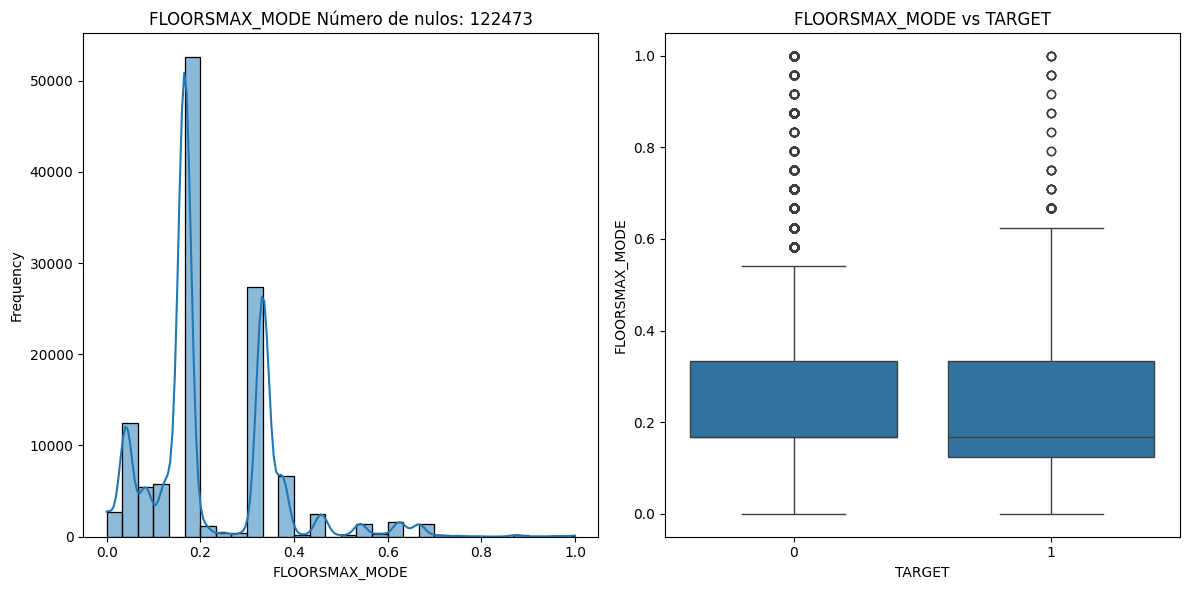

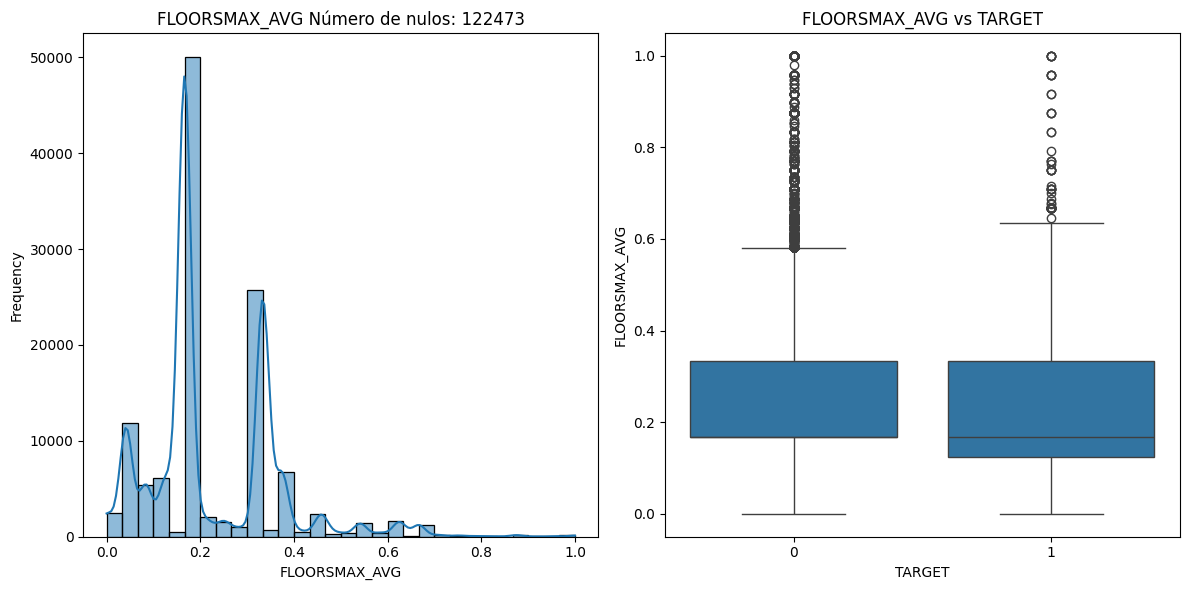

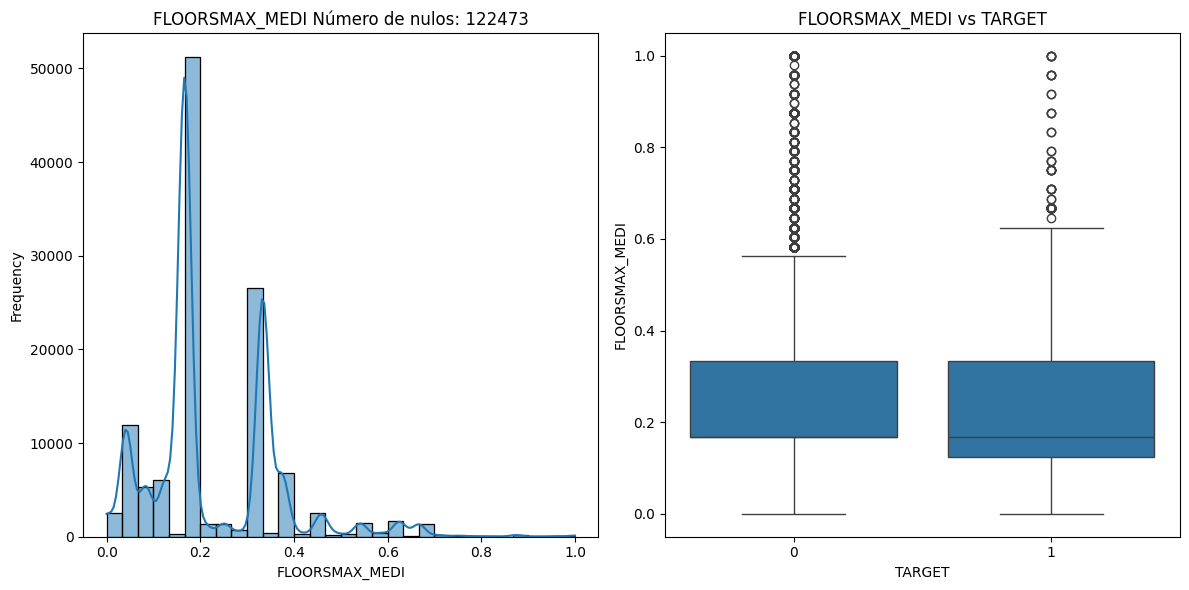

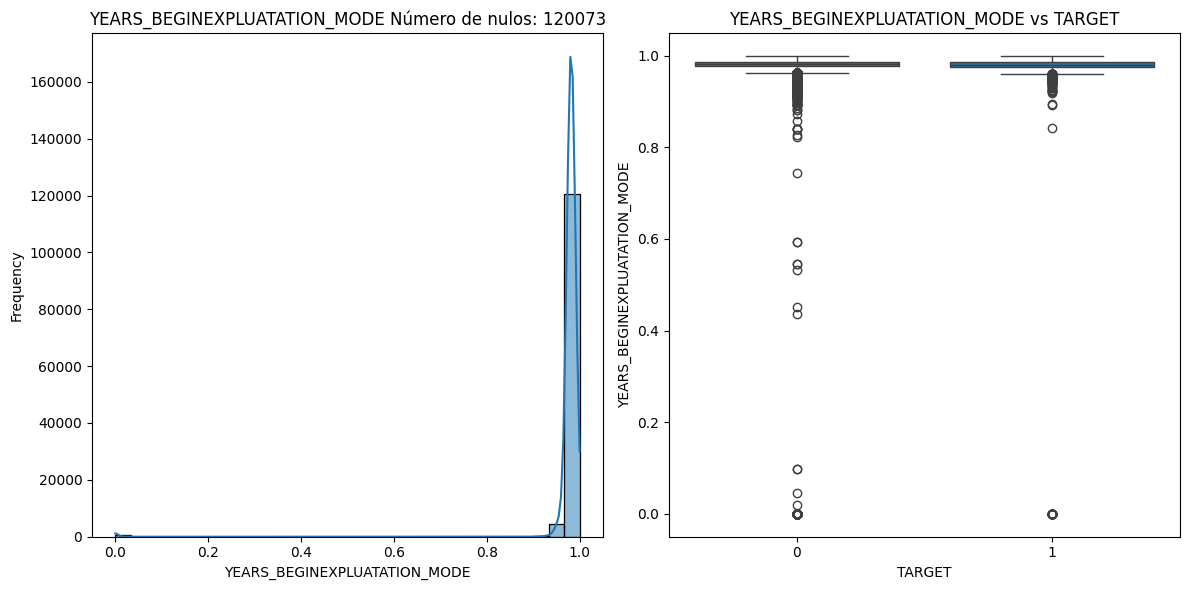

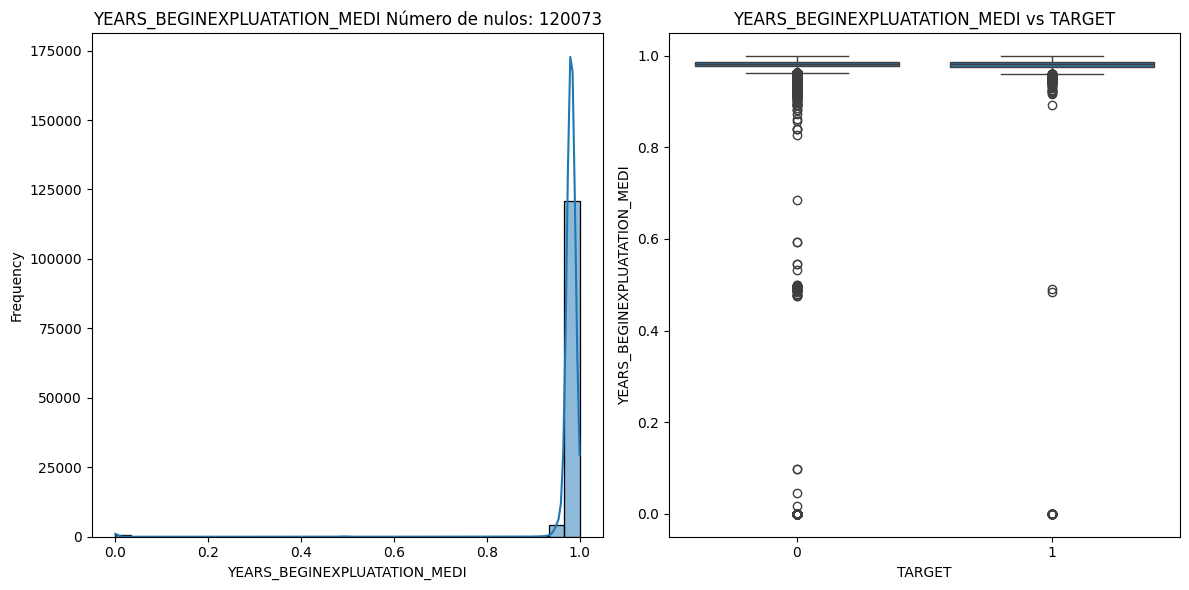

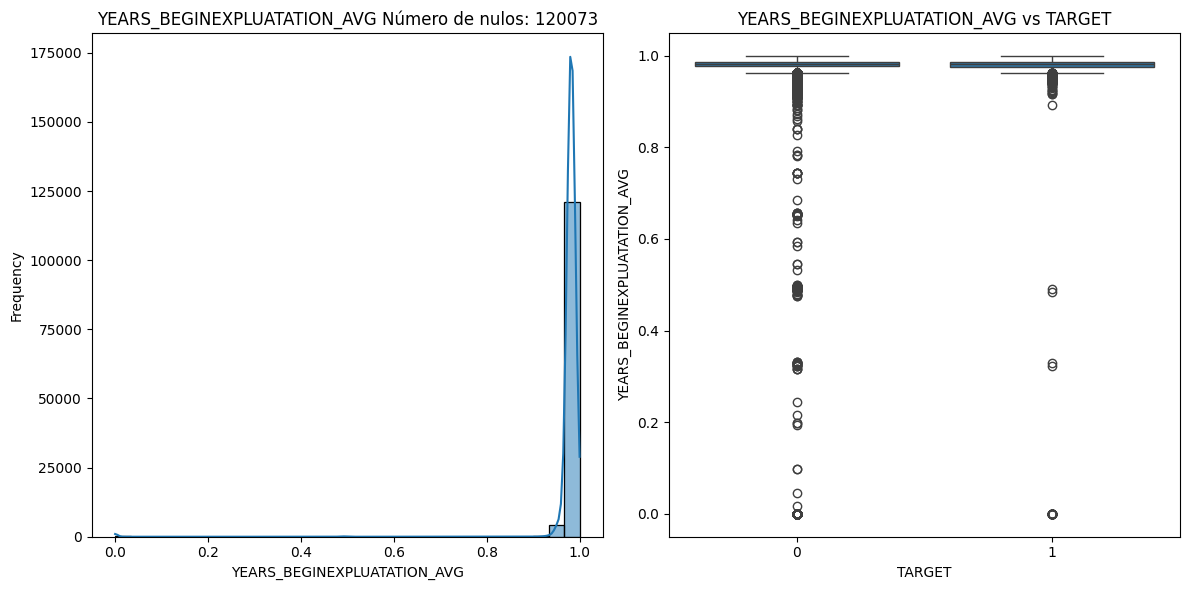

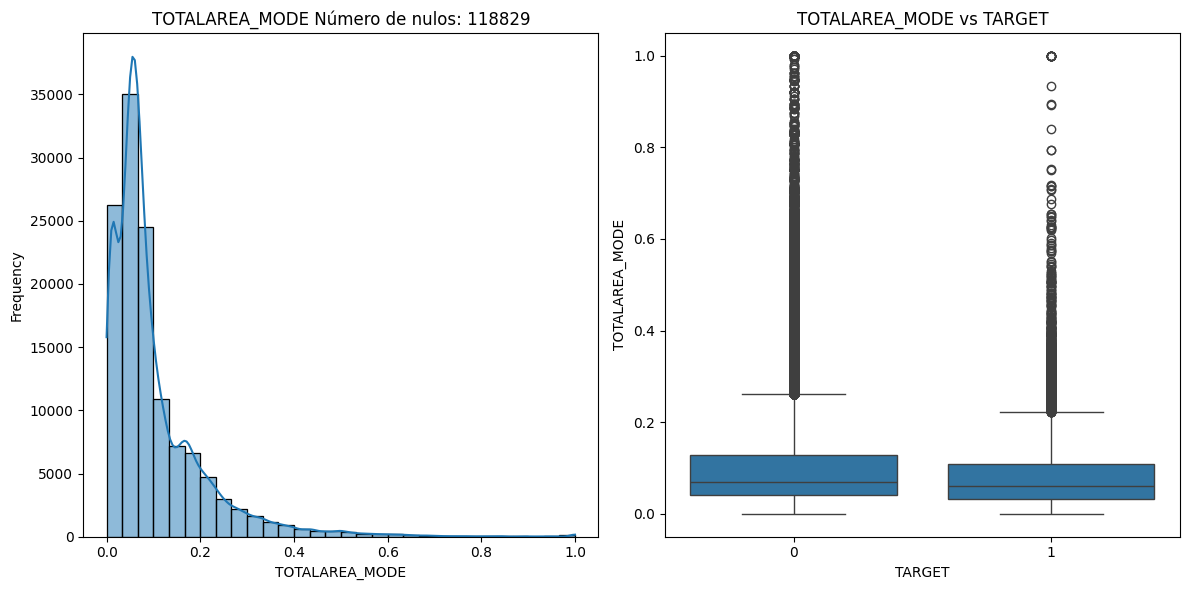

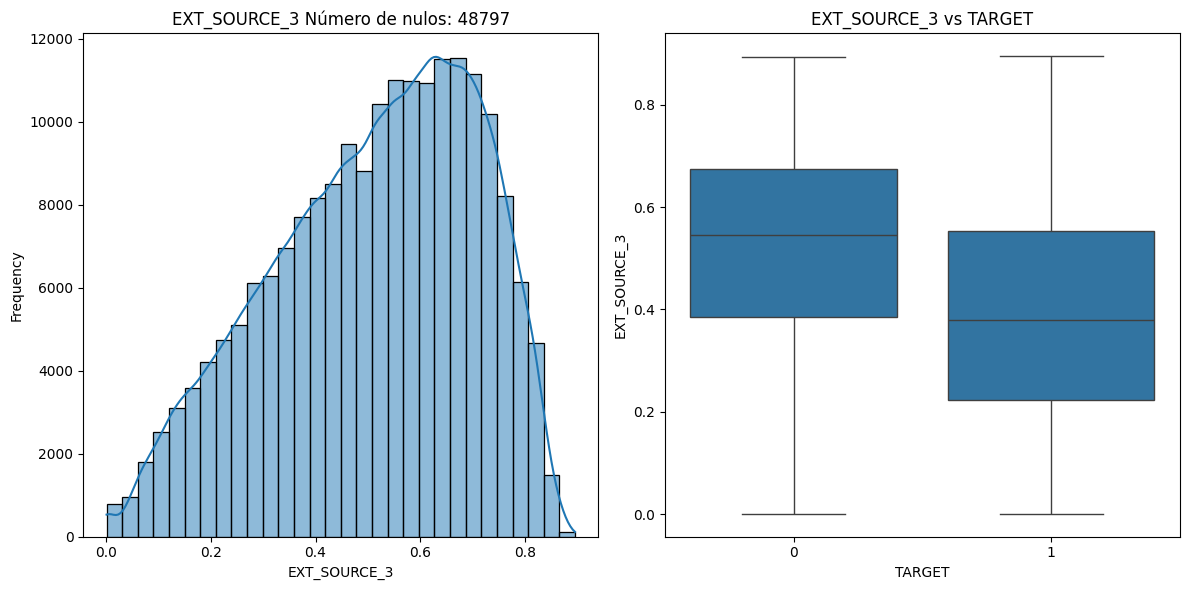

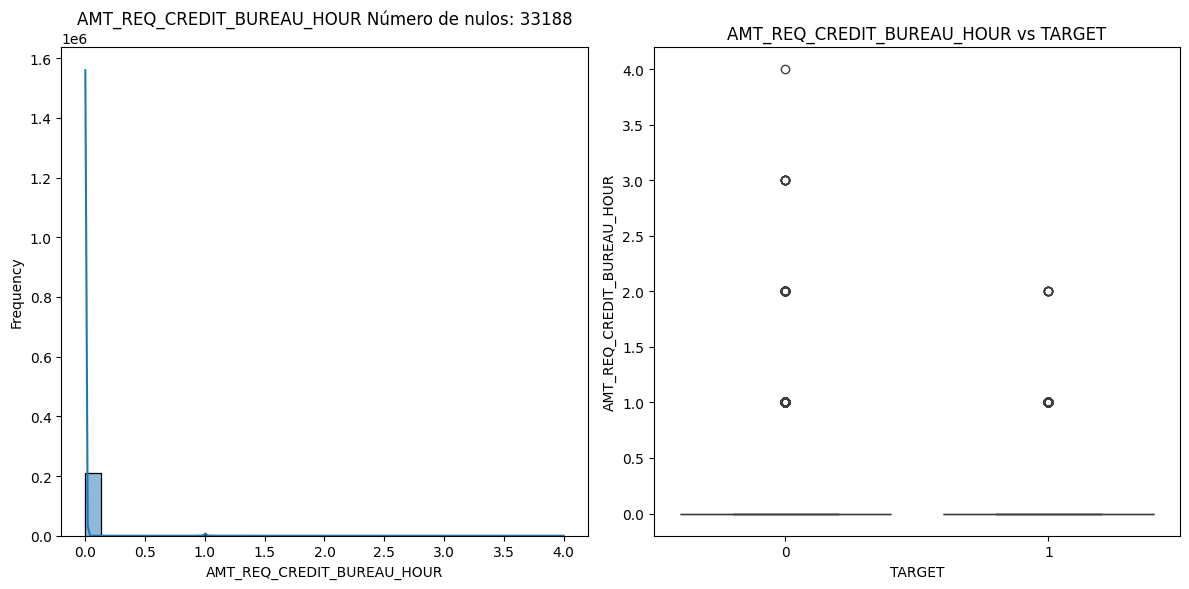

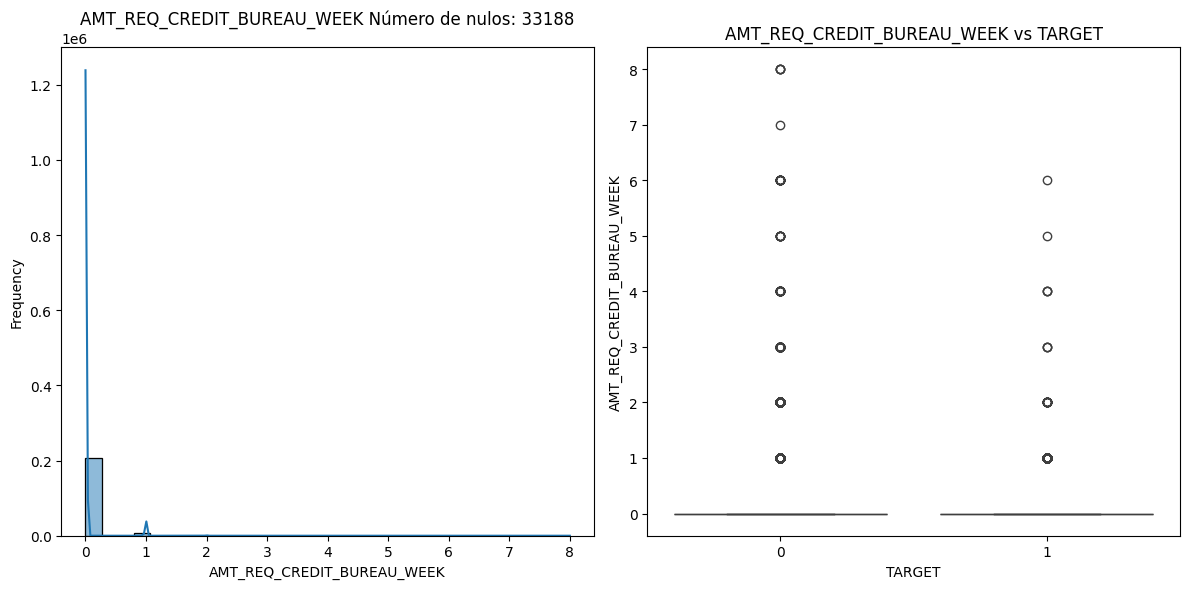

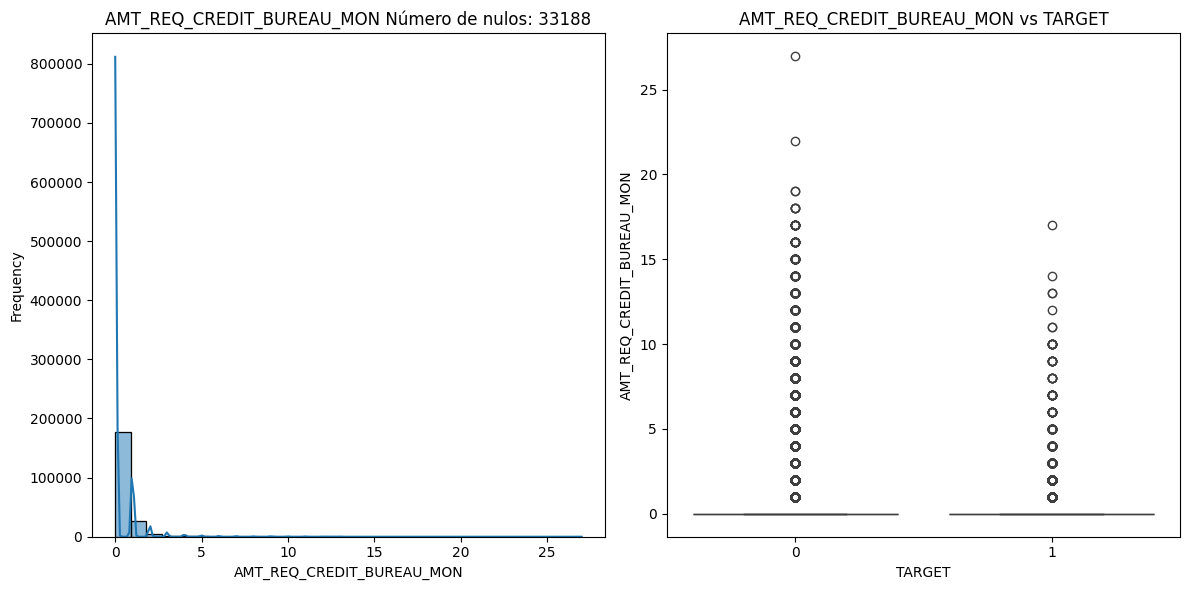

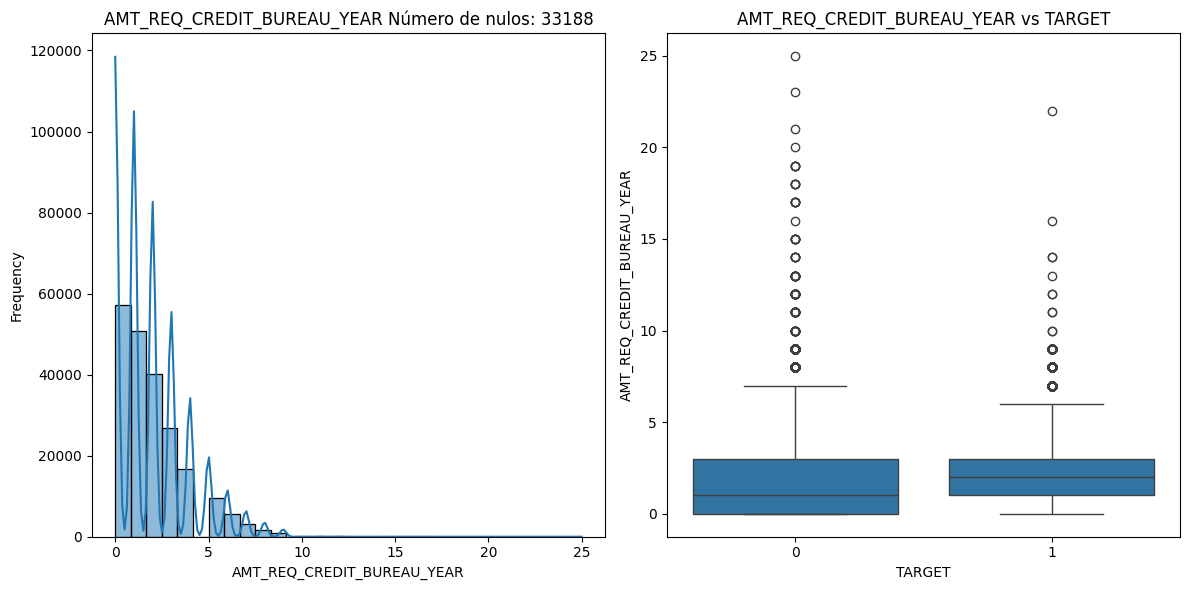

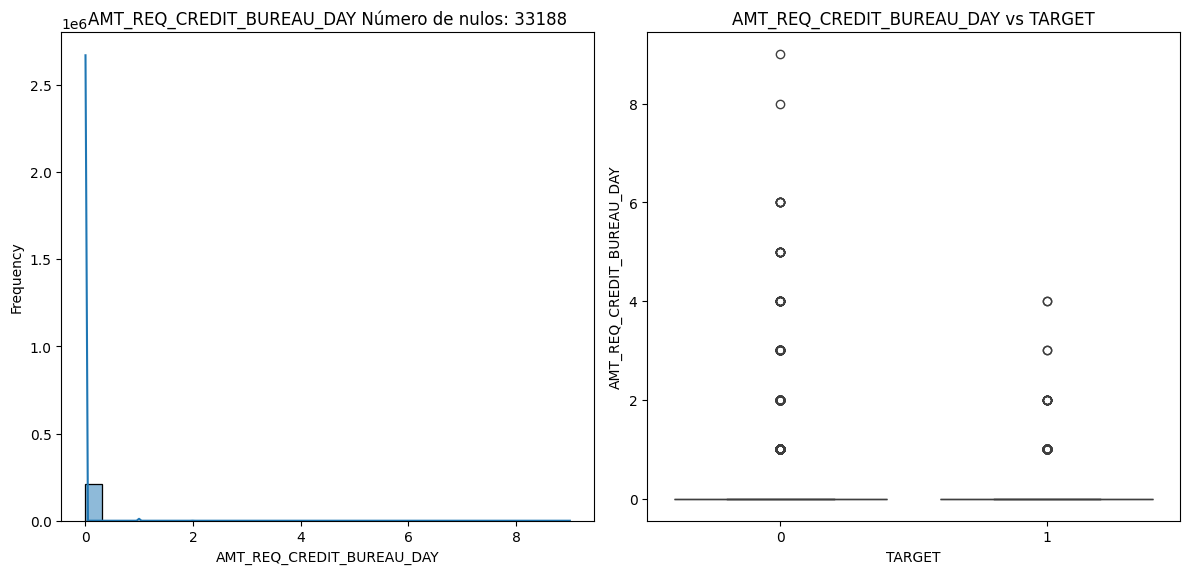

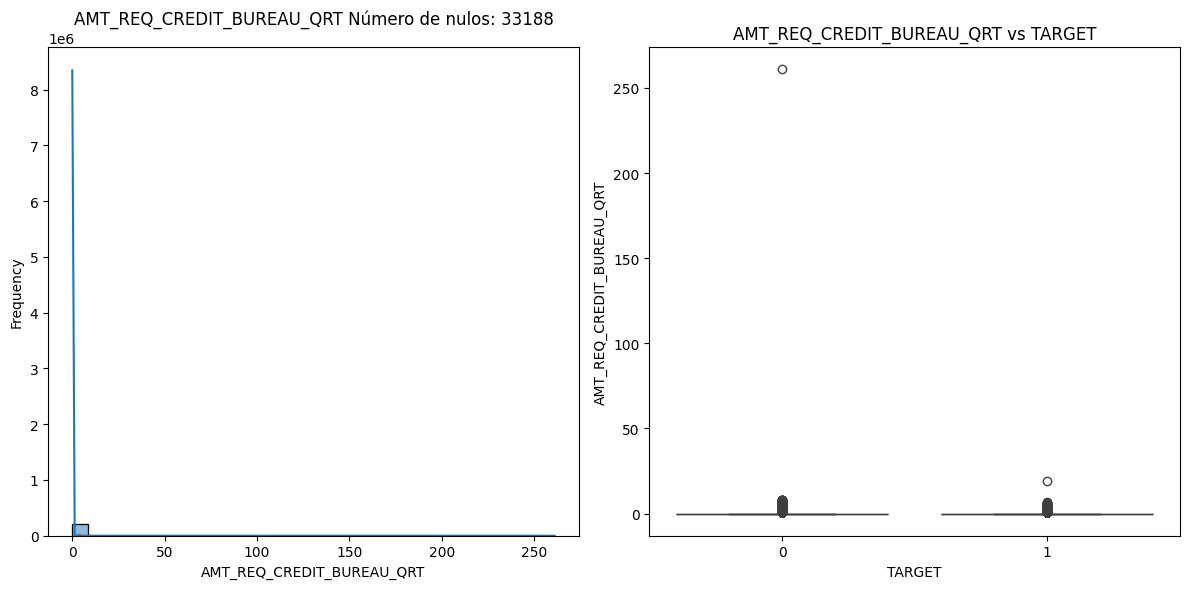

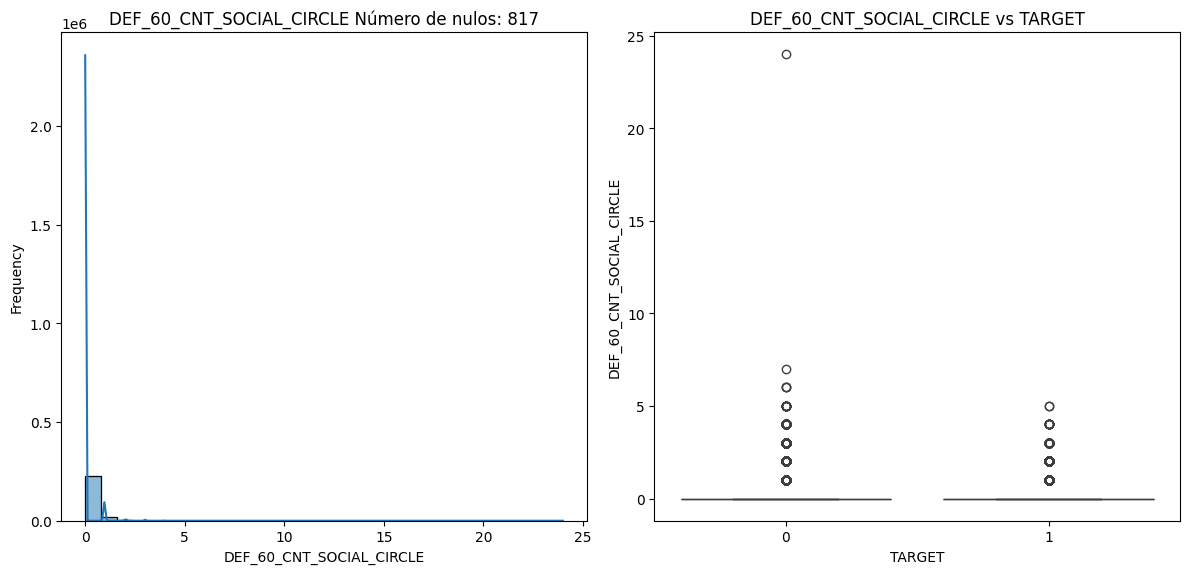

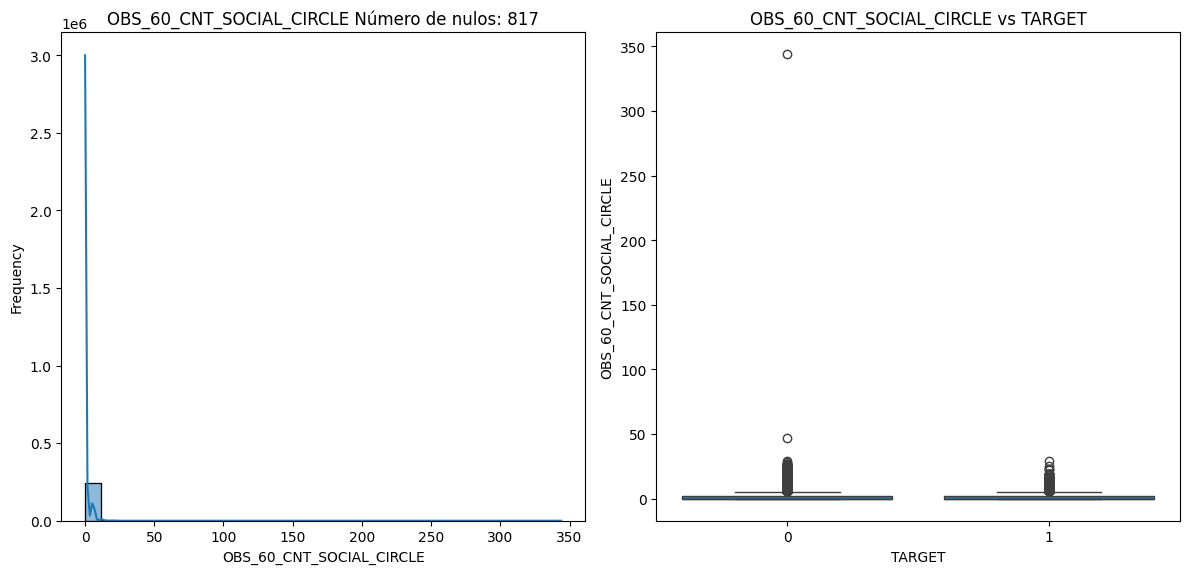

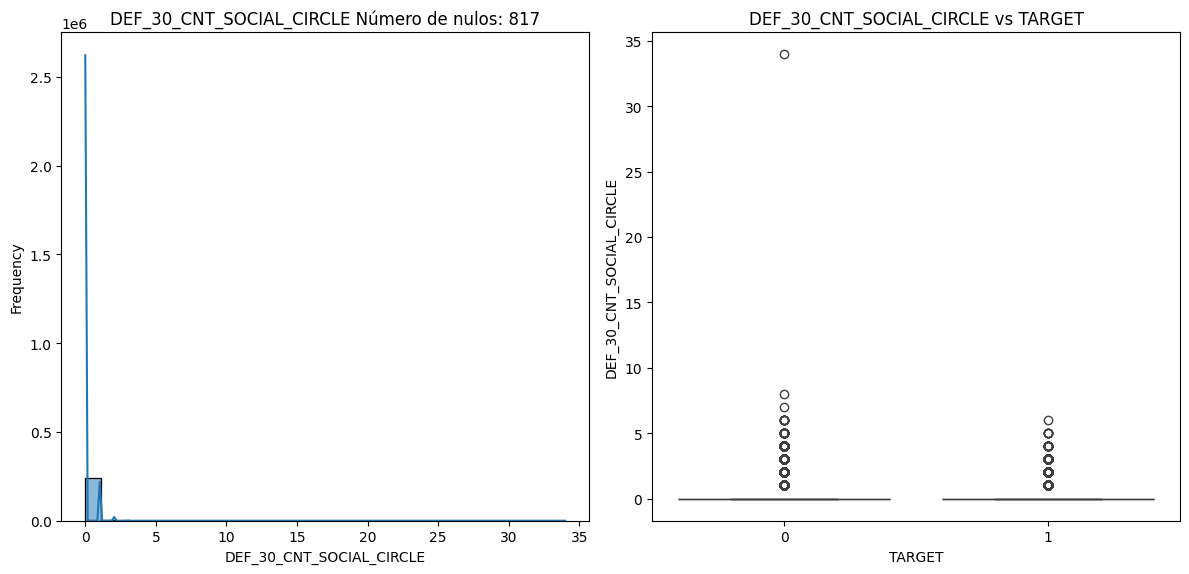

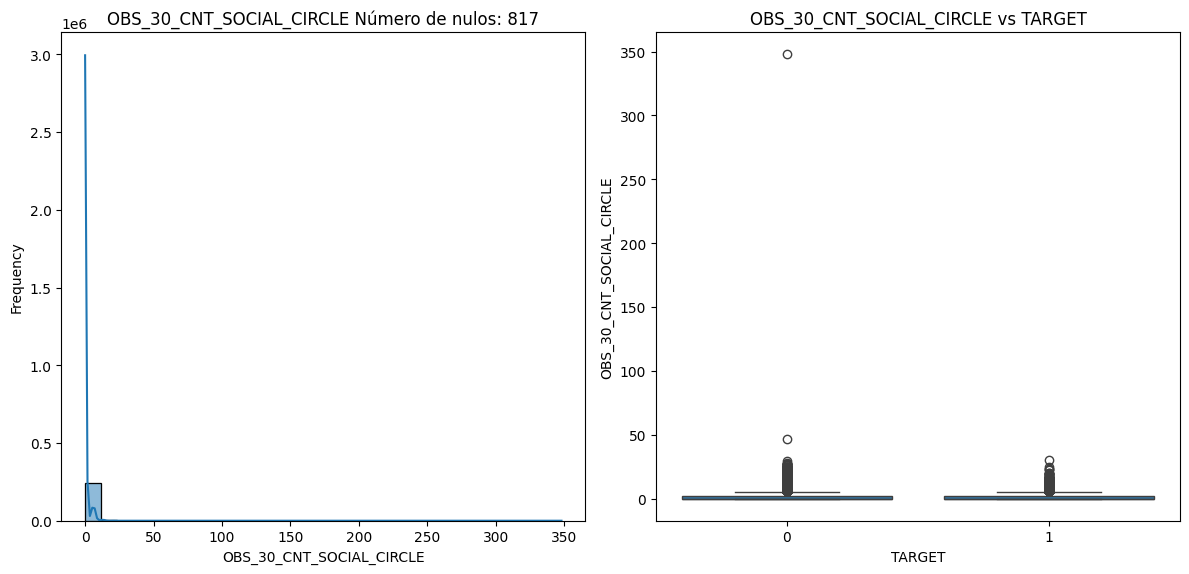

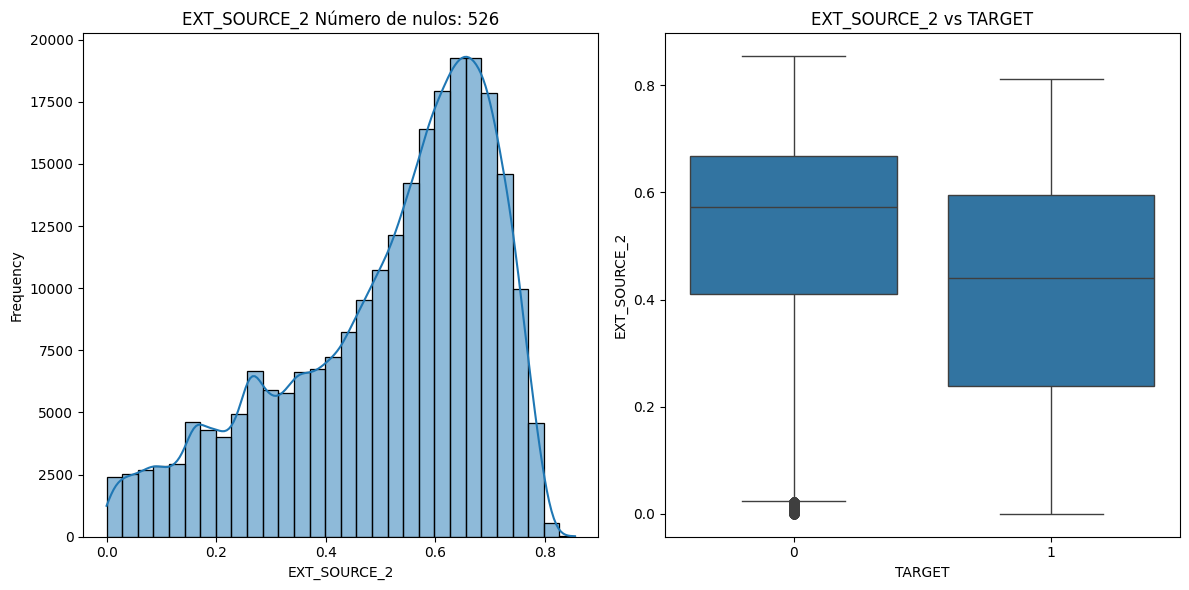

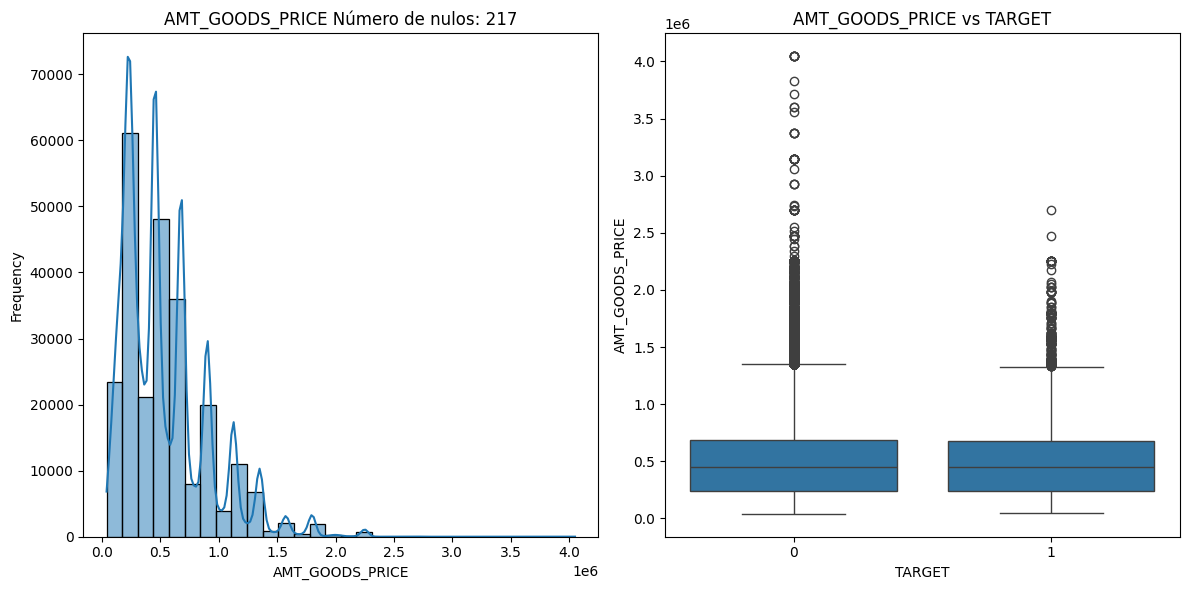

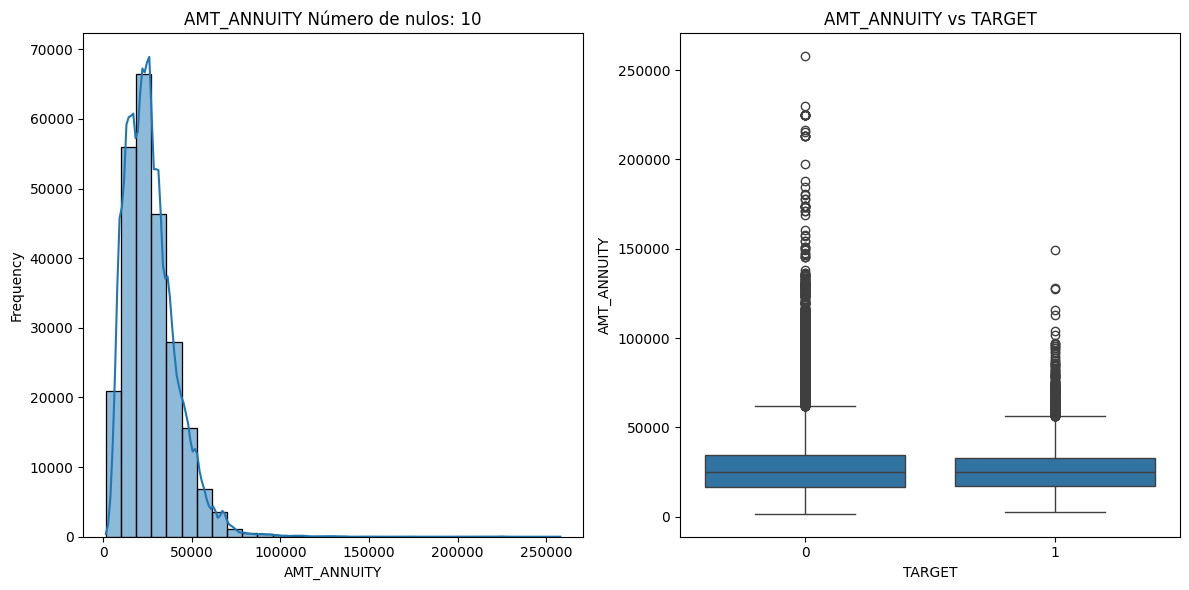

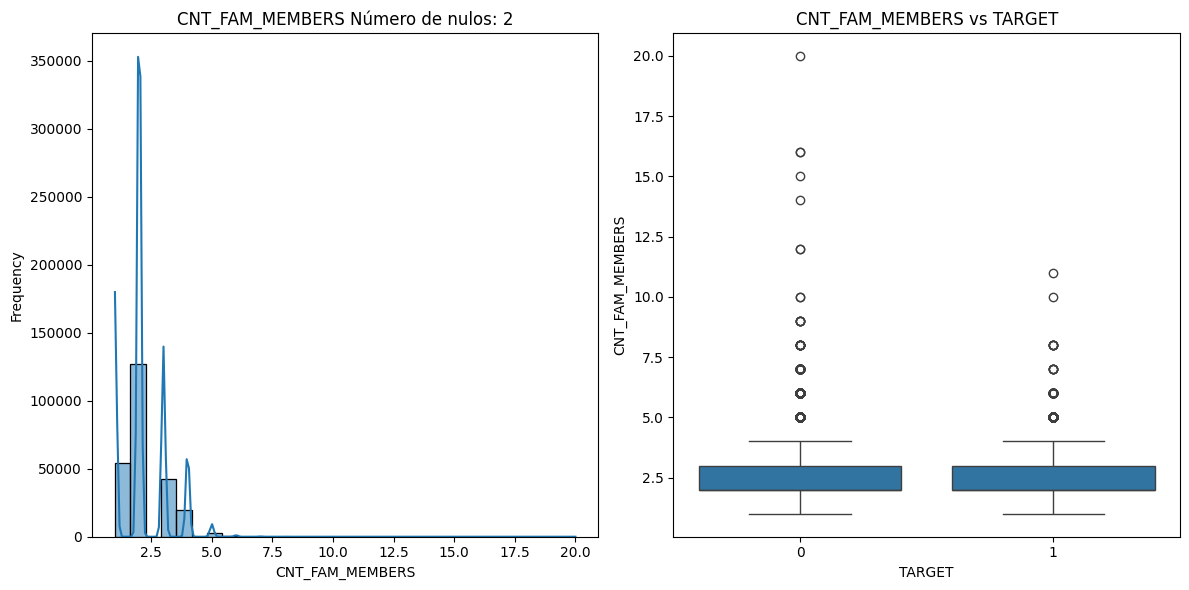

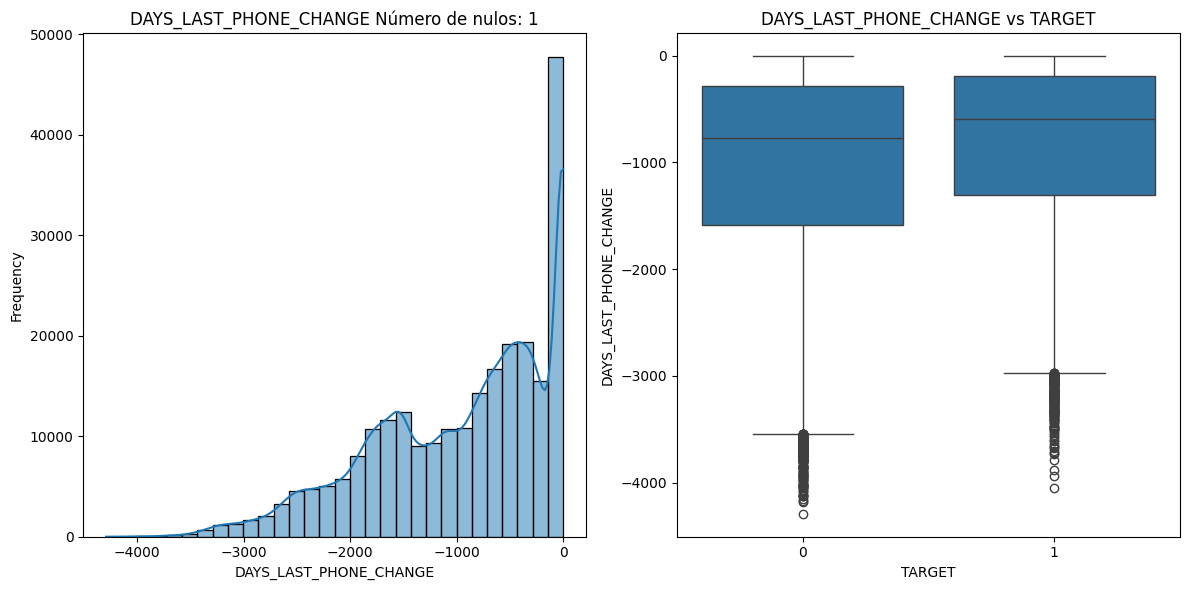

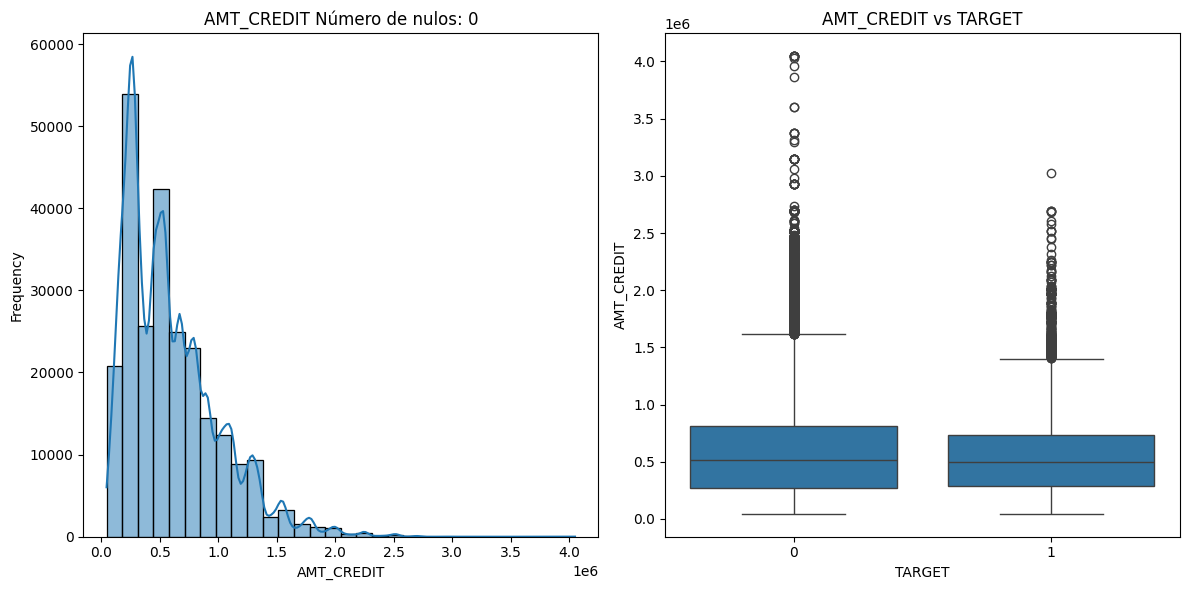

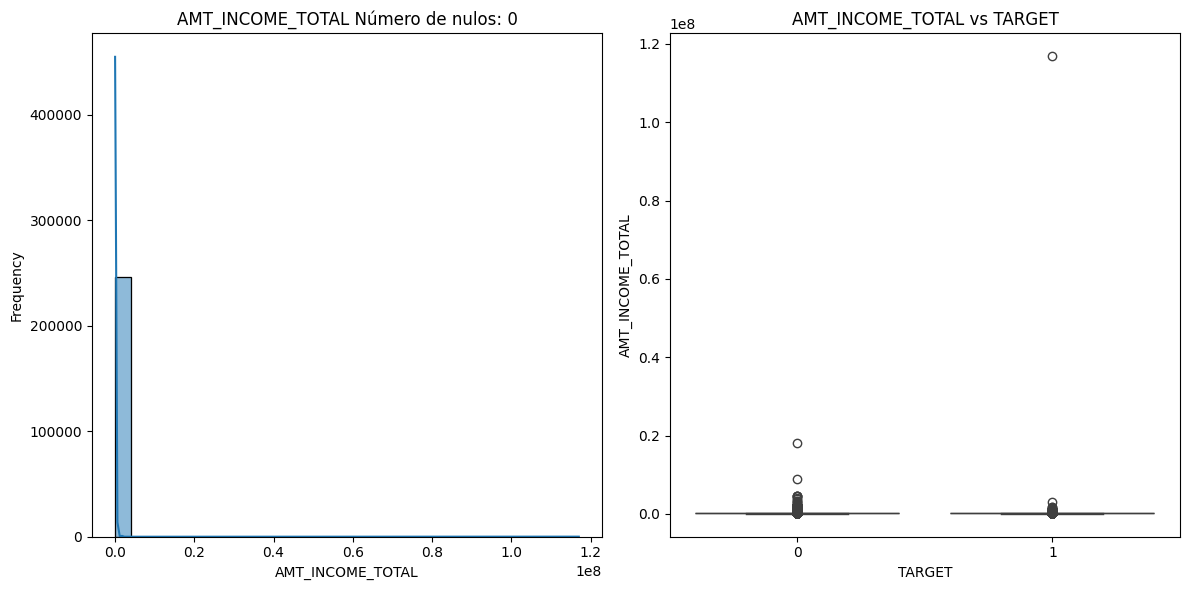

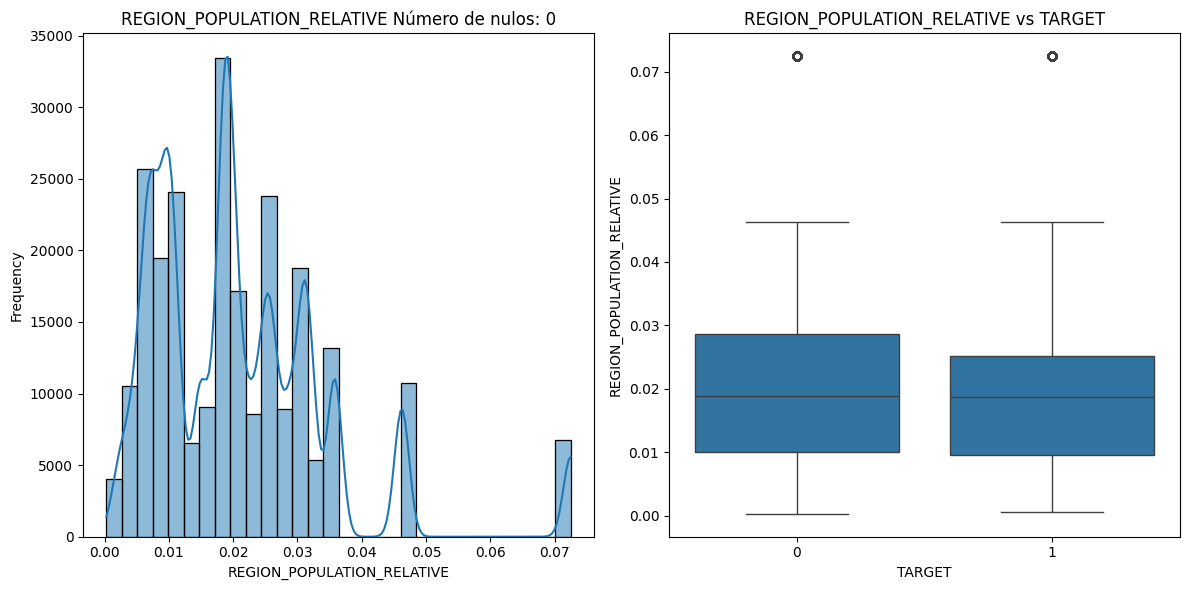

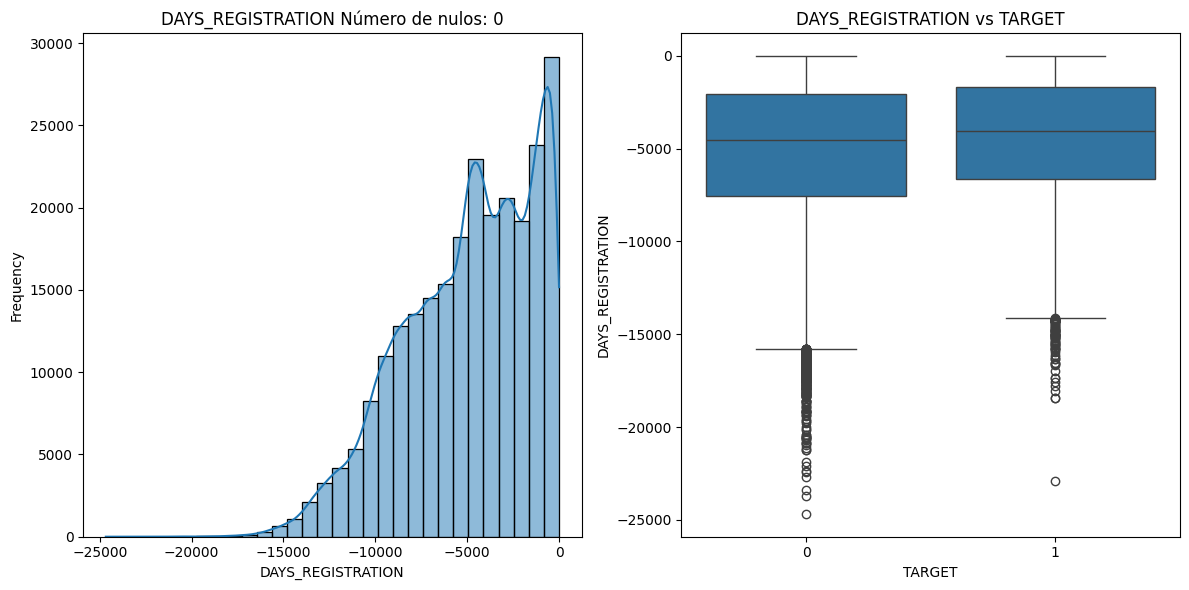

In [16]:
for variable in list_var_continuous:  # Lista de variables continuas
    if variable != "TARGET":
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Histograma
        sns.histplot(data=pd_loan_train, x=variable, kde=True, ax=axes[0], bins=30)
        axes[0].set_title(f'{variable} Número de nulos: {pd_loan_train[variable].isna().sum()}')
        axes[0].set_ylabel('Frequency')

        # Boxplot vs TARGET
        sns.boxplot(data=pd_loan_train, x='TARGET', y=variable, ax=axes[1])
        axes[1].set_title(f'{variable} vs TARGET')
        axes[1].set_ylabel(variable)
        axes[1].set_xlabel('TARGET')

        # Ajustar diseño
        plt.tight_layout()
        plt.show()

Una vez realizados los gráficos de las variables continuas con la variable objetivo (TARGET), procederemos a realizar algunos comentarios de algunas variables que puedan influir
en la misma, así como algunas que no sean tan significativas para tener un ejemplo de todo. A continuación, veremos cuáles son las variables elegidas.

OWN_CAR_AGE (Edad del coche propio).
Como vemos en el gráfico de la izquierda, hay un número considerable de valores nulos, concretamente 162.426, lo que indica que muchas personas no poseen automóvil o no hay información a cerca de ellos. Esto se debería gestionar mediante, por ejemplo, con la imputación o creando una categoría específica para los que no tienen automóvil. La mayoría de los coches tienen entre 0 y 20 años, con una concentración importante sobre todo de 0 a 10. No hay casi valores más allá de los 40 años, solo unos pocos datos sobrepasan los 60 años. En cuanto a su relación con TARGET, vemos en los boxplots que no hay grandes diferencias en la mediana ni en el rango intercuartílico para 0 y para 1, lo que nos puede indicar que no el coche propio puede no ser un factor influyente en cuanto a devolver o no el crédito.

EXT_SOURCE_1 (Puntuaciones de riesgo crediticio para los solicitantes que provienen de fuentes externas).
En el gráfico de la izquierda se puede observar que la variable sigue una distribución simétrica con forma similar a una distribución normal. Esta variable tiene una elevada cantidad de valores lo que indica que puede ser útil para discriminar entre distintos tipos de solicitantes. En cuanto a su relación con TARGET, observamos que el boxplot muestra que la mediana para los clientes que no incumplen (TARGET=0) es algo mayor que la de los que sí incumplen (TARGET=1) tienden a tener valores más altos, lo que puede decir que esta variable está asociada con un menor riesgo de incumplimiento.El rango intercuartílico es algo mayor también en los clientes cumplidores que en los que no. Podemos decir que esta variable puede tener un cierto poder predictivo.Los valores altos de EXT_SOURCE_1 se asocian con un menor riesgo de incumplimiento.


CNT_FAM_MEMBERS (Numero de miembros de la familia).
En el gráfico de la izquierda vemos que la variable posee 2 valores nulos, algo que no es significativo dentro del total de datos. En el histograma se muestra que la mayoría de los datos se encuentran entre 2 y 4 miembros, concentrándose sobre todo en 2, sugiriendo que una gran parte de las familias son pequeñas. En relación con TARGET, el boxplot muestra que la distribución es similiar tanto para los cumplidores como para los que no. Tanto la mediana como el rango intercuartílico son iguales, lo que indica que no hay una gran relación con la probabilidad de impago. Hay algunas familias con un número elevado de miembros, aunque no parece que tengan un efecto significativo.


AMT_INCOME_TOTAL (Ingresos totales).
Esta variable no posee valores nulos, por lo que podría ser representativa. En cuanto al histograma, la distribución de la variable está sesgada hacia la izquierda, lo que indica que la mayoría de clientes tienen ingresos bajos. La distribuación de los ingresos para TARGET=0 y TARGET=1 es muy similar, La mediana y el rango intercuartílico son también casi iguales, lo que indica que el nivel de ingresos no tiene una relación directa con la posibilidad de impago.

EXT_SOURCE_2 (Puntuaciones de riesgo crediticio para los solicitantes que provienen de fuentes externas)
En este caso, presenta pocos valores nulos con respecto al total de los datos, aunque se podrían imputar para no perder demasiada información. En el histograma vemos que la mayoría de los valores están concentrados entre 0.4 y 0.8, es decir, sesgados a la derecha, mientras que los valores extremos son menos comunes.En cuanto a su relación con TARGET, vemos que los valores más altos están relacionados con los clientes que no incumplen. La mediana es mas alta para los clientes que no incumplen, lo que un valor más alto de la variable podría estar asociado con un menor riesgo de incumplimiento. El rango intercuartílico es bastante parecido, aunque se observa que los valores bajos se concentran más en los clientes que presentan incumplimiento, por lo que podemos decir que esta variable puede ser un buen predictor.

EXT_SOURCE_3 (Puntuaciones de riesgo crediticio para los solicitantes que provienen de fuentes externas)
Al igual que en las variables anteriores como EXT_SOURCE_1 y EXT_SOURCE_2, prsenta los valores más altos asocidados a clientes que no incumplen el préstamo, lo que indica que valores bajos poseen un mayor riesgo de incumplimiento. Por lo tanto, podemos concluir que la información externa sobre clientes solicitantes de préstamo es una buena variable predictora.



In [17]:
get_deviation_of_mean_perc(pd_loan_train, list_var_continuous, target='TARGET', multiplier=3)

0.0       1.0                    variable  sum_outlier_values  \
0   0.951327  0.048673              COMMONAREA_AVG                1356   
1   0.947407  0.052593             COMMONAREA_MODE                1350   
2   0.949672  0.050328             COMMONAREA_MEDI                1371   
3   0.936057  0.063943    NONLIVINGAPARTMENTS_MEDI                 563   
4   0.930320  0.069680    NONLIVINGAPARTMENTS_MODE                 531   
..       ...       ...                         ...                 ...   
57  0.952107  0.047893      DAYS_LAST_PHONE_CHANGE                 522   
58  0.961642  0.038358                  AMT_CREDIT                2607   
59  0.940367  0.059633            AMT_INCOME_TOTAL                 218   
60  0.959299  0.040701  REGION_POPULATION_RELATIVE                6732   
61  0.957447  0.042553           DAYS_REGISTRATION                 611   

    porcentaje_sum_null_values  
0                     0.005512  
1                     0.005488  
2                     0.005573  
3                     0.002289  
4                     0.002158  
..                         ...  
57                    0.002122  
58                    0.010597  
59                    0.000886  
60                    0.027365  
61                    0.002484  

[62 rows x 5 columns]

CORRELACIONES

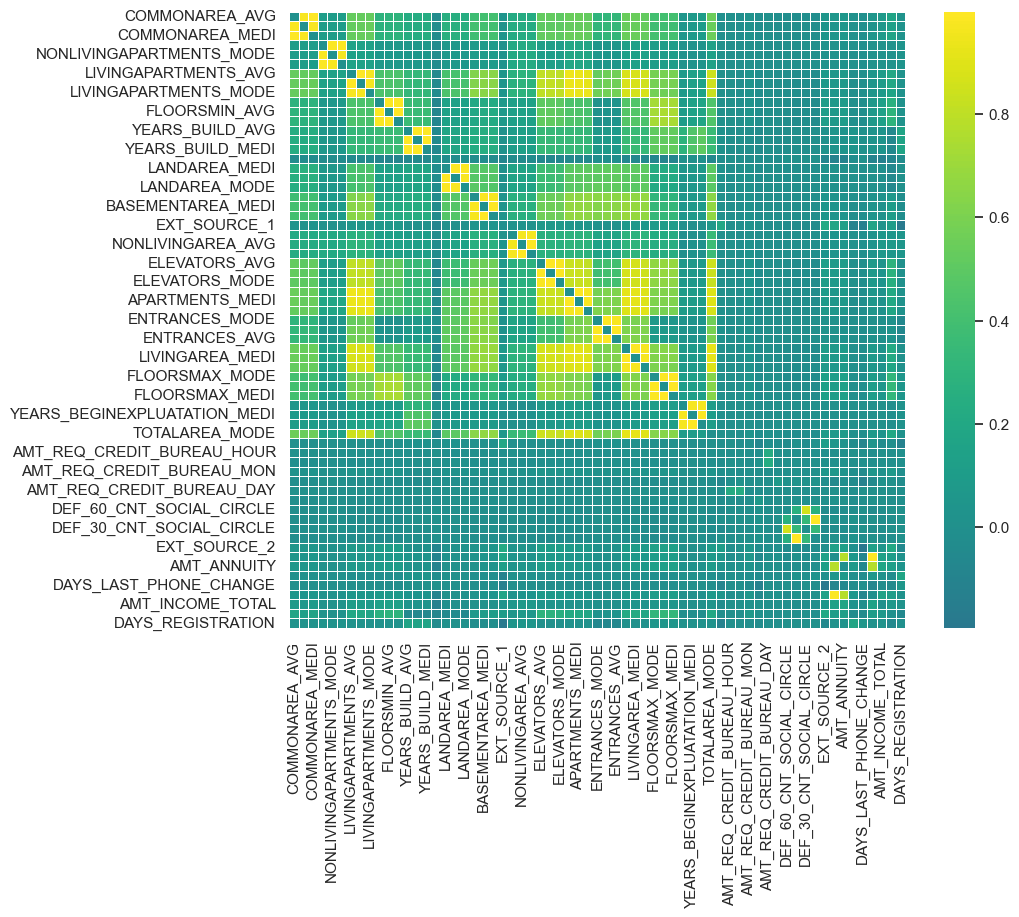

0

In [18]:
get_corr_matrix(dataset = pd_loan_train[list_var_continuous], 
                metodo='pearson', size_figure=[10,8])

Según la matriz de correlación obtenida, podemos observar variables con una alta correlación como aquellas que se tratan de áreas o tamaños de vivienda. Sin embargo, esto nos puede llevar a pensar que hay redundancia de las variables en nuestro dataset, por lo que podríamos plantear en un futuro realizar un análisis de reducción de variables como PCA para simplificar nuestro modelo, ya que la redundancia podría generar problemas de multicolinealidad. Además, vemos que la matriz es prácticamente azul, lo que significa que la correlación entre las variables es cercana a 0, lo que indica alta independencia de las variables. 

In [19]:
corr = pd_loan_train[list_var_continuous].corr('pearson')
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1) # below main lower triangle of an array
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation']>0.6]

level_0                   level_1  correlation
922           YEARS_BUILD_MEDI           YEARS_BUILD_AVG     0.998664
3628  OBS_30_CNT_SOCIAL_CIRCLE  OBS_60_CNT_SOCIAL_CIRCLE     0.998519
725             FLOORSMIN_MEDI             FLOORSMIN_AVG     0.997182
2639            FLOORSMAX_MEDI             FLOORSMAX_AVG     0.996961
2243             ENTRANCES_AVG            ENTRANCES_MEDI     0.996859
...                        ...                       ...          ...
2239             ENTRANCES_AVG            APARTMENTS_AVG     0.611607
2240             ENTRANCES_AVG           APARTMENTS_MEDI     0.611601
2175            ENTRANCES_MEDI           APARTMENTS_MEDI     0.611543
2174            ENTRANCES_MEDI            APARTMENTS_AVG     0.608072
2507            FLOORSMAX_MODE           LIVINGAREA_MODE     0.606393

[200 rows x 3 columns]

In [23]:
corr = pd_loan_train[list_var_continuous].corr('spearman')
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1) 
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation']>0.6]

level_0                       level_1  correlation
922              YEARS_BUILD_MEDI               YEARS_BUILD_AVG     0.998415
2837  YEARS_BEGINEXPLUATATION_AVG  YEARS_BEGINEXPLUATATION_MEDI     0.997420
3628     OBS_30_CNT_SOCIAL_CIRCLE      OBS_60_CNT_SOCIAL_CIRCLE     0.997303
461         LIVINGAPARTMENTS_MEDI          LIVINGAPARTMENTS_AVG     0.996280
725                FLOORSMIN_MEDI                 FLOORSMIN_AVG     0.996174
...                           ...                           ...          ...
2374              LIVINGAREA_MEDI                 ENTRANCES_AVG     0.608658
2373              LIVINGAREA_MEDI                ENTRANCES_MEDI     0.605834
2439              LIVINGAREA_MODE                 ENTRANCES_AVG     0.602991
2438              LIVINGAREA_MODE                ENTRANCES_MEDI     0.602343
2308               LIVINGAREA_AVG                ENTRANCES_MEDI     0.601431

[226 rows x 3 columns]

También hemos hecho la matriz de spearman. Ambas matrices proporcionan resultados muy parecidos, por lo que llegamos a la conclusión de que es necesario realizar una simplificación de las variables para evitar problemas en el modelado, ya que muchas de nuestras variables no nos están aportando un valor añadido y nos hace el trabajo más complejo.

TRATAMIENTO DE VALORES NULOS

En este caso, volvemos a hacer uso de una función establecida al principio del notebook para encontrar la suma y porcentaje de valores nulos por cada columna.

In [25]:
get_percent_null_values_target(pd_loan_train, list_var_continuous, target='TARGET')

0.0       1.0                  variable  sum_null_values  \
0   0.914000  0.086000            COMMONAREA_AVG           171942   
1   0.914000  0.086000           COMMONAREA_MODE           171942   
2   0.914000  0.086000           COMMONAREA_MEDI           171942   
3   0.913858  0.086142  NONLIVINGAPARTMENTS_MEDI           170858   
4   0.913858  0.086142  NONLIVINGAPARTMENTS_MODE           170858   
..       ...       ...                       ...              ...   
56  0.927757  0.072243              EXT_SOURCE_2              526   
57  0.930876  0.069124           AMT_GOODS_PRICE              217   
58  1.000000  0.000000               AMT_ANNUITY               10   
59  1.000000  0.000000           CNT_FAM_MEMBERS                2   
60  1.000000  0.000000    DAYS_LAST_PHONE_CHANGE                1   

    porcentaje_sum_null_values  
0                     0.698928  
1                     0.698928  
2                     0.698928  
3                     0.694522  
4                     0.694522  
..                         ...  
56                    0.002138  
57                    0.000882  
58                    0.000041  
59                    0.000008  
60                    0.000004  

[61 rows x 5 columns]

Hemos decidido que nuestro umbral de valores nulos se situará en el 50%, es decir, sólo usaremos aquellas variables que cuenten con menos de un 50% de valores nulos. Haciendo este filtrado, creamos un nuevo df llamado pd_loan_train_filtered.

In [ ]:
threshold = 0.5
list_vars_not_null = list(pd_null_columnas[pd_null_columnas['porcentaje_columnas'] < threshold].index)
pd_loan_train_filtered = pd_loan_train.loc[:, list_vars_not_null]

print(pd_loan_train_filtered)

            FLOORSMAX_AVG  FLOORSMAX_MODE  FLOORSMAX_MEDI  \
SK_ID_CURR                                                  
234475             0.1667          0.1667          0.1667   
354059                NaN             NaN             NaN   
331770             0.1667          0.1667          0.1667   
222534                NaN             NaN             NaN   
205609             0.1667          0.1667          0.1667   
...                   ...             ...             ...   
297439                NaN             NaN             NaN   
194334                NaN             NaN             NaN   
182638                NaN             NaN             NaN   
155131                NaN             NaN             NaN   
215661             0.1667          0.1667          0.1667   

            YEARS_BEGINEXPLUATATION_AVG  YEARS_BEGINEXPLUATATION_MODE  \
SK_ID_CURR                                                              
234475                           0.9781                     

In [ ]:
pd_loan_train['AMT_GOODS_PRICE'].fillna(pd_loan_train['AMT_GOODS_PRICE'].median(), inplace=True)
pd_loan_train['AMT_ANNUITY'].fillna(pd_loan_train['AMT_ANNUITY'].median(), inplace=True)

C:\Users\Sara\AppData\Local\Temp\ipykernel_17916\2392578605.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\Sara\AppData\Local\Temp\ipykernel_17916\2392578605.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

En esta opción, estamos tratando los valores nulos de las variables AMT_GOODS_PRICE y AM_ANNUITY por la mediana de la variable. 

TRATAMIENTO VARIABLES CATEGÓRICAS

In [ ]:
list_var_cat

['FONDKAPREMONT_MODE',
 'WALLSMATERIAL_MODE',
 'HOUSETYPE_MODE',
 'EMERGENCYSTATE_MODE',
 'OCCUPATION_TYPE',
 'NAME_TYPE_SUITE',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_REGION_NOT_LIVE_REGION',
 'ORGANIZATION_TYPE',
 'NAME_CONTRACT_TYPE',
 'FLAG_OWN_CAR',
 'NAME_INCOME_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'NAME_EDUCATION_TYPE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'CODE_GENDER',
 'TARGET',
 'FLAG_OWN_REALTY',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_PHONE',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'REG_REGION_NOT_WORK_REGION',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_1

OPCIÓN 2

In [ ]:
pd_loan[list_var_continuous] = pd_loan[list_var_continuous].apply(lambda x: x.fillna(x.median()))

En esta opción, estamos imputando los valores nulos por la mediana de las variables que son contínuas.

In [ ]:
confusion_matrix = pd.crosstab(pd_loan_train["TARGET"], pd_loan_train["TARGET"])
print(confusion_matrix)
cramers_v(confusion_matrix.values)

TARGET       0      1
TARGET               
0       226148      0
1            0  19860


np.float64(0.9999726127135284)

In [ ]:
pd_loan_train[list_var_cat] = pd_loan_train[list_var_cat].astype("object").fillna("SIN VALOR").astype("category")
pd_loan_test[list_var_cat] = pd_loan_test[list_var_cat].astype("object").fillna("SIN VALOR").astype("category")

print(pd_loan_test)

C:\Users\Sara\AppData\Local\Temp\ipykernel_17916\1031770619.py:1: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\Sara\AppData\Local\Temp\ipykernel_17916\1031770619.py:2: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



            Unnamed: 0  COMMONAREA_AVG  COMMONAREA_MODE  COMMONAREA_MEDI  \
SK_ID_CURR                                                                 
120959           17971             NaN              NaN              NaN   
188080           75952             NaN              NaN              NaN   
374170          236702             NaN              NaN              NaN   
110932            9404          0.1018           0.1027           0.1024   
422405          278271             NaN              NaN              NaN   
...                ...             ...              ...              ...   
101191            1029             NaN              NaN              NaN   
351314          216895             NaN              NaN              NaN   
280734          155917             NaN              NaN              NaN   
372073          234878             NaN              NaN              NaN   
376716          238884             NaN              NaN              NaN   

           

En las variables categóricas, hemos decidido que cambiará los valores nulos por "SIN VALOR"

In [ ]:
pd_loan_train.to_csv("../data/train_pd_data_preprocessing_missing_outlier.csv")
pd_loan_test.to_csv("../data/test_pd_data_preprocessing_missing_outlier.csv")